In [41]:
import pandas as pd
import json
import random
from shapely import wkt, Point
import time
from collections import defaultdict
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.wkt as wkt
import numpy as np
import csv

In [42]:
# read sample data
with open('grouped_stats_nested.json', 'r') as file:
    data = json.load(file)

In [43]:
h3 = pd.read_csv('../../../data/raw/scrape/population_phnom_penh.csv')

In [44]:
h3.head()

h3  population  \
0  886586a6ebfffff       255.0   
1  886586a6ddfffff      1337.0   
2  886586a6dbfffff       125.0   
3  886586a6d9fffff       764.0   
4  886586a6d7fffff       323.0   

                                            geometry  index_right  Shape_Leng  \
0  MULTIPOLYGON (((104.97555292017218 11.70869197...          466    0.209855   
1  MULTIPOLYGON (((104.95959051419976 11.68686180...          466    0.209855   
2  MULTIPOLYGON (((104.94522418806201 11.68053577...          466    0.209855   
3  MULTIPOLYGON (((104.95426989678246 11.67958437...          466    0.209855   
4  MULTIPOLYGON (((104.94681957690541 11.69604271...          466    0.209855   

   Shape_Area    ADM3_EN ADM3_PCODE ADM3_REF  ADM3ALT1EN  ADM3ALT2EN  \
0    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
1    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
2    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
3    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   
4    0.001835  Kaoh Dach   KH121004      NaN         NaN         NaN   

           ADM2_EN ADM2_PCODE     ADM1_EN ADM1_PCODE   ADM0_EN ADM0_PCODE  \
0  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
1  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
2  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
3  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   
4  Chraoy Chongvar     KH1210  Phnom Penh       KH12  Cambodia         KH   

         date     validOn  
0  2014-10-14  2018-10-04  
1  2014-10-14  2018-10-04  
2  2014-10-14  2018-10-04  
3  2014-10-14  2018-10-04  
4  2014-10-14  2018-10-04

In [45]:

# Precompute triangulation for each polygon
def precompute_triangulation(polygon):
    """Triangulate polygon and return triangles with their area weights"""
    if polygon.geom_type == 'MultiPolygon':
        polygon = polygon.geoms[0]
    
    # Try convex hull for better performance with complex shapes
    convex_poly = polygon.convex_hull
    min_x, min_y, max_x, max_y = convex_poly.bounds
    
    # Use representative point as fallback
    rep_point = convex_poly.representative_point()
    return [(min_x, min_y, max_x, max_y), rep_point]

def generate_random_lat_lon_point_in_polygon(triangulation_data):
    """Generate random point using precomputed triangulation"""
    bounds, rep_point = triangulation_data
    min_x, min_y, max_x, max_y = bounds
    
    # Try up to 50 times before using representative point
    for _ in range(50):
        lon = random.uniform(min_x, max_x)
        lat = random.uniform(min_y, max_y)
        point = Point(lon, lat)
        return lon, lat  # Return first point in bounds
    
    # Fallback to representative point if no point found
    return rep_point.x, rep_point.y

def precompute_price_ranges(min_val, max_val, edge_margin=10, middle_margin=10):
    """
    Precompute allowed price ranges to avoid rejection sampling.
    
    Improvements:
    - Added parameter defaults for margins
    - Added input validation
    - Improved range calculation logic
    - Better handling of small value ranges
    """
    # Validate inputs
    if min_val >= max_val:
        return []
    
    total_range = max_val - min_val
    midpoint = (min_val + max_val) / 2
    
    # Calculate margins as percentages but ensure minimum absolute margins
    edge_margin_val = max(total_range * (edge_margin / 100), 0.01)
    middle_margin_val = max(total_range * (middle_margin / 100), 0.01)
    
    # Calculate candidate ranges
    lower_range = (min_val + edge_margin_val, midpoint - middle_margin_val)
    upper_range = (midpoint + middle_margin_val, max_val - edge_margin_val)
    
    # Filter and return valid ranges
    valid_ranges = []
    for low, high in [lower_range, upper_range]:
        if low < high:
            valid_ranges.append((low, high))
    
    return valid_ranges

def generate_price_per_m2(min_val, max_val, max_attempts=100):
    """
    Generate price using precomputed ranges with robust fallbacks.
    
    Improvements:
    - Added max_attempts to prevent infinite loops
    - Better handling of edge cases
    - Fallback to truncated normal when ranges are small
    - Improved floating point precision
    """
    # Handle case where min and max are too close
    if abs(max_val - min_val) < 0.01:
        return round(min_val, 2)
    
    # Get valid price ranges
    allowed_ranges = precompute_price_ranges(min_val, max_val)
    
    # Case 1: We have valid ranges to choose from
    if allowed_ranges:
        # Calculate weights based on range sizes
        weights = [high - low for low, high in allowed_ranges]
        total_weight = sum(weights)
        
        # Select a range based on weight
        rand_val = random.uniform(0, total_weight)
        cumulative = 0
        for i, (low, high) in enumerate(allowed_ranges):
            cumulative += weights[i]
            if rand_val <= cumulative:
                return round(random.uniform(low, high), 2)
    
    # Case 2: Fallback to truncated normal distribution for small ranges
    mean = (min_val + max_val) / 2
    std_dev = (max_val - min_val) / 6
    
    for _ in range(max_attempts):
        # Generate value from normal distribution
        price = random.gauss(mean, std_dev)
        
        # Truncate to min/max bounds
        price = max(min_val, min(max_val, price))
        
        # Check if it's not too close to edges or center
        edge_threshold = (max_val - min_val) * 0.1
        center_threshold = (max_val - min_val) * 0.1
        
        is_near_edge = (price < min_val + edge_threshold) or (price > max_val - edge_threshold)
        is_near_center = abs(price - mean) < center_threshold
        
        if not (is_near_edge or is_near_center):
            return round(price, 2)
    
    # Final fallback: middle 80% range
    low = min_val + (max_val - min_val) * 0.1
    high = max_val - (max_val - min_val) * 0.1
    return round(random.uniform(low, high), 2)

# Precomputation phase - DO THIS BEFORE THE LOOP
print("Precomputing geometry optimizations...")
h3_geometry_map = h3.set_index('h3')['geometry'].to_dict()
h3_triangulation_map = {}

for h_id, geom_str in h3_geometry_map.items():
    try:
        geom = wkt.loads(str(geom_str))
        h3_triangulation_map[h_id] = precompute_triangulation(geom)
    except:
        h3_triangulation_map[h_id] = ((0, 0, 1, 1), Point(0.5, 0.5))

# Precompute land area choices
area_choices = [num for num in range(30, 120) if num % 2 == 0]

# Flatten the JSON structure for direct sampling
print("Flattening JSON structure...")
flat_records = []
for subdiv, localities in data.items():
    for locality, streets in localities.items():
        for street, h_ids_data in streets.items():
            for h_id, categories_data in h_ids_data.items():
                for category, types_data in categories_data.items():
                    for p_type, metrics in types_data.items():
                        flat_records.append({
                            'address_subdivision': subdiv,
                            'address_locality': locality,
                            'address_line_2': street,
                            'h_id': h_id,
                            'category_name': category,
                            'type': p_type,
                            'metrics': metrics
                        })


Precomputing geometry optimizations...
Flattening JSON structure...


In [46]:
# ... [previous precomputation code remains the same] ...

# Sampling phase
print("Starting data generation...")
csv_data = []
h_id_counts = defaultdict(int)
n = 10000

# Create a list of available records that can still be used
available_records = flat_records.copy()
random.shuffle(available_records)

while len(csv_data) < n:
    if not available_records:
        # Reset available records if we run out
        available_records = [
            r for r in flat_records 
            if h_id_counts.get(r['h_id'], 0) < 20
        ]
        if not available_records:
            print("No more valid records available")
            break
            
        random.shuffle(available_records)
    
    record = available_records.pop()
    h_id = record['h_id']
    
    # Skip if we've already used this h_id 20 times
    if h_id_counts.get(h_id, 0) >= 20:
        continue
        
    # Get precomputed geometry
    triangulation_data = h3_triangulation_map.get(h_id)
    if not triangulation_data:
        continue
        
    # Generate coordinates
    try:
        random_lon, random_lat = generate_random_lat_lon_point_in_polygon(triangulation_data)
    except:
        continue
        
    # Generate price
    min_price = record['metrics']['min']
    max_price = record['metrics']['max']
    
    try:
        random_price_per_m2 = generate_price_per_m2(min_price, max_price)
    except:
        continue
        
    # Generate land area
    random_land_area = random.choice(area_choices)
    
    # Append record
    csv_data.append({
        **{k: v for k, v in record.items() if k != 'metrics'},
        'price_per_m2': random_price_per_m2,
        'land_area': random_land_area,
        'price': random_price_per_m2 * random_land_area,
        'longitude': random_lon,
        'latitude': random_lat,
    })
    
    h_id_counts[h_id] += 1
    
    # Print progress
    if len(csv_data) % 100 == 0:
        print(f"Generated {len(csv_data)} / {n} rows...")
        print(f"Current h_id usage: {len(h_id_counts)} unique properties")
        print(f"Available records: {len(available_records)}")

print("Done! Generated", len(csv_data), "rows")

Starting data generation...
Generated 100 / 10000 rows...
Current h_id usage: 50 unique properties
Available records: 1378
Generated 200 / 10000 rows...
Current h_id usage: 78 unique properties
Available records: 1278
Generated 300 / 10000 rows...
Current h_id usage: 105 unique properties
Available records: 1159
Generated 400 / 10000 rows...
Current h_id usage: 121 unique properties
Available records: 1021
Generated 500 / 10000 rows...
Current h_id usage: 149 unique properties
Available records: 890
Generated 600 / 10000 rows...
Current h_id usage: 168 unique properties
Available records: 742
Generated 700 / 10000 rows...
Current h_id usage: 188 unique properties
Available records: 605
Generated 800 / 10000 rows...
Current h_id usage: 203 unique properties
Available records: 441
Generated 900 / 10000 rows...
Current h_id usage: 216 unique properties
Available records: 285
Generated 1000 / 10000 rows...
Current h_id usage: 243 unique properties
Available records: 96
Generated 1100 / 100

In [47]:

# # Sampling phase
# print("Starting data generation...")
# csv_data = []
# h_id_counts = defaultdict(int)
# n = 5000

# # Shuffle once for randomness
# random.shuffle(flat_records)

# for record in flat_records:
#     if len(csv_data) >= n:
#         break
        
#     h_id = record['h_id']
    
#     # Skip if we've already used this h_id 20 times
#     if h_id_counts[h_id] >= 20:
#         continue
        
#     # Get precomputed geometry
#     triangulation_data = h3_triangulation_map.get(h_id)
#     if not triangulation_data:
#         continue
        
#     # Generate coordinates
#     random_lon, random_lat = generate_random_lat_lon_point_in_polygon(triangulation_data)
    
#     # Generate price
#     min_price = record['metrics']['min']
#     max_price = record['metrics']['max']
    
#     try:
#         random_price_per_m2 = generate_price_per_m2(min_price, max_price)
#     except:
#         continue
        
#     # Generate land area
#     random_land_area = random.choice(area_choices)
    
#     # Append record
#     csv_data.append({
#         **{k: v for k, v in record.items() if k != 'metrics'},
#         'price_per_m2': random_price_per_m2,
#         'land_area': random_land_area,
#         'price': random_price_per_m2 * random_land_area,
#         'longitude': random_lon,
#         'latitude': random_lat,
#     })
    
#     h_id_counts[h_id] += 1
    
#     # Print progress
#     if len(csv_data) % 100 == 0:
#         print(f"Generated {len(csv_data)} / {n} rows...")

# print("Done! Generated", len(csv_data), "rows")

In [48]:
df = pd.DataFrame(csv_data)

In [49]:
df.groupby('h_id').size()

h_id
886580d243fffff    20
886580d28dfffff    20
886580d2d9fffff    20
886580d369fffff    20
8865846001fffff    20
                   ..
8865847993fffff    20
886586a691fffff    20
886586a693fffff    20
886586a699fffff    20
886586a69bfffff    20
Length: 250, dtype: int64

In [50]:
df = df.merge(h3[['h3', 'population']], left_on='h_id', right_on='h3', how='left')
df = df.drop(columns=['h3'])  # Optionally drop the extra 'h3' column

In [51]:
df

address_subdivision address_locality  address_line_2             h_id  \
0              Phnom Penh   Chroy Changvar  Chroy Changvar  8865846aadfffff   
1              Phnom Penh   Chroy Changvar  Chroy Changvar  8865846aadfffff   
2              Phnom Penh   Chroy Changvar  Chroy Changvar  8865846aadfffff   
3              Phnom Penh   Chroy Changvar  Chroy Changvar  8865846aadfffff   
4              Phnom Penh   Chroy Changvar  Chroy Changvar  8865846aadfffff   
...                   ...              ...             ...              ...   
10355          Phnom Penh          Sen Sok    Krang Thnong  8865846f05fffff   
10356          Phnom Penh          Sen Sok    Krang Thnong  8865846f05fffff   
10357          Phnom Penh      Chbar Ampov         Nirouth  8865846165fffff   
10358          Phnom Penh     Por Sen Chey  Samraong Kraom  8865846f15fffff   
10359          Phnom Penh     Por Sen Chey  Samraong Kraom  8865846f15fffff   

          category_name         type  price_per_m2  land_area      price  \
0             Apartment  residential       2403.85        110  264423.50   
1             Apartment  residential       2403.85        110  264423.50   
2             Apartment  residential       2403.85        110  264423.50   
3             Apartment  residential       2403.85        110  264423.50   
4             Apartment  residential       2403.85        110  264423.50   
...                 ...          ...           ...        ...        ...   
10355             Villa  residential        897.44        108   96923.52   
10356             Villa  residential        897.44        108   96923.52   
10357  Land/Development  residential       2007.69         94  188722.86   
10358         Shophouse  residential       1785.71         94  167856.74   
10359         Shophouse  residential       1785.71         94  167856.74   

        longitude   latitude  population  
0      104.922357  11.579459     16252.0  
1      104.922357  11.579459     16252.0  
2      104.922357  11.579459     16252.0  
3      104.922357  11.579459     16252.0  
4      104.922357  11.579459     16252.0  
...           ...        ...         ...  
10355  104.850858  11.564288      2987.0  
10356  104.850858  11.564288      2987.0  
10357  104.962486  11.509008       665.0  
10358  104.825077  11.565158      1433.0  
10359  104.825077  11.565158      1433.0  

[10360 rows x 12 columns]

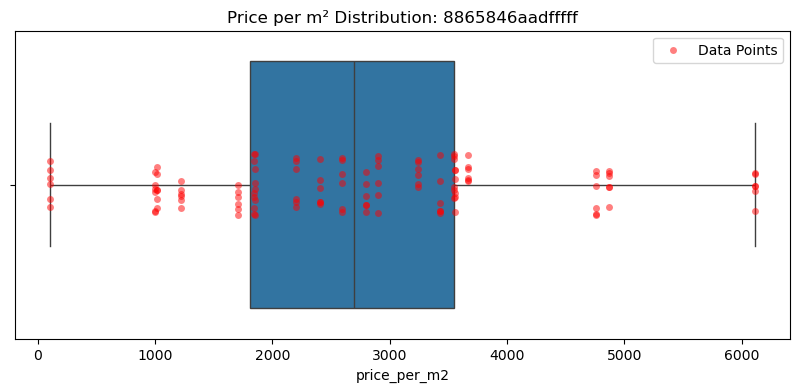

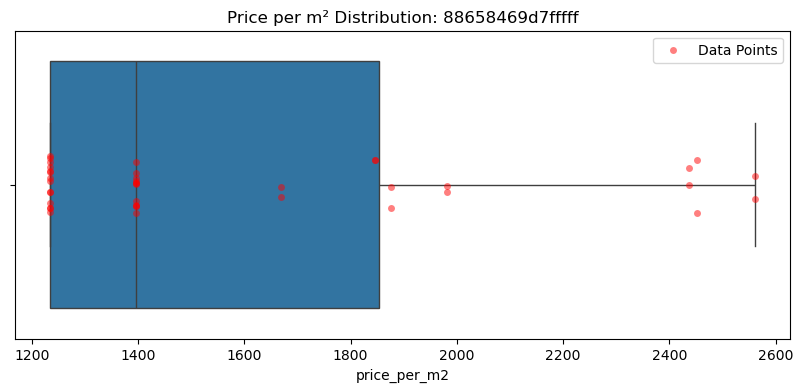

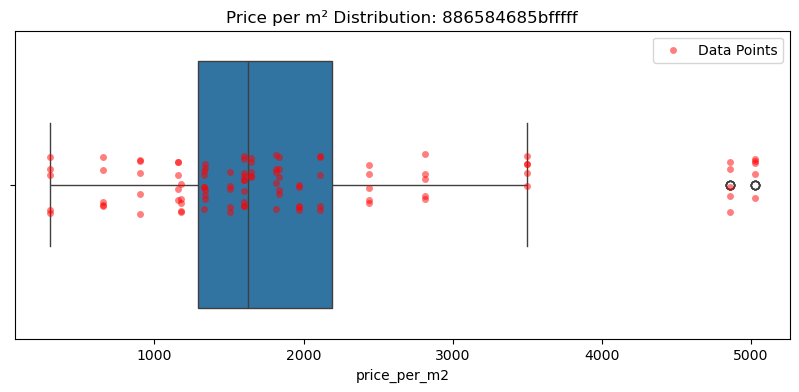

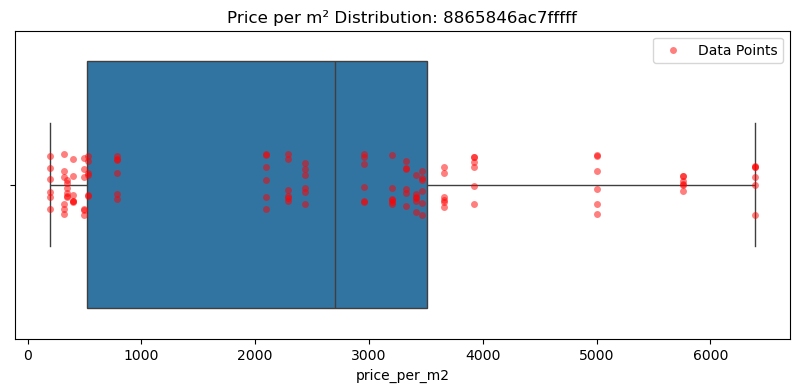

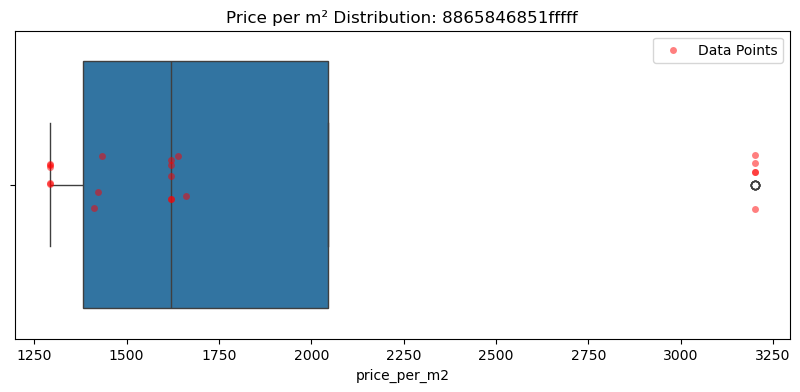

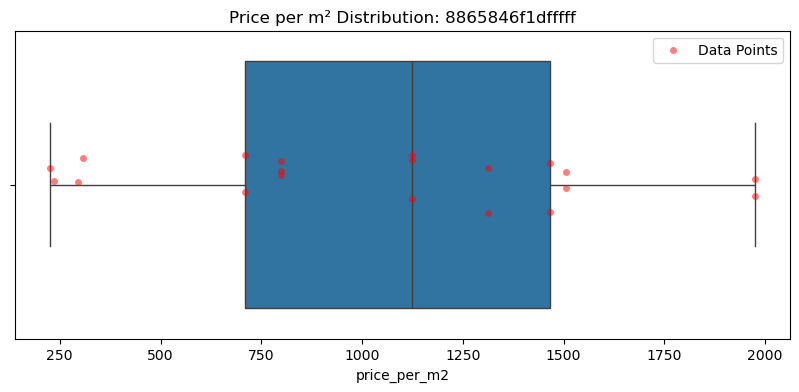

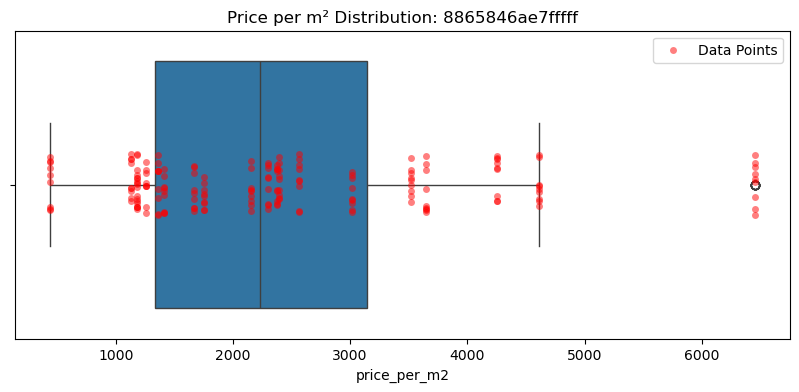

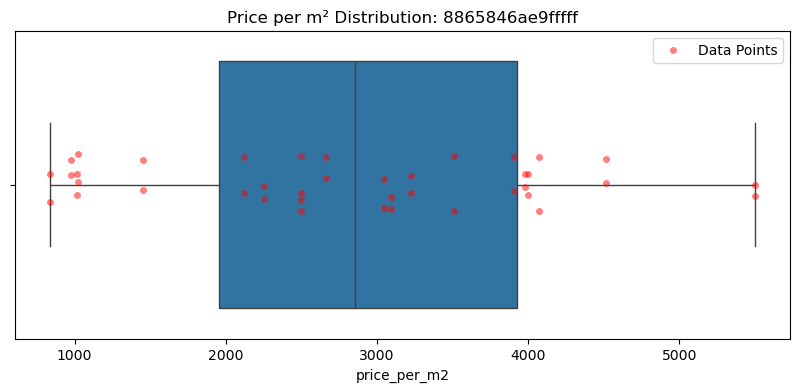

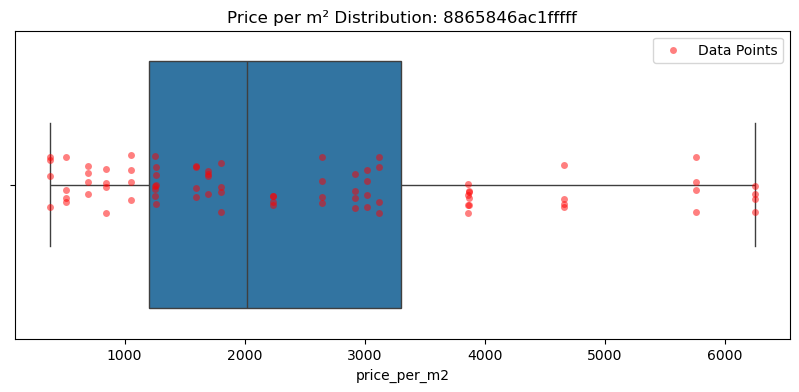

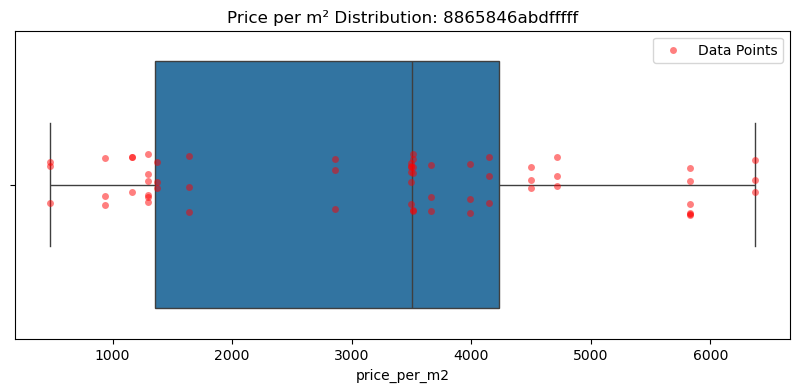

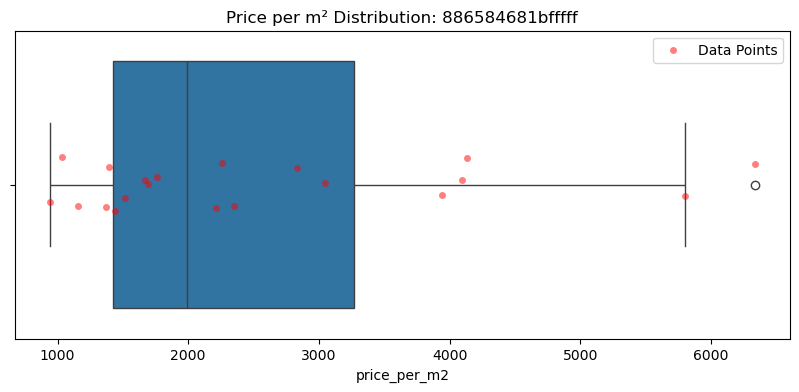

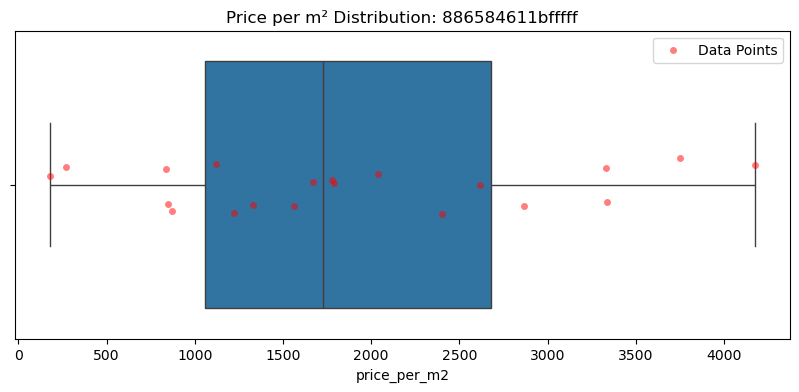

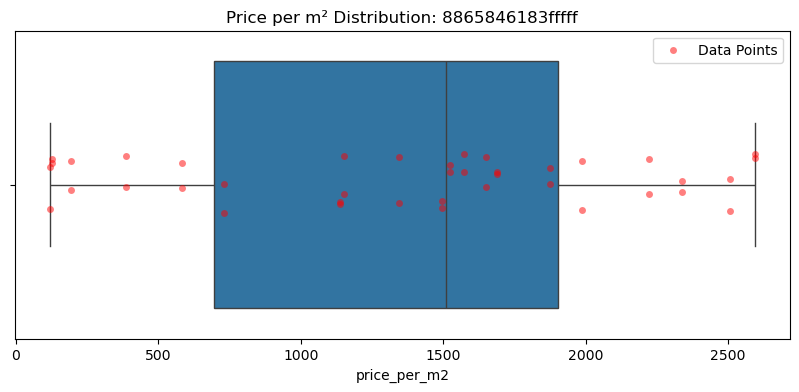

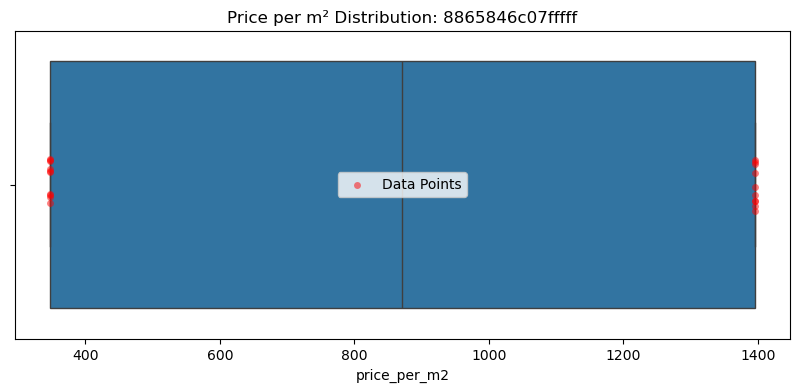

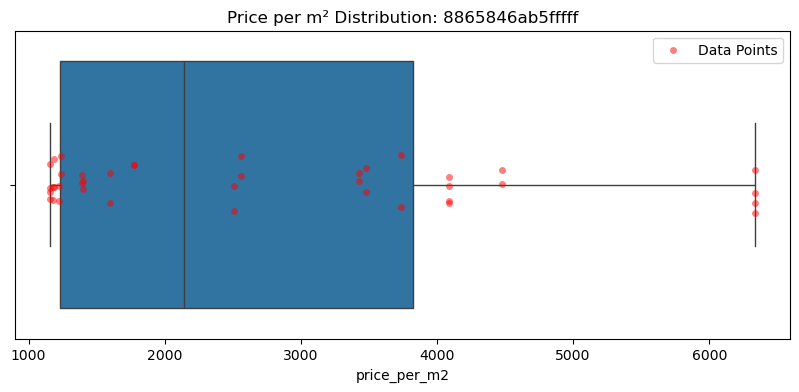

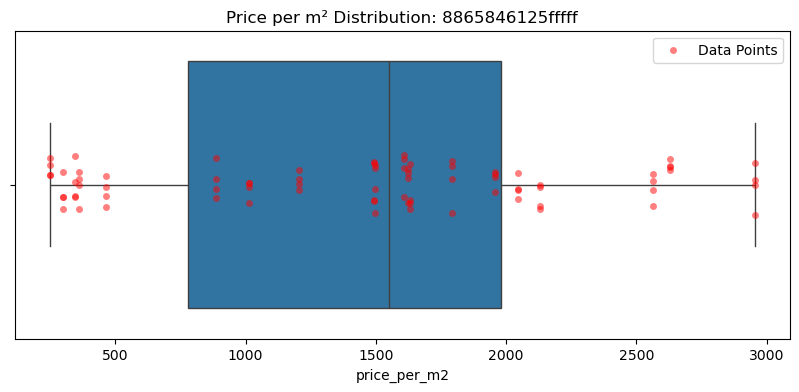

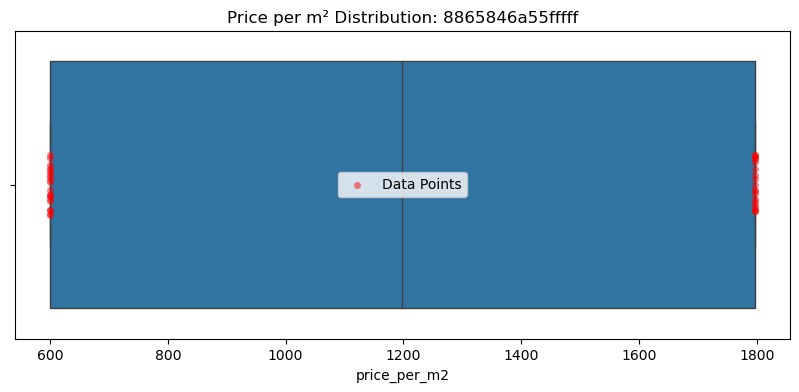

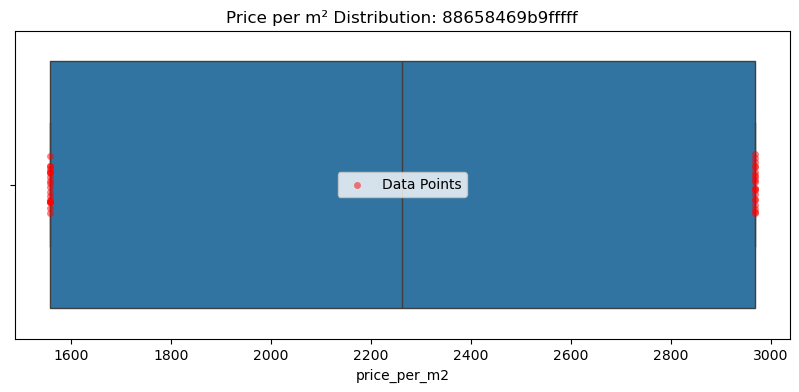

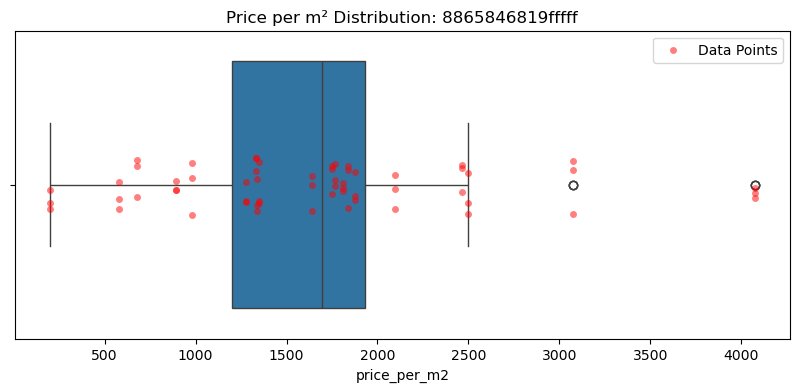

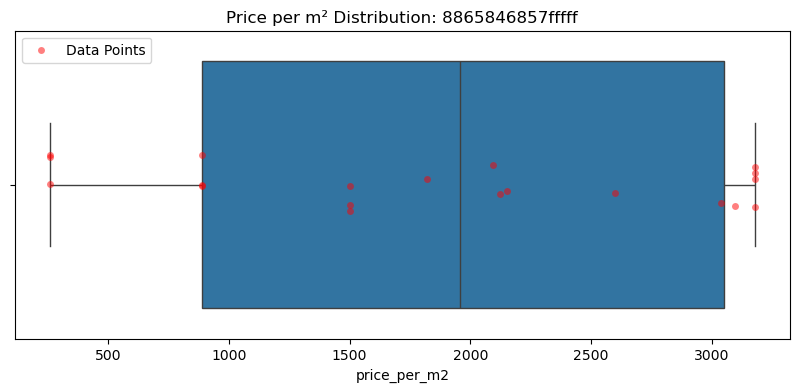

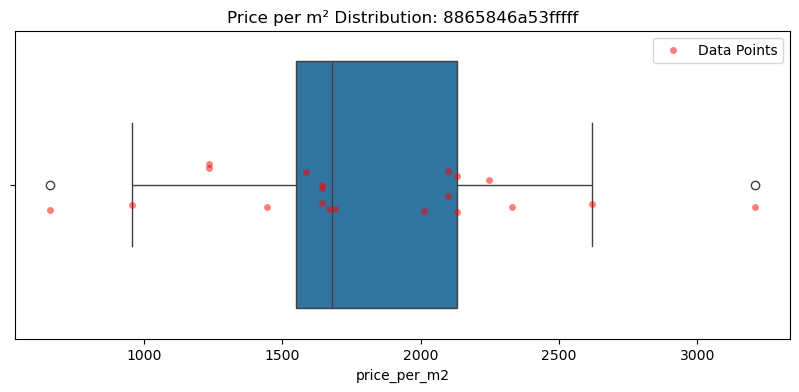

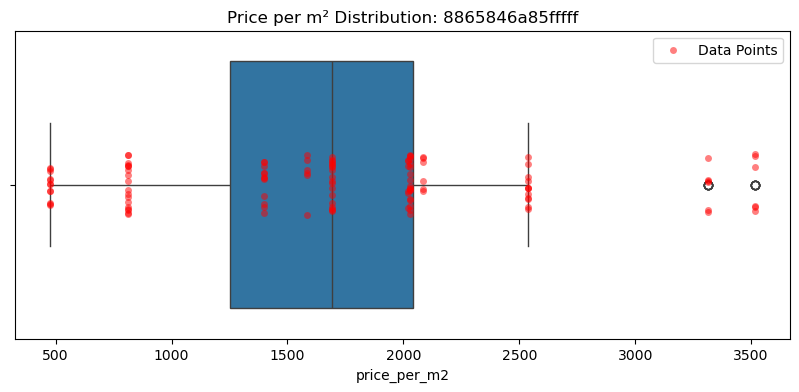

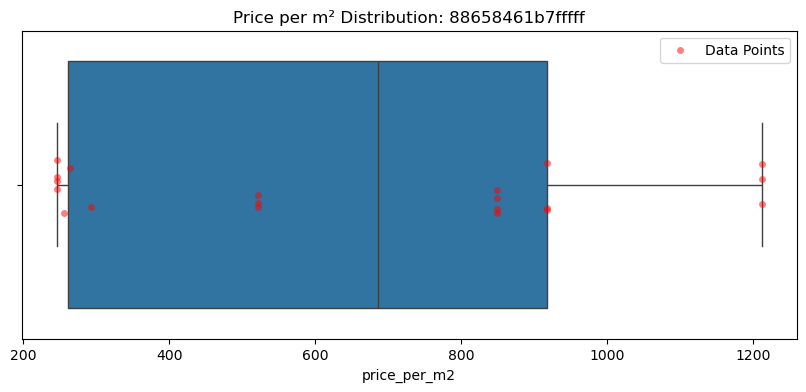

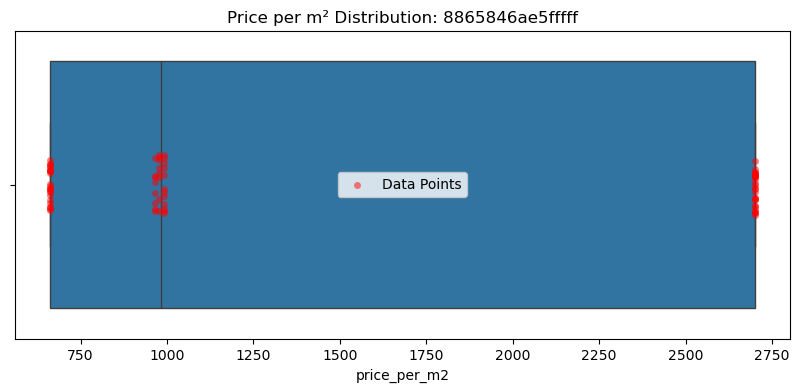

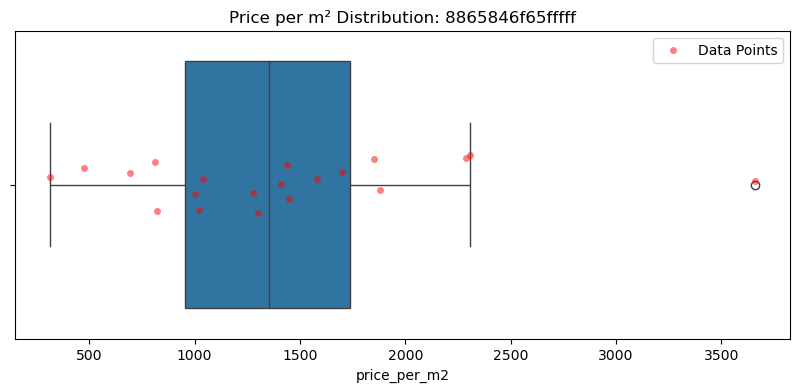

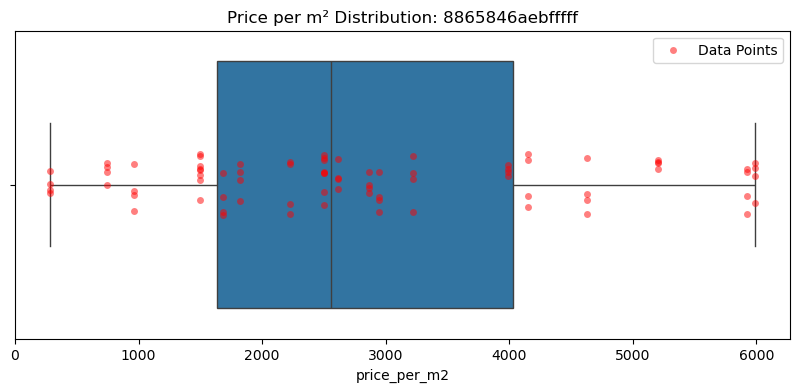

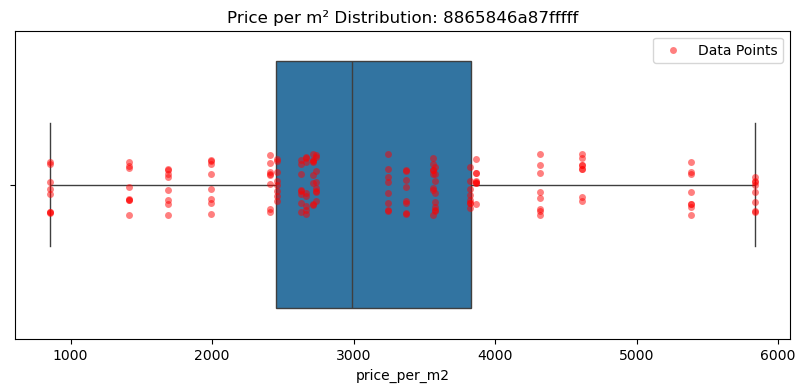

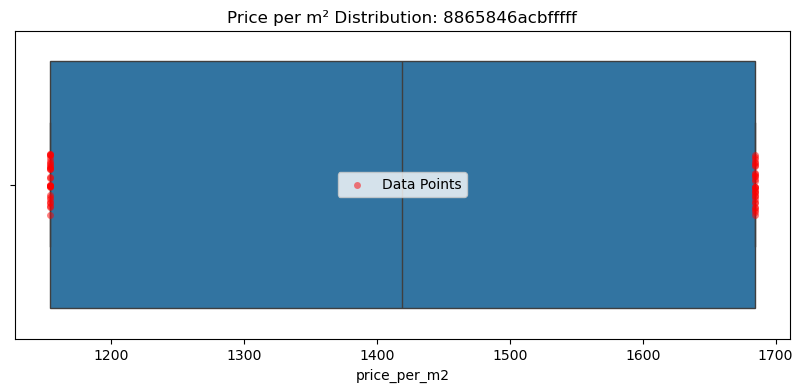

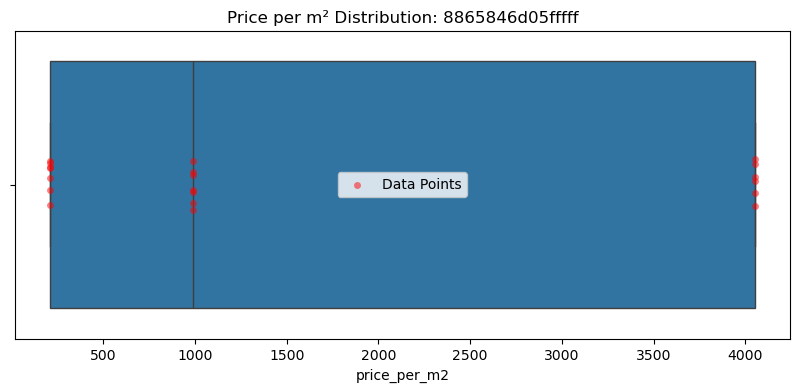

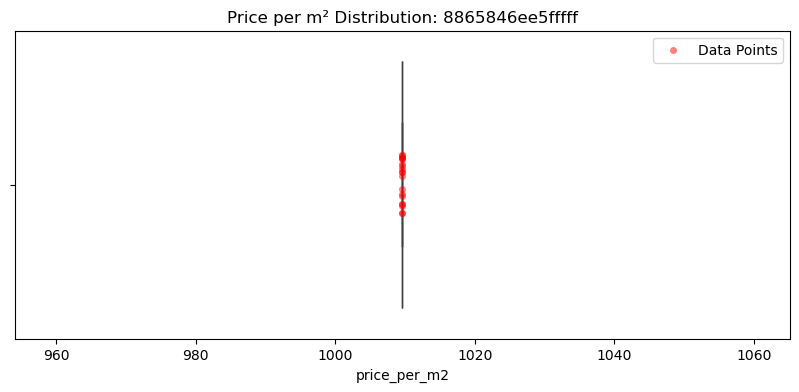

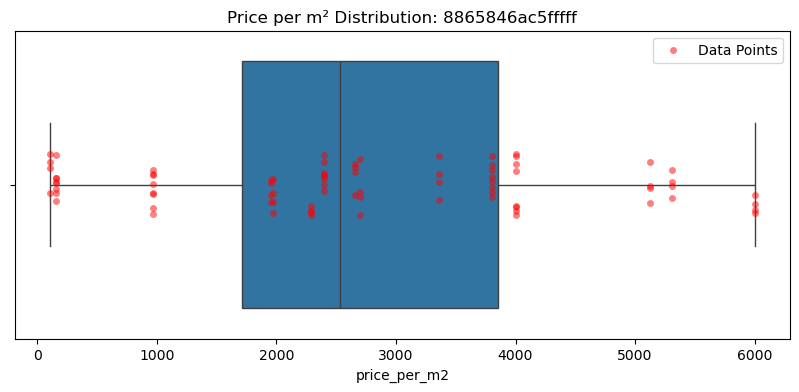

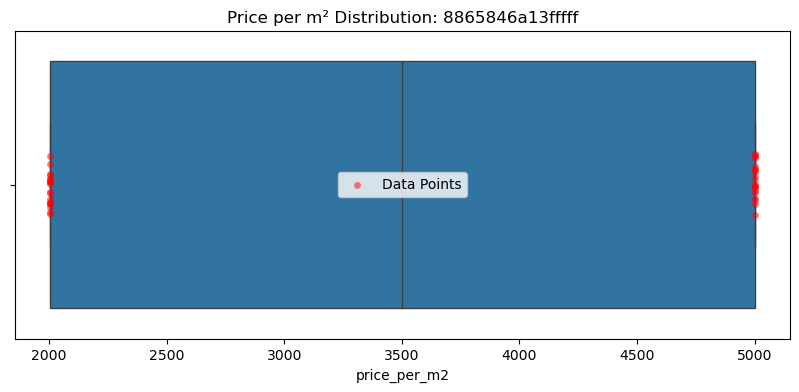

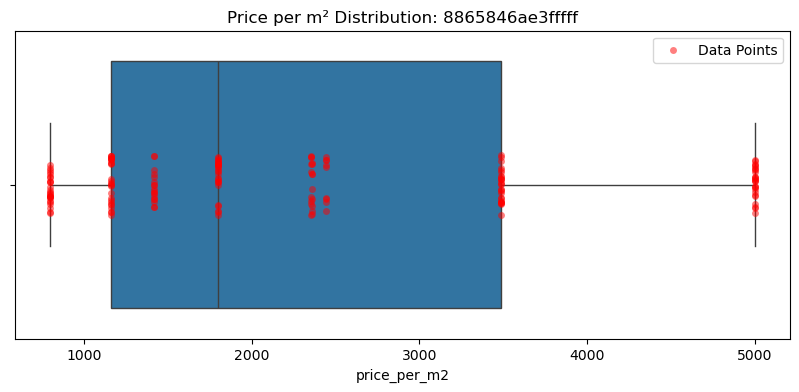

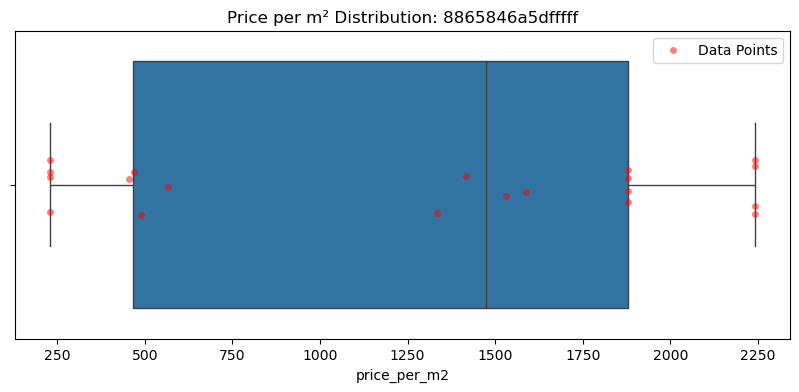

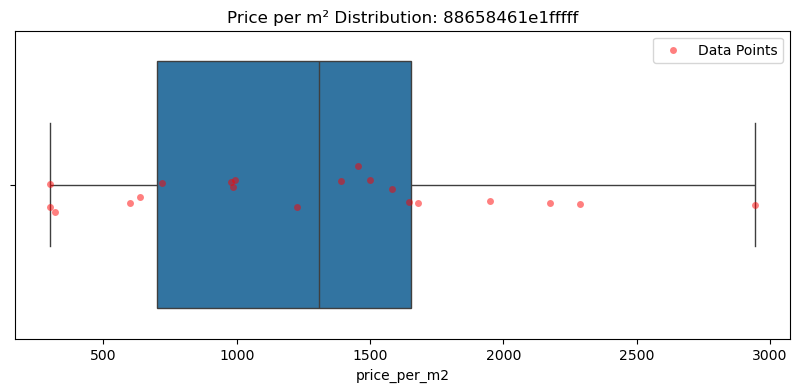

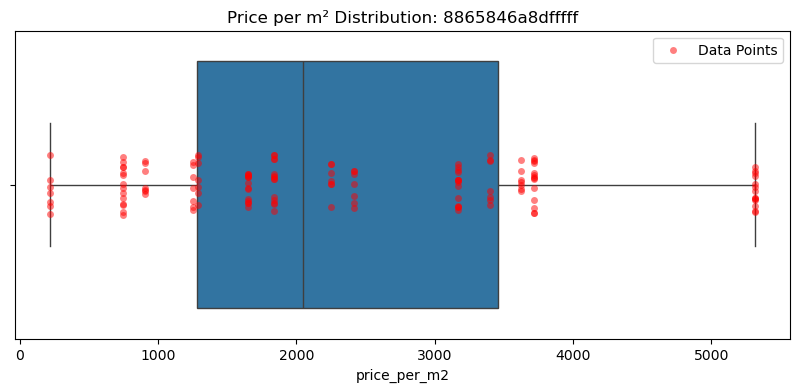

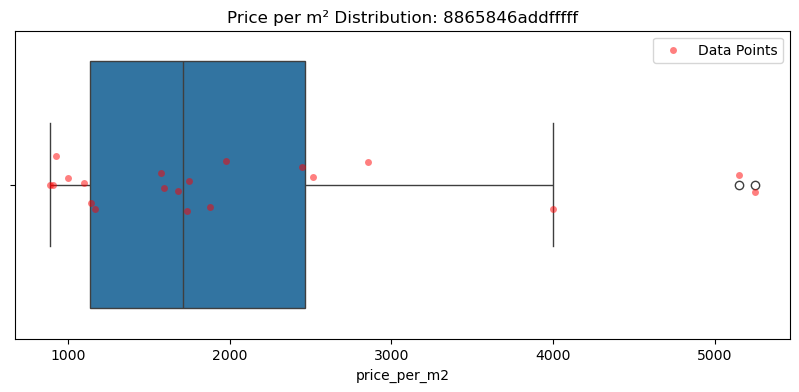

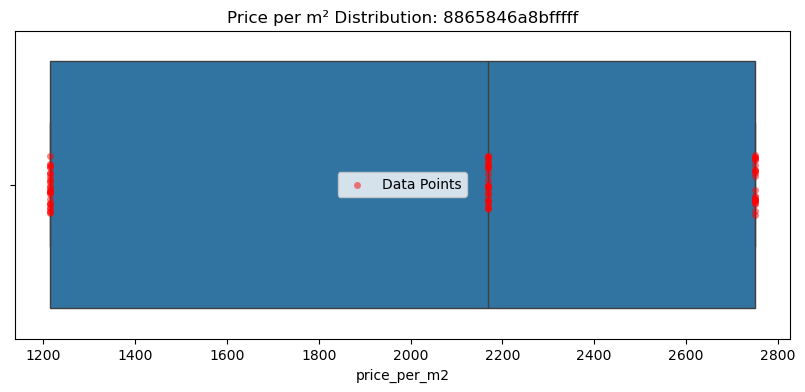

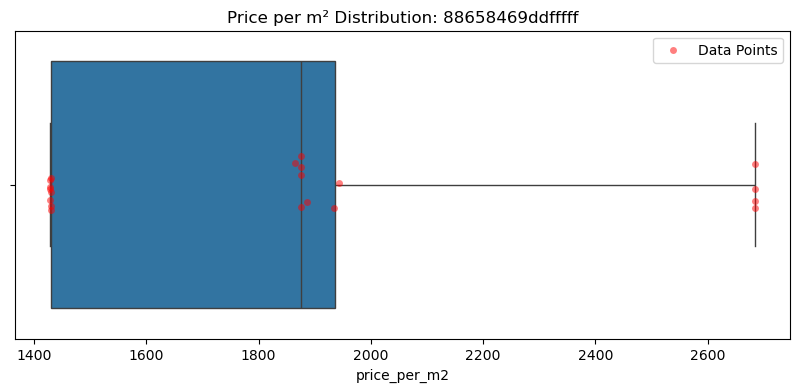

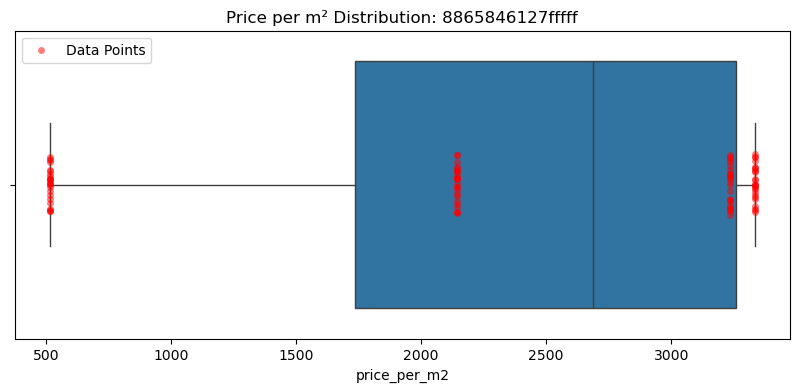

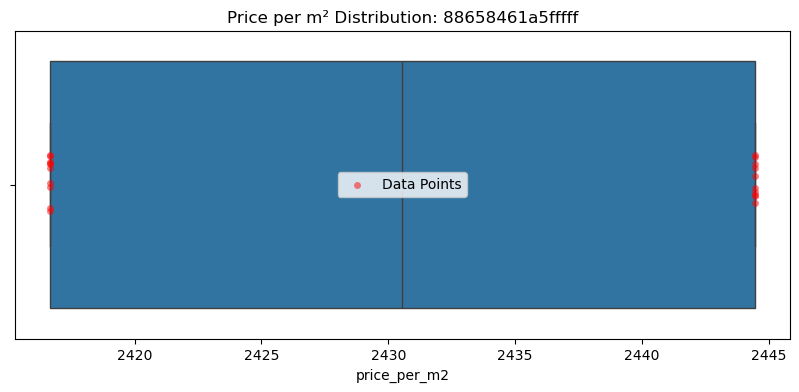

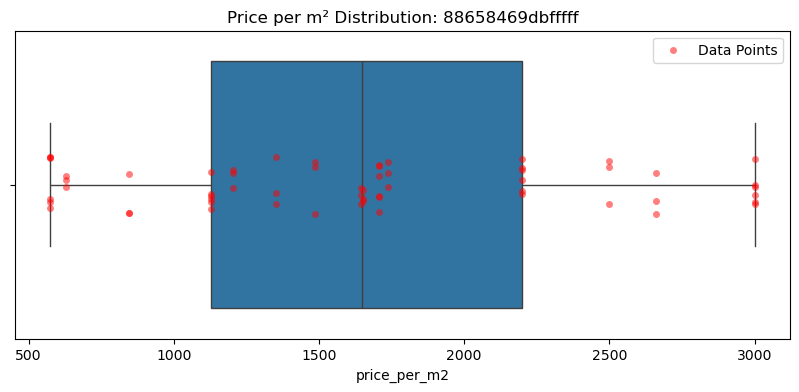

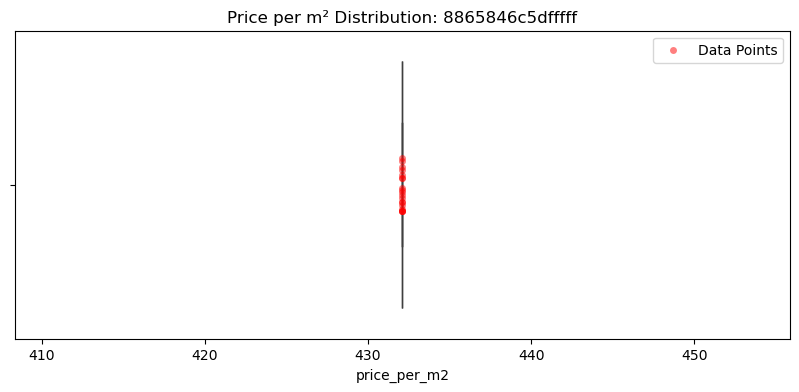

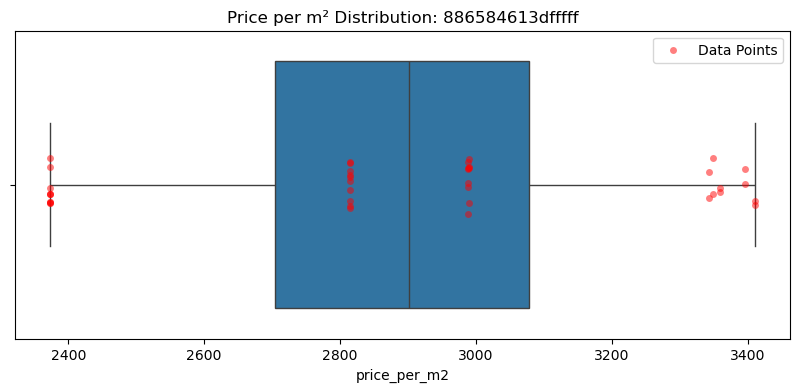

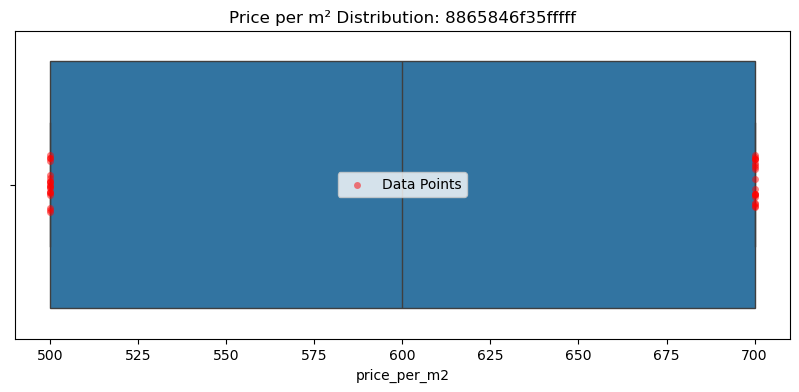

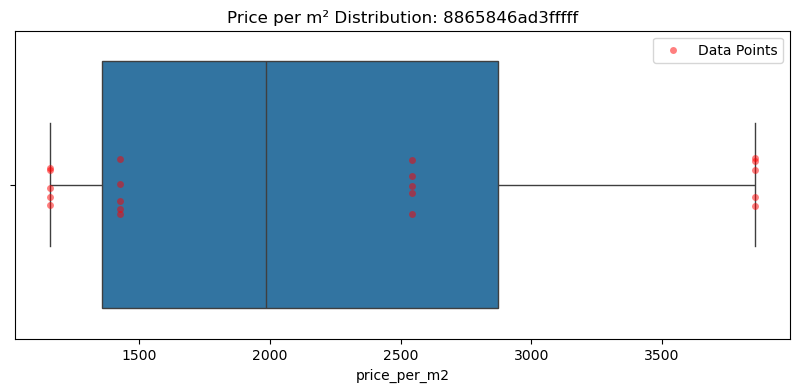

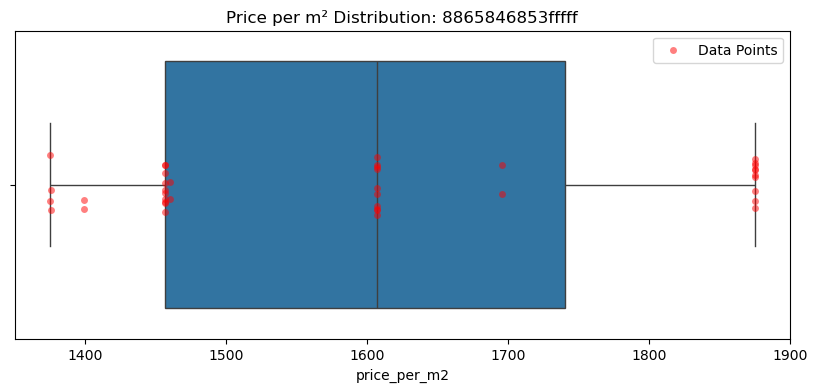

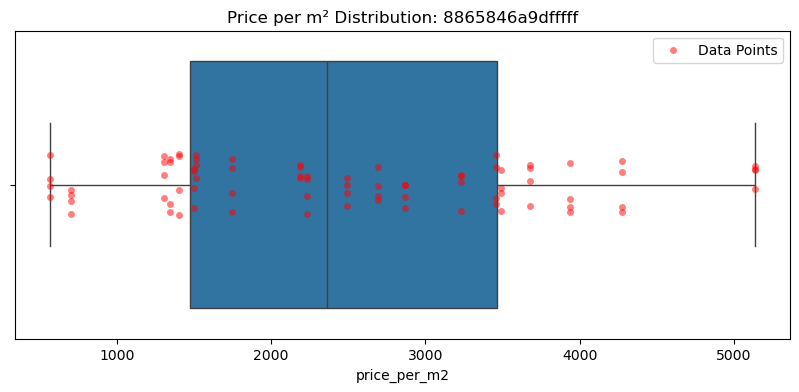

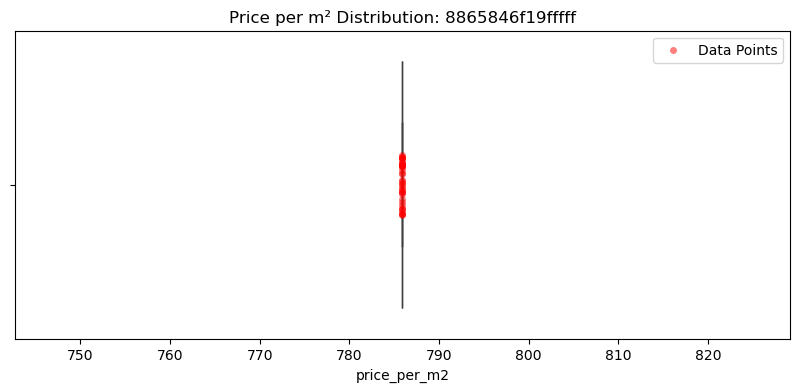

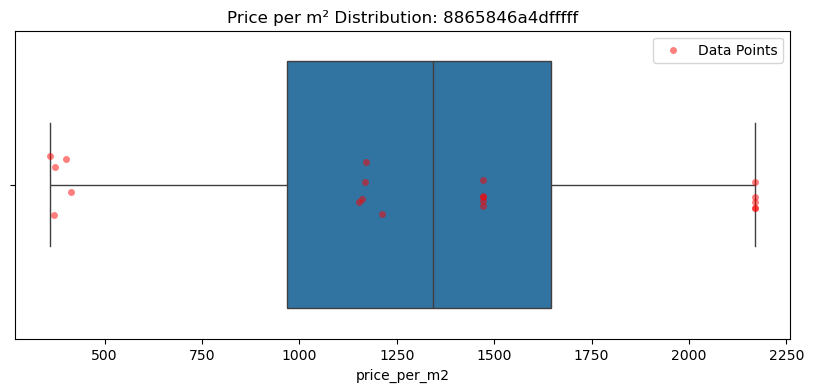

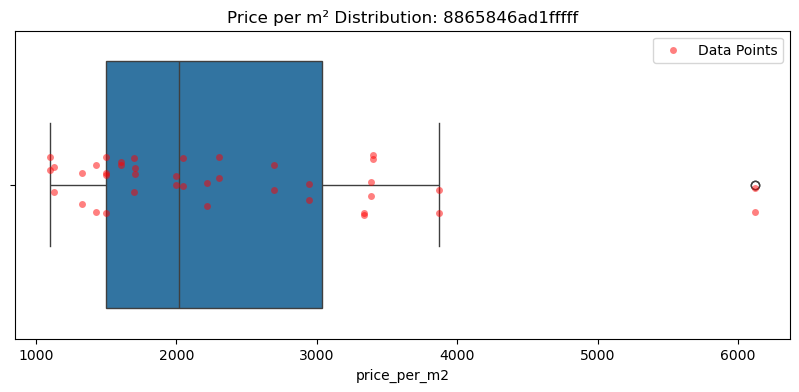

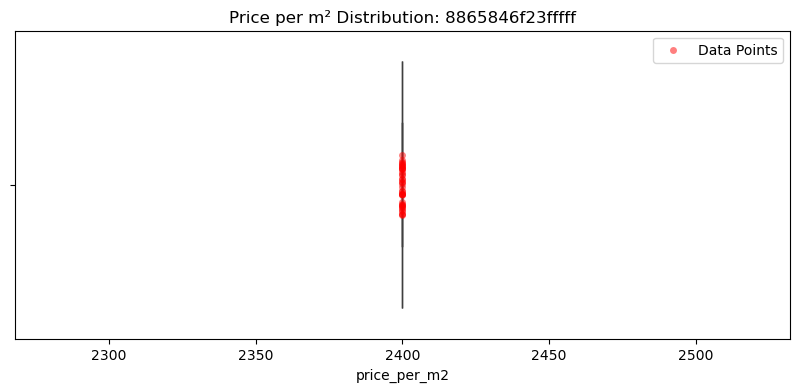

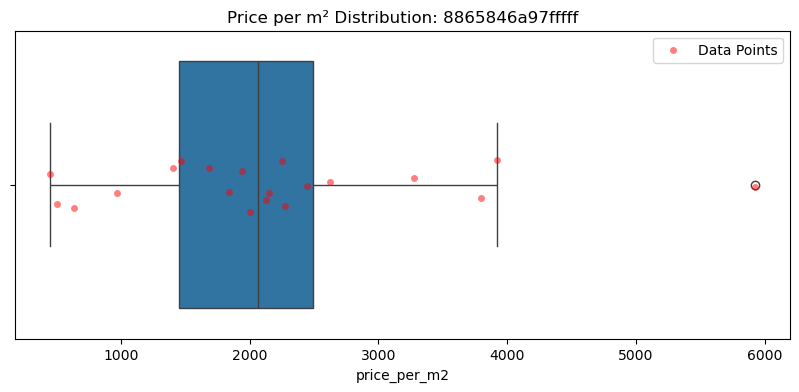

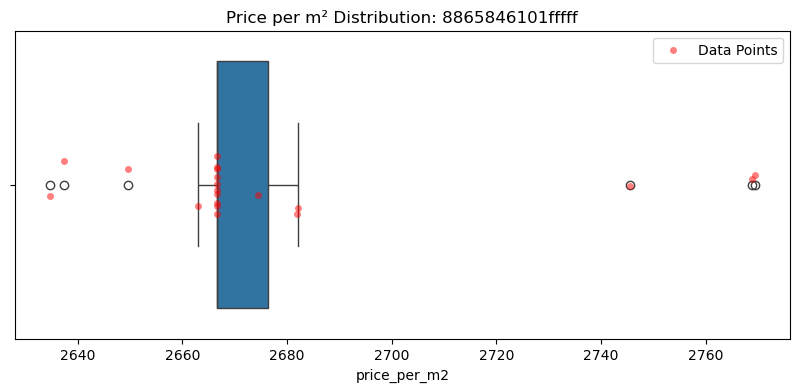

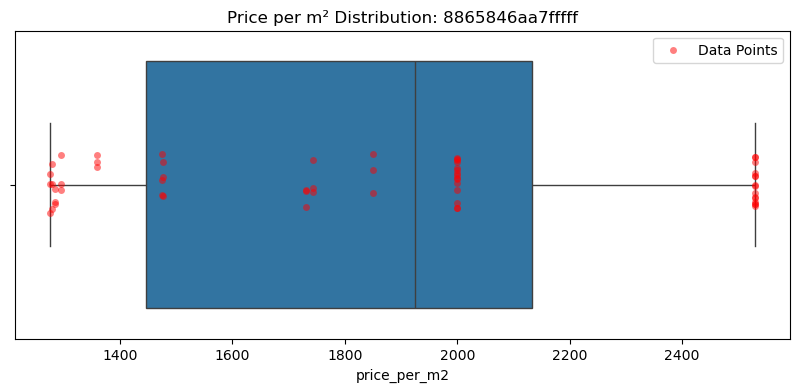

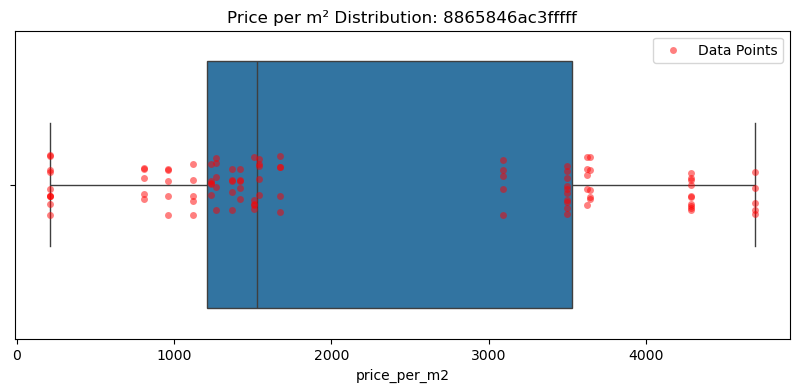

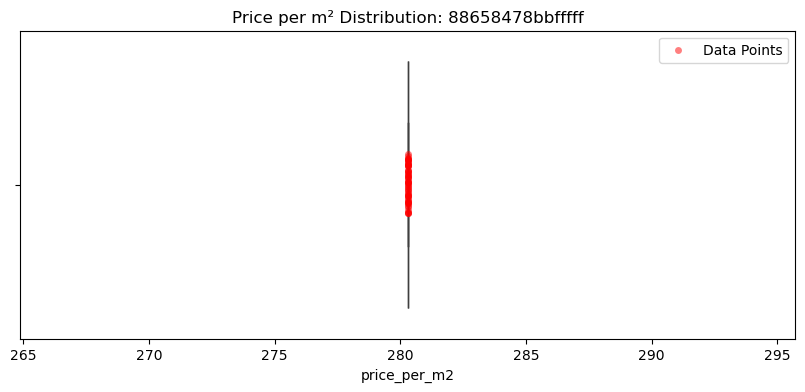

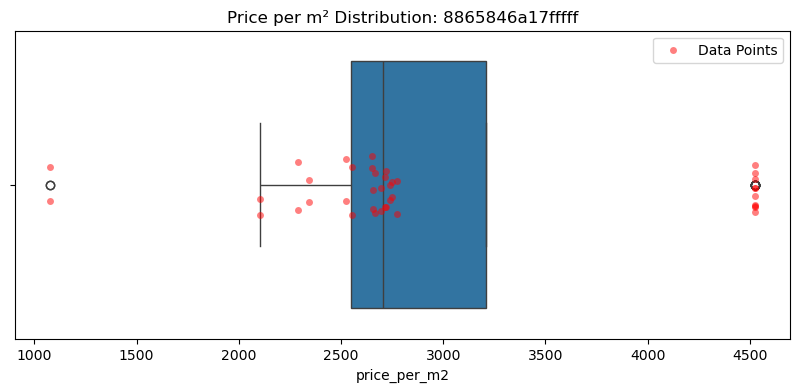

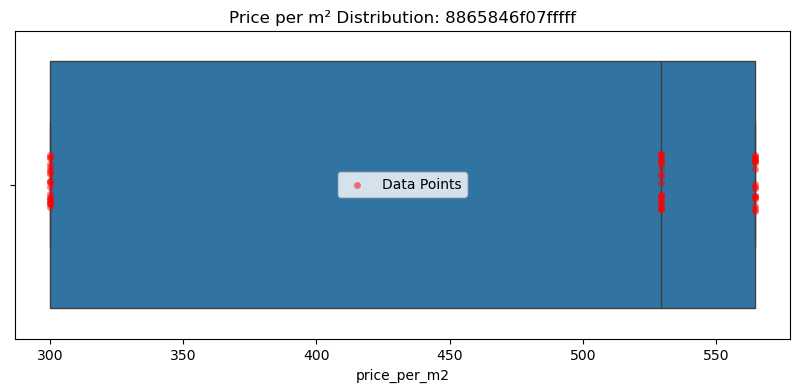

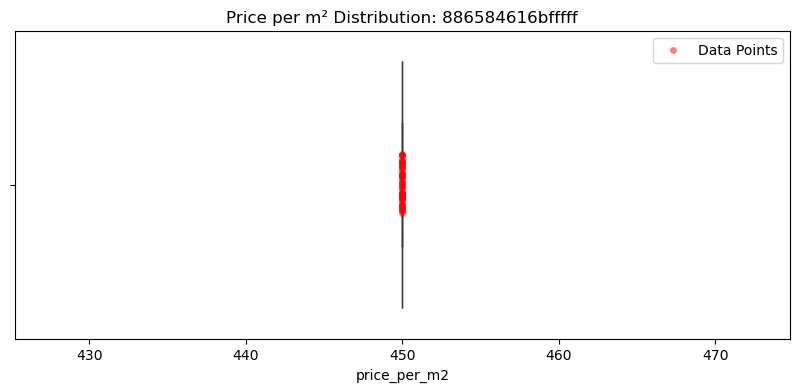

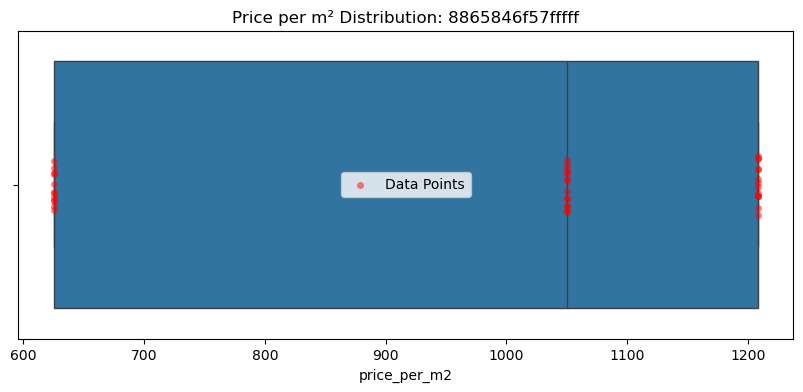

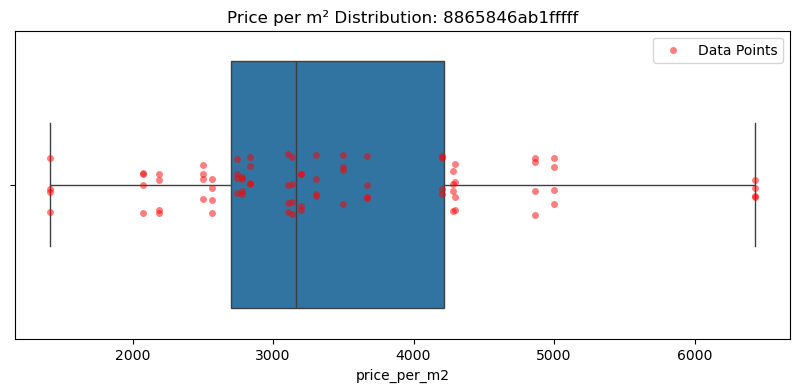

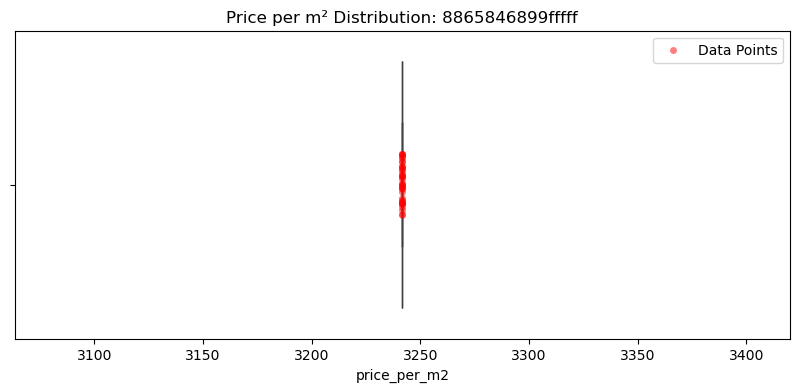

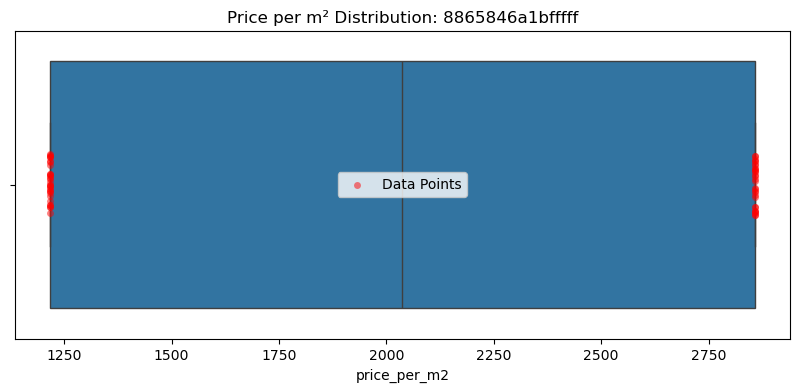

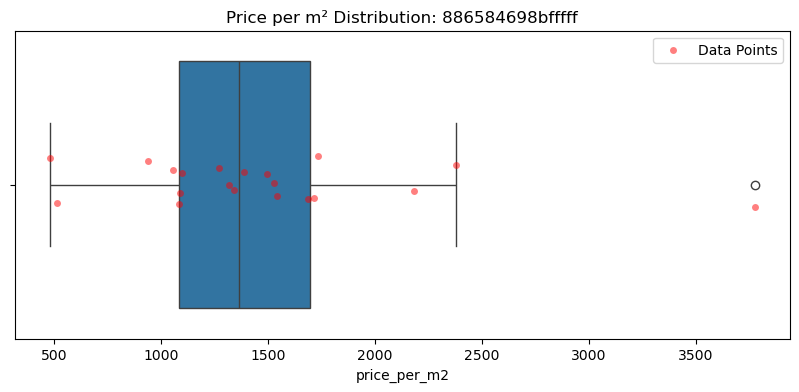

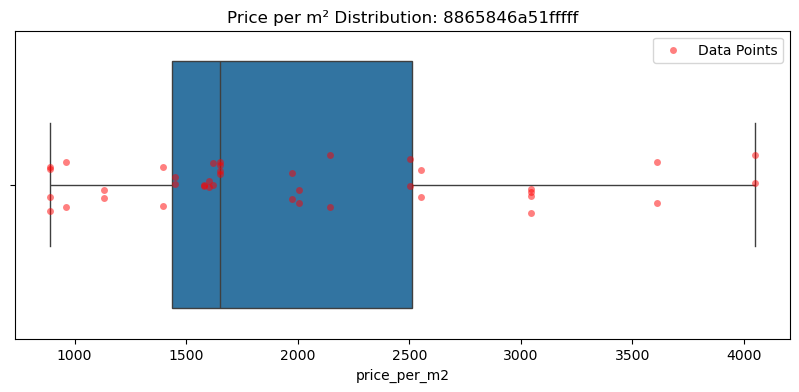

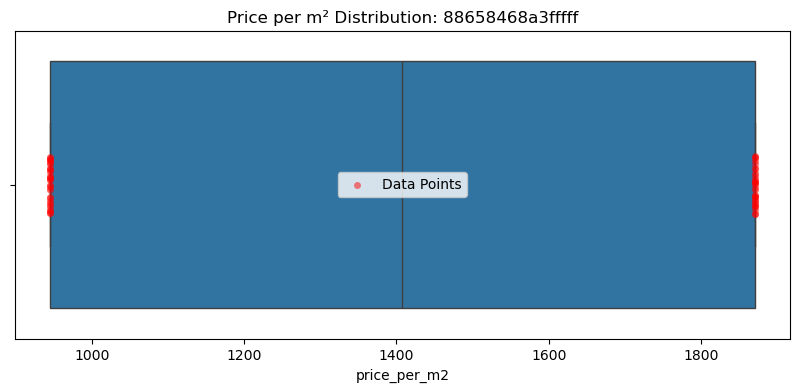

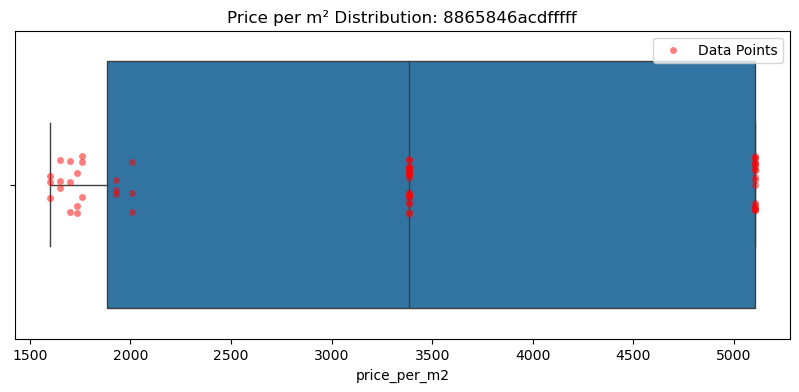

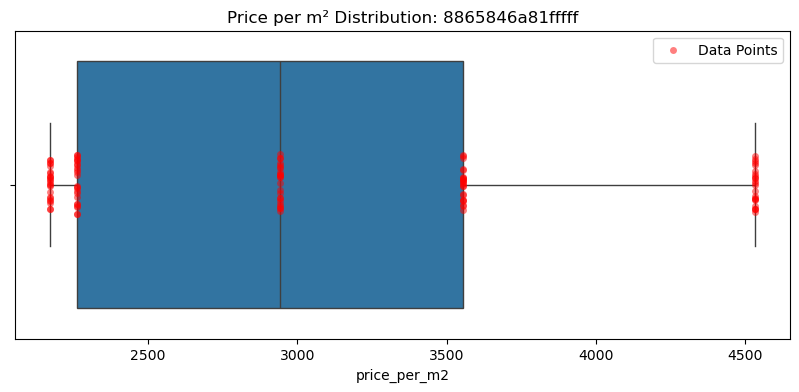

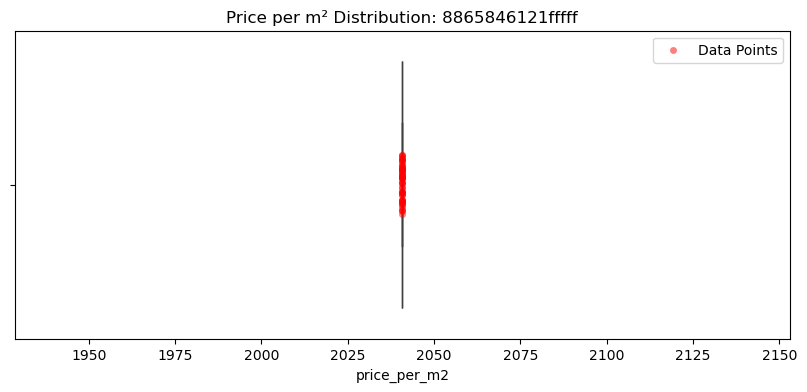

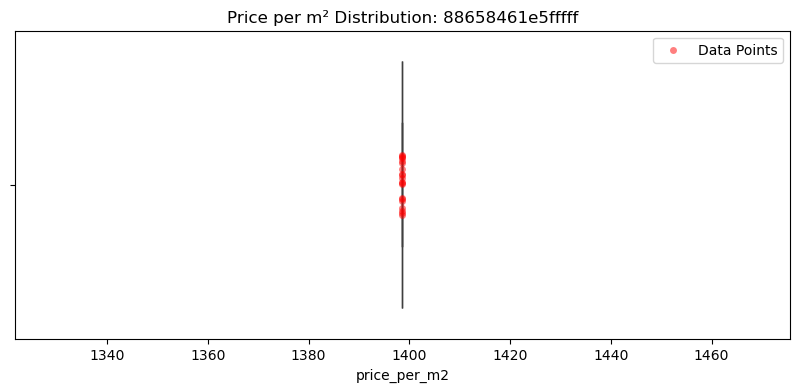

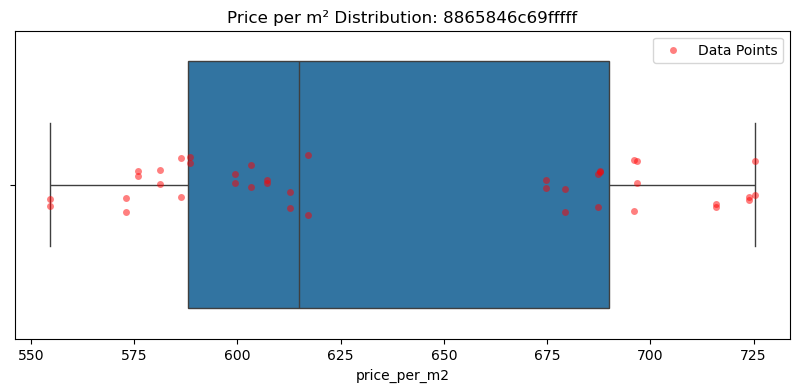

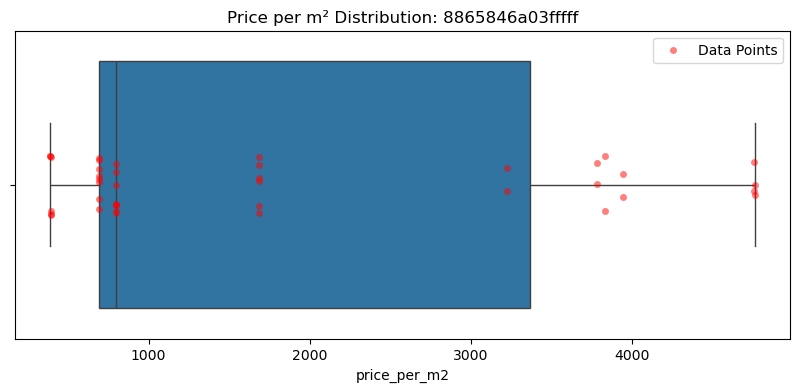

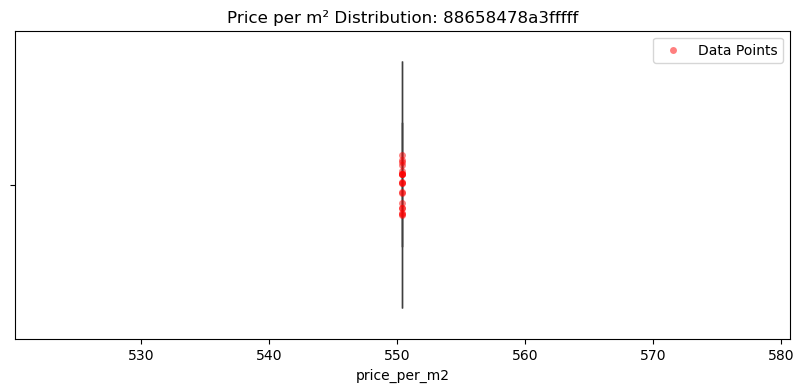

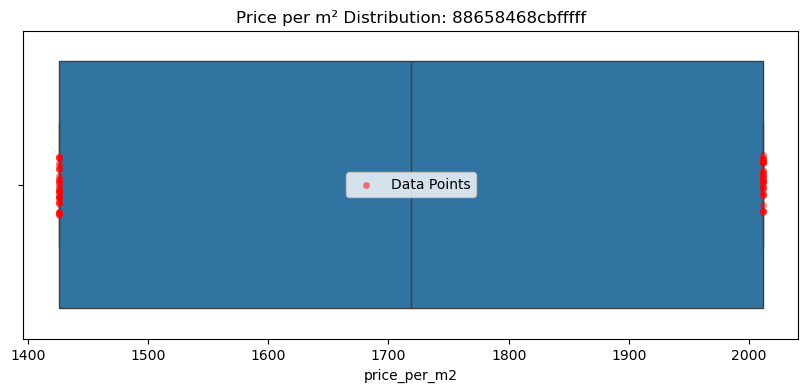

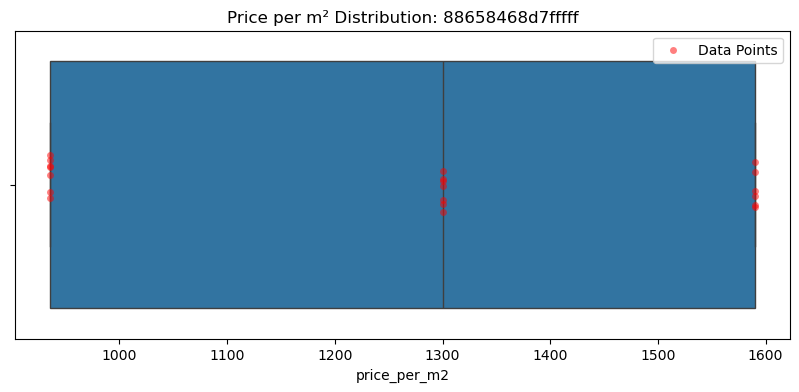

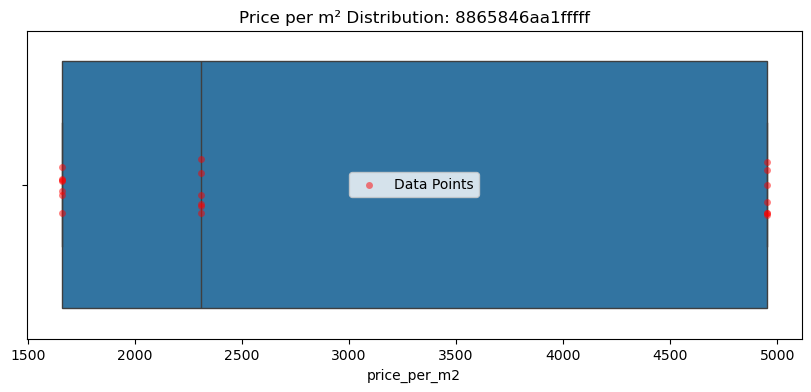

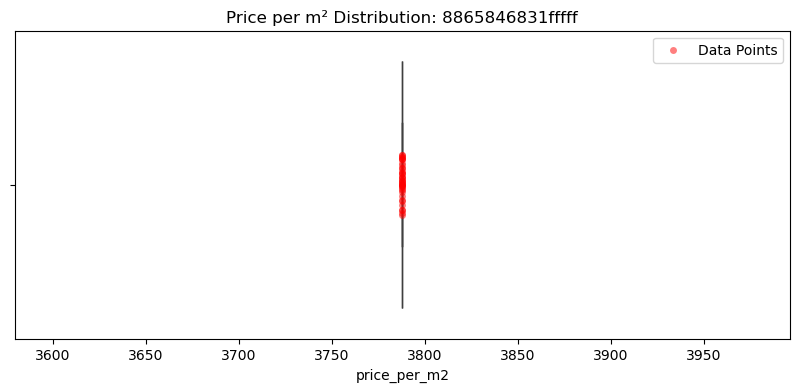

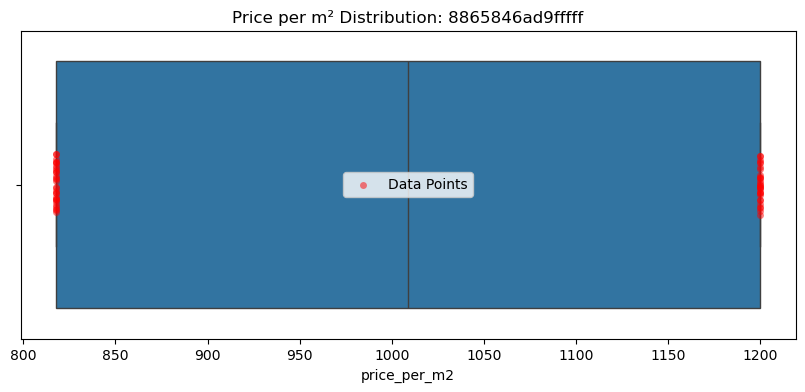

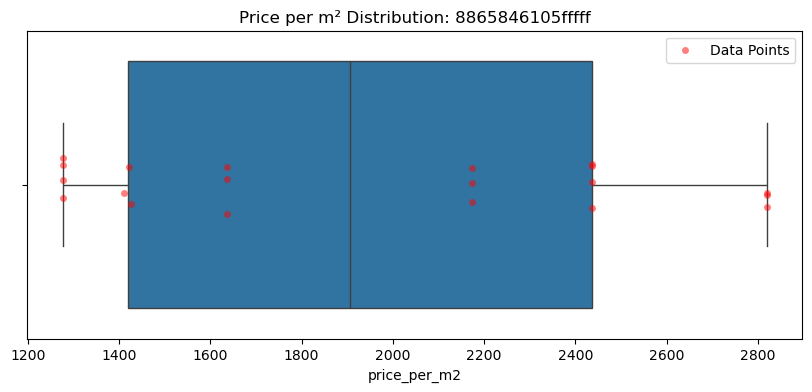

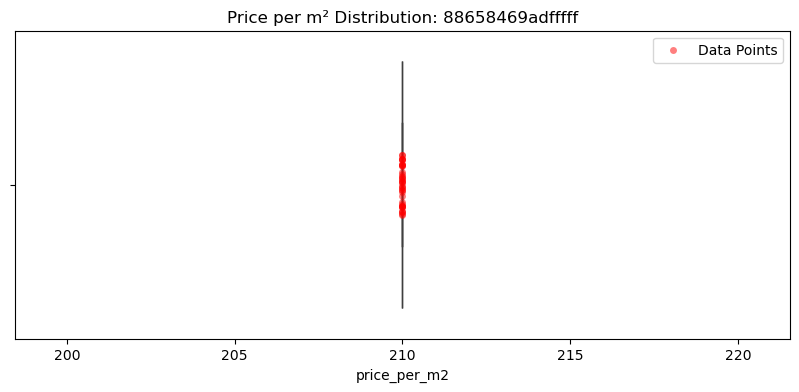

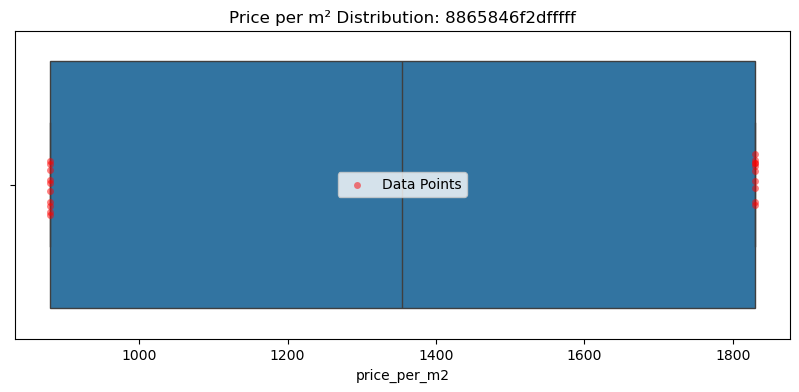

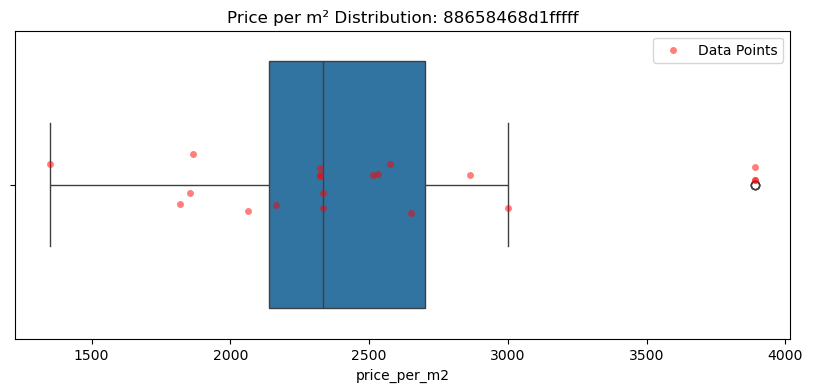

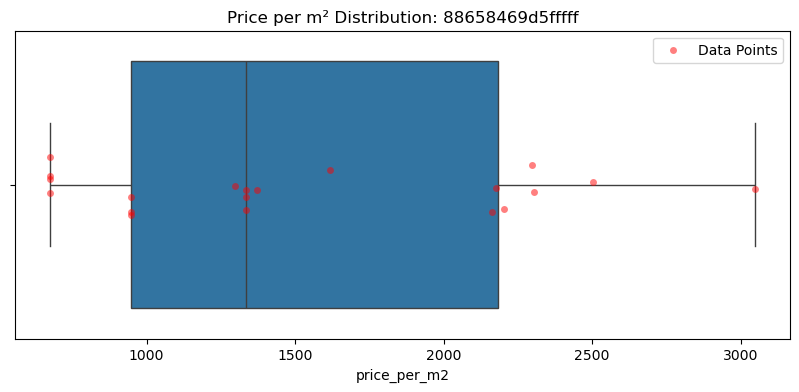

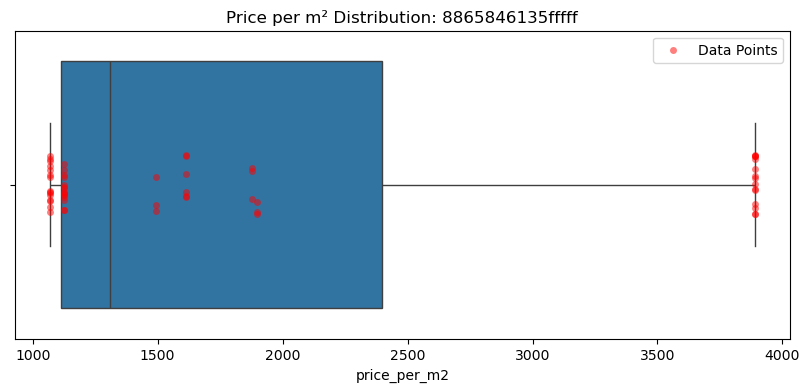

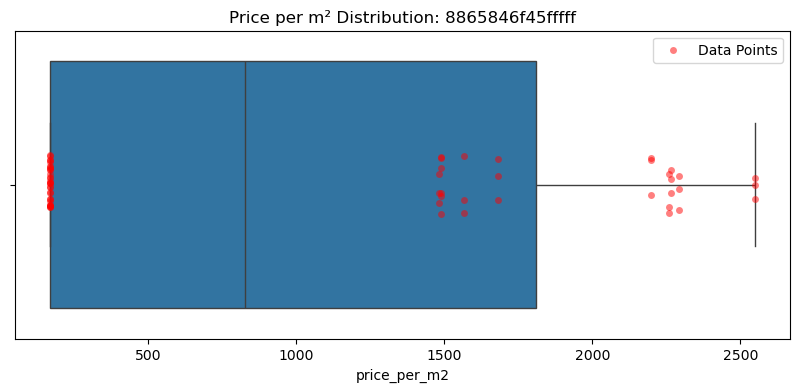

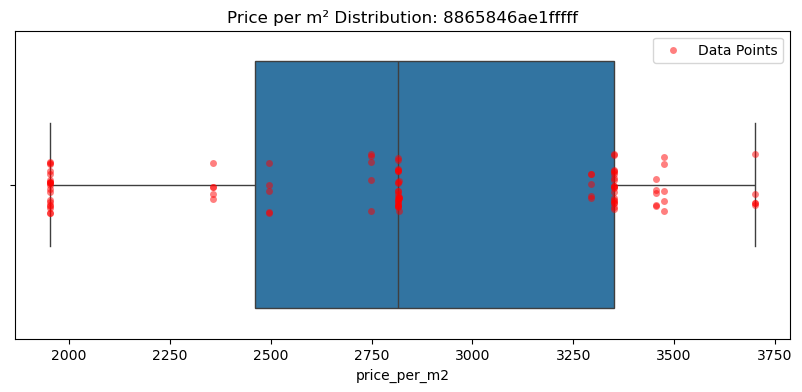

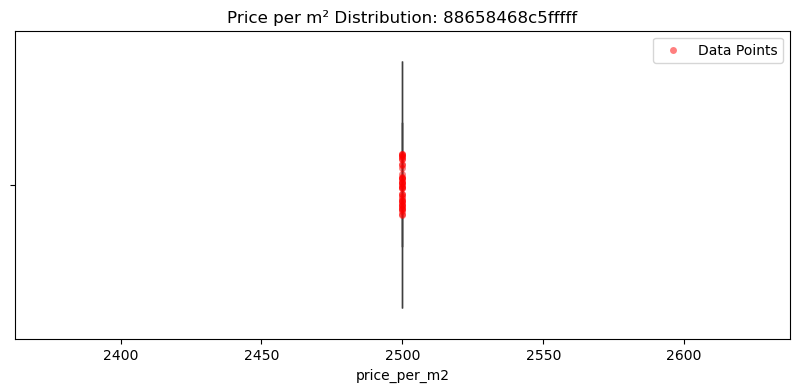

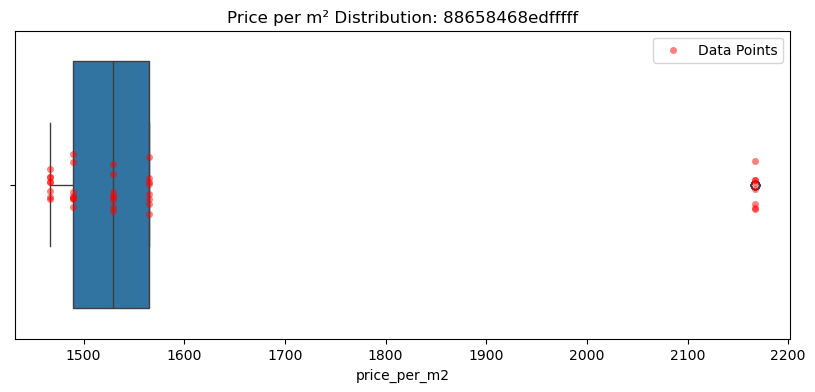

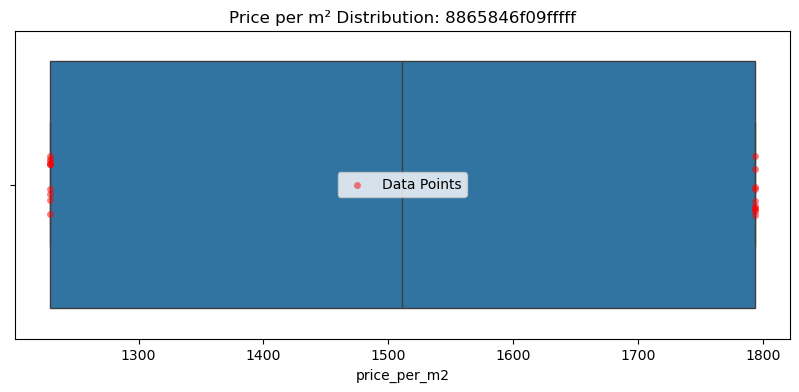

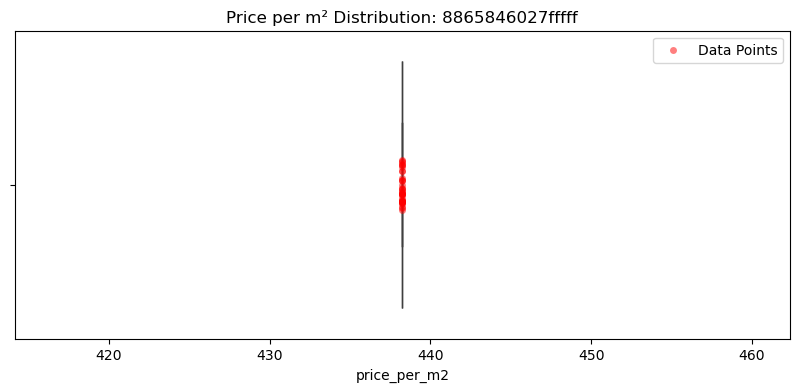

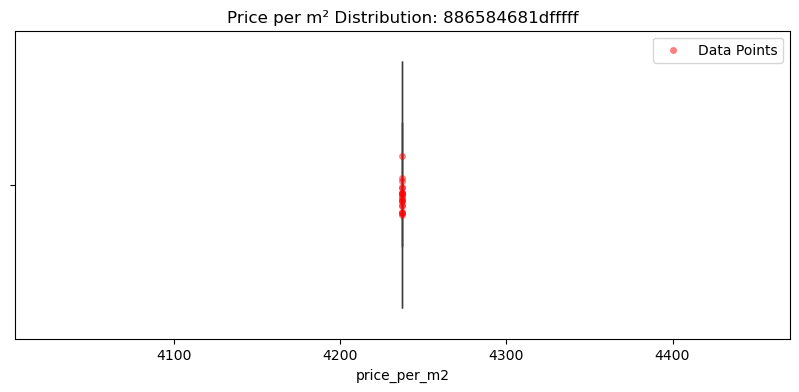

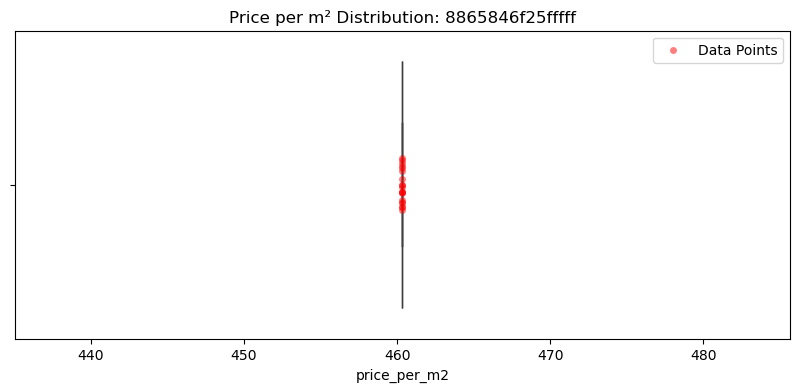

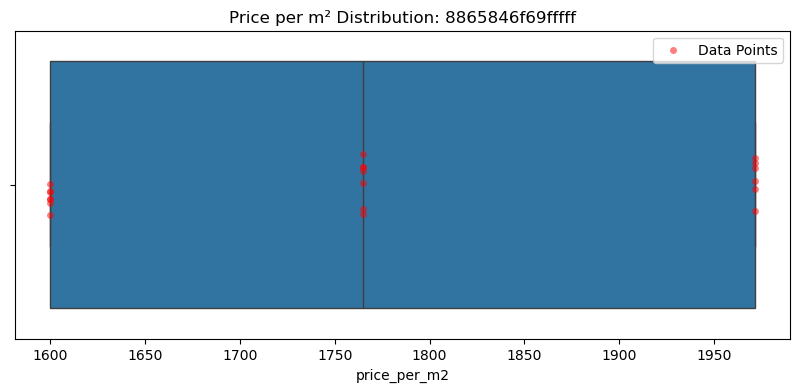

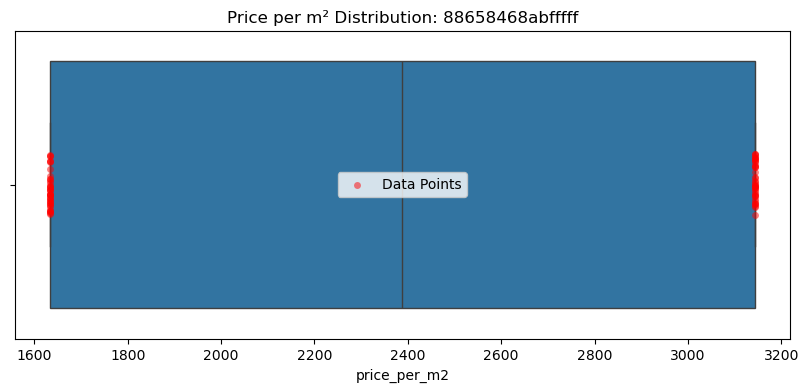

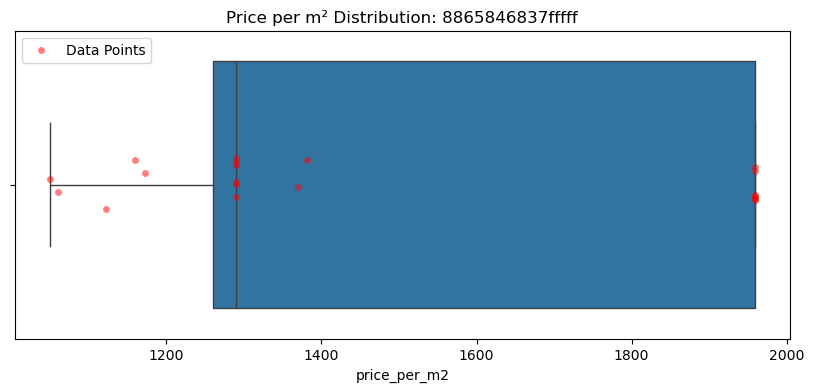

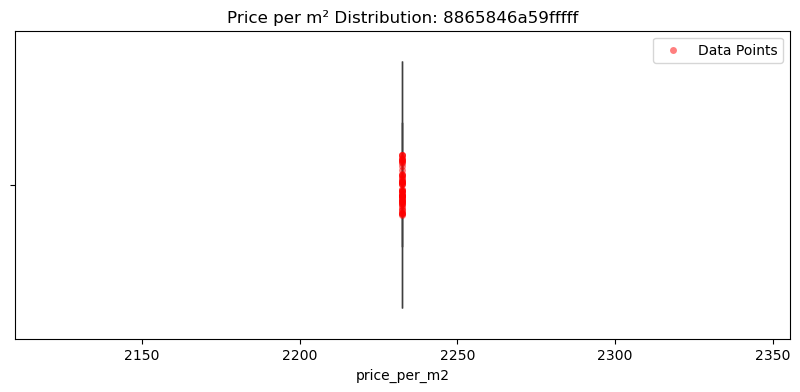

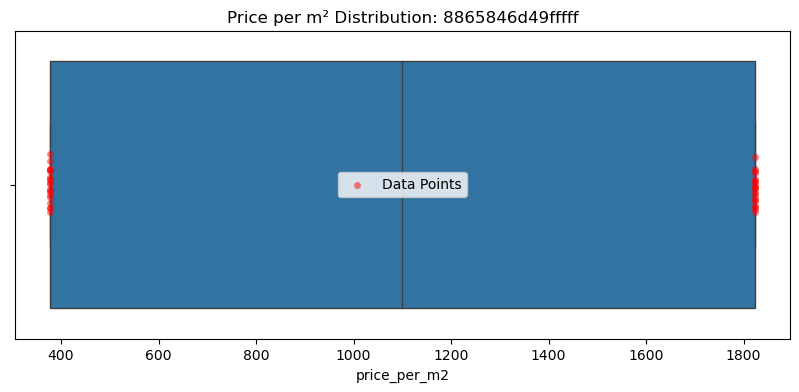

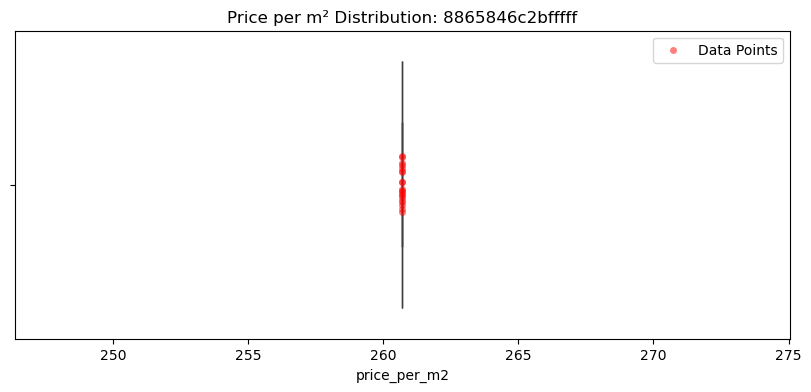

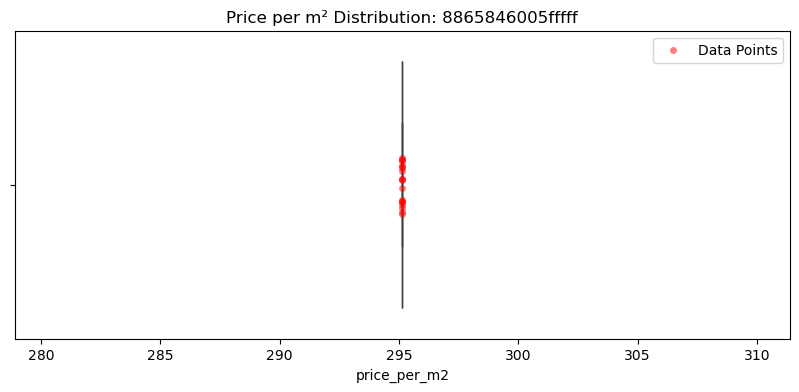

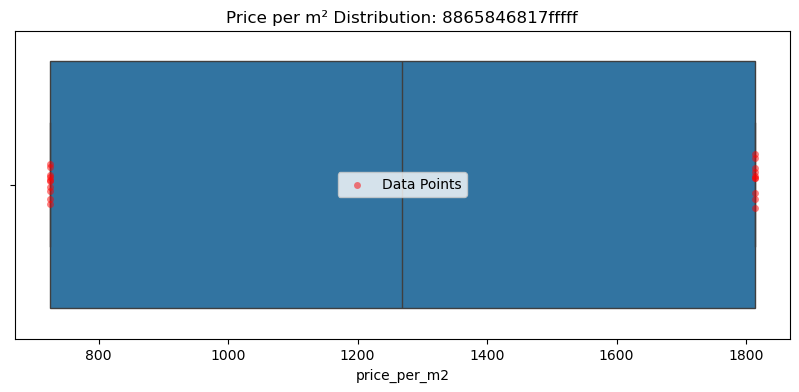

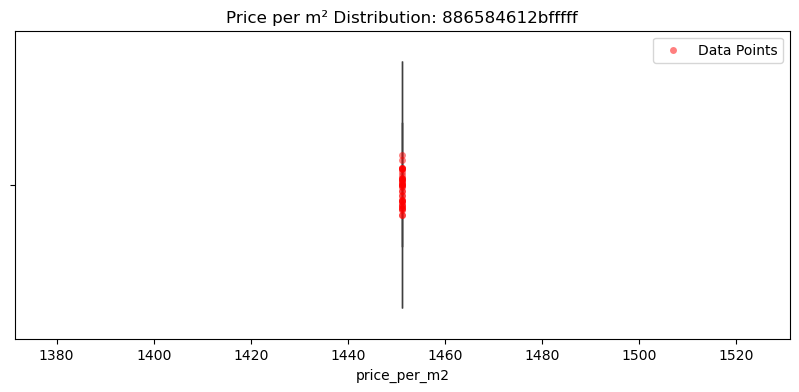

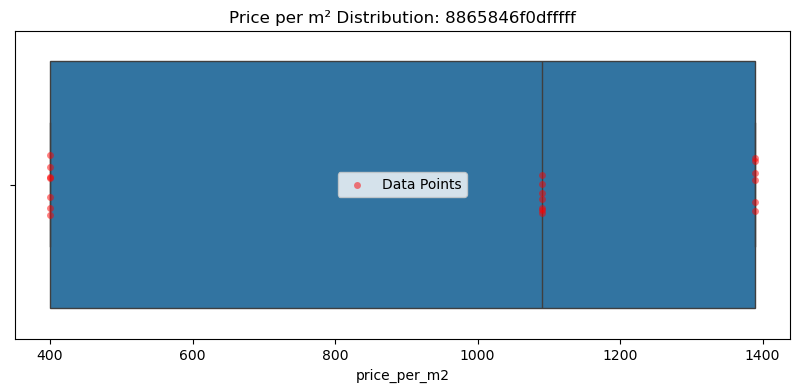

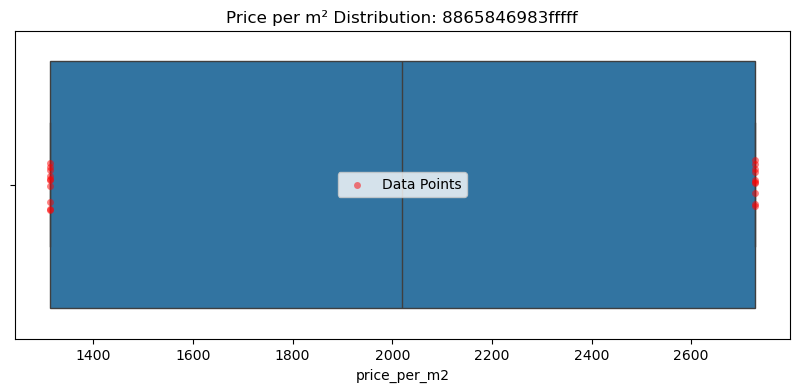

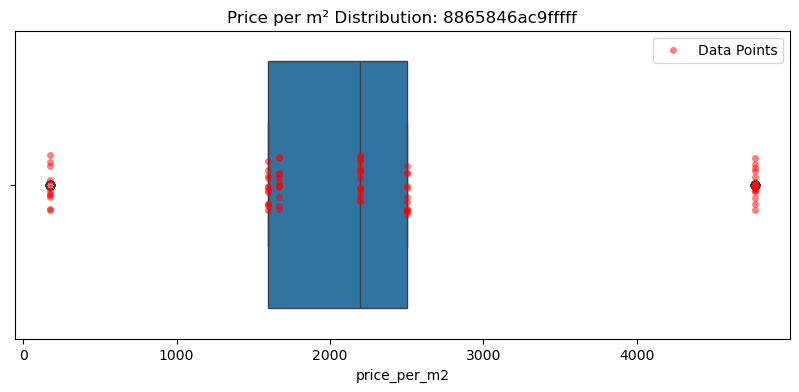

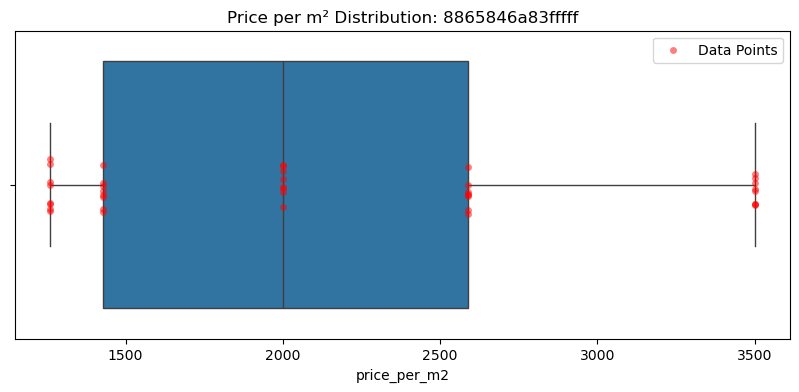

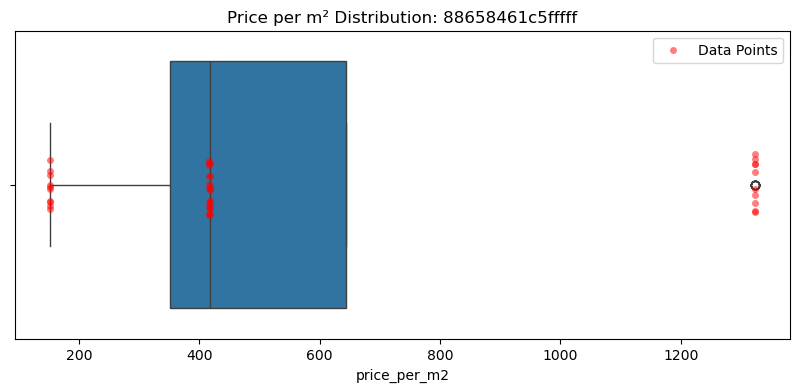

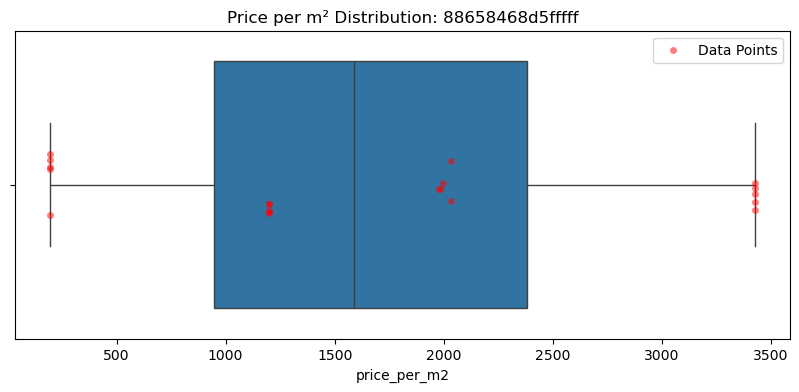

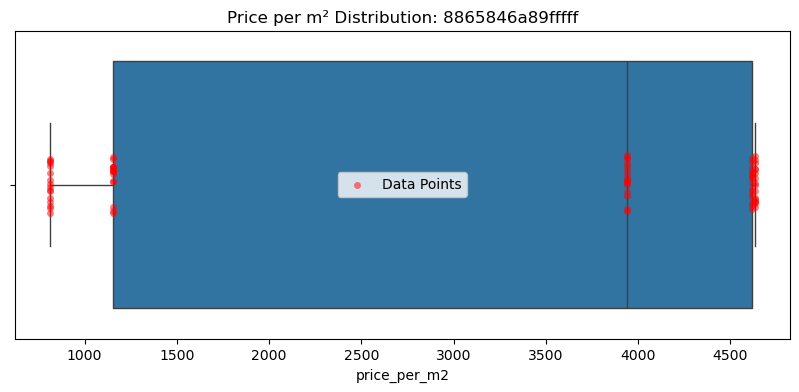

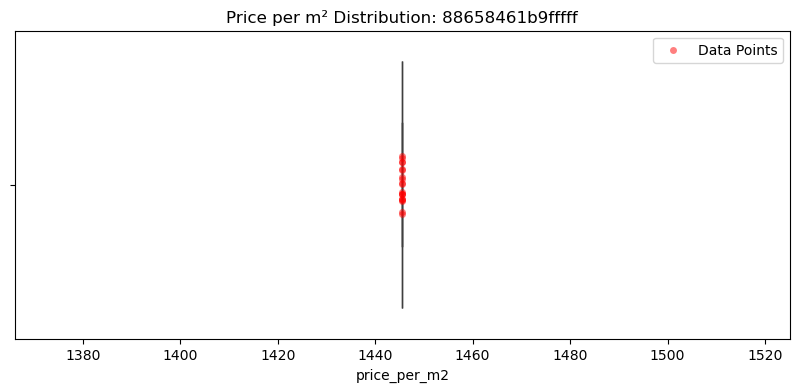

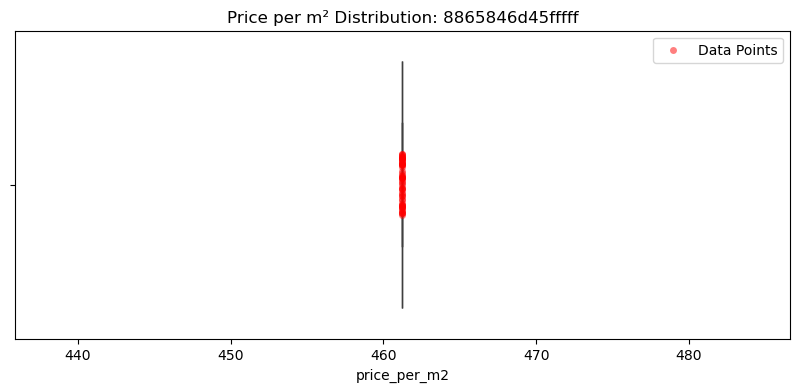

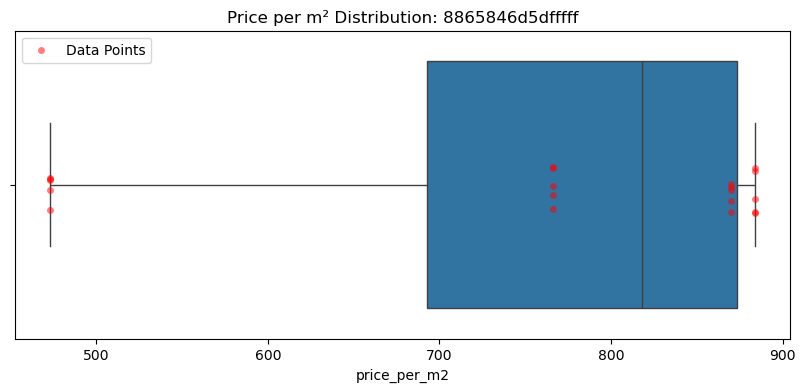

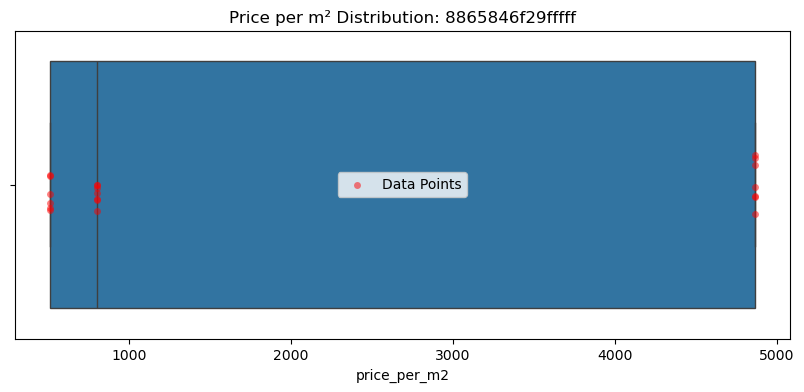

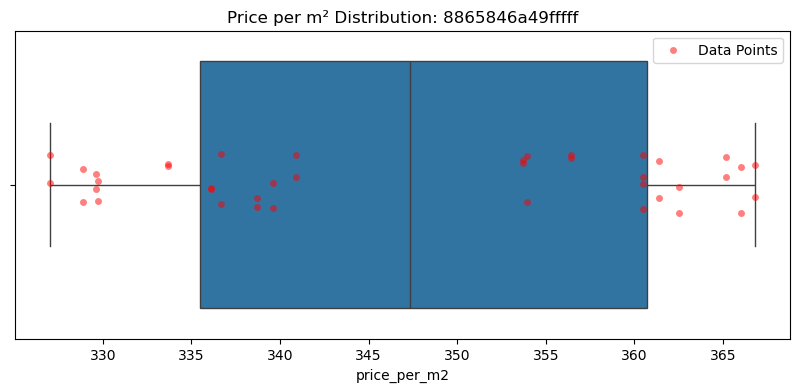

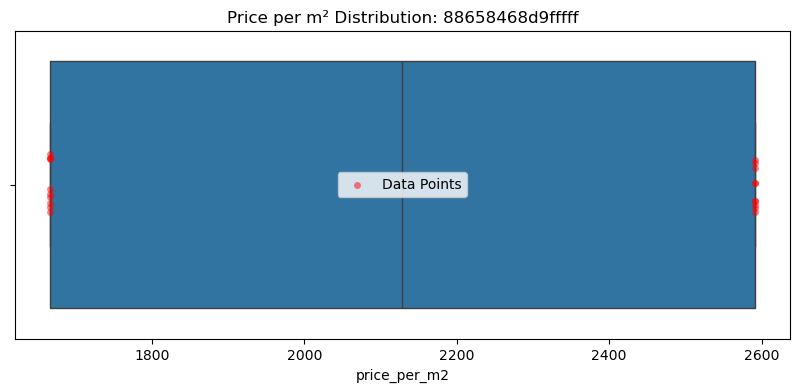

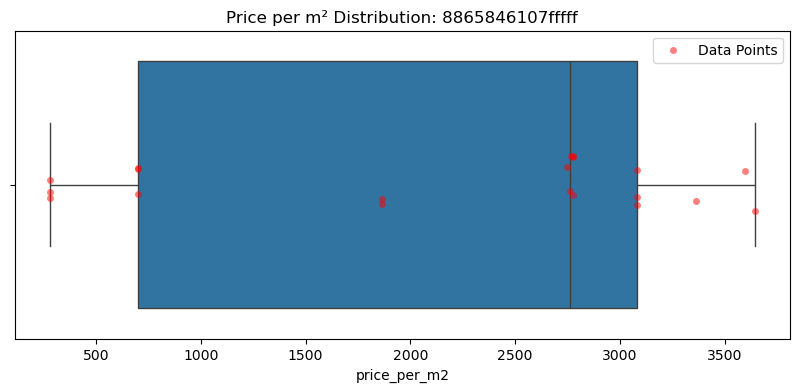

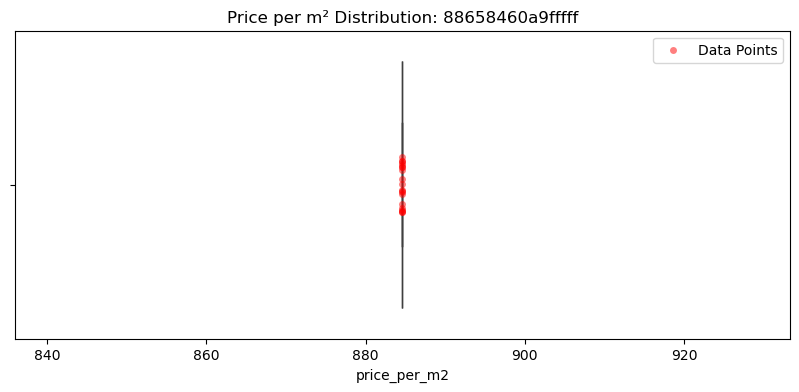

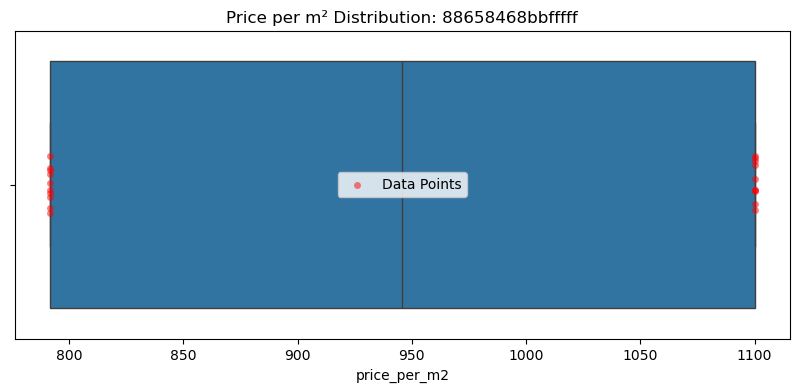

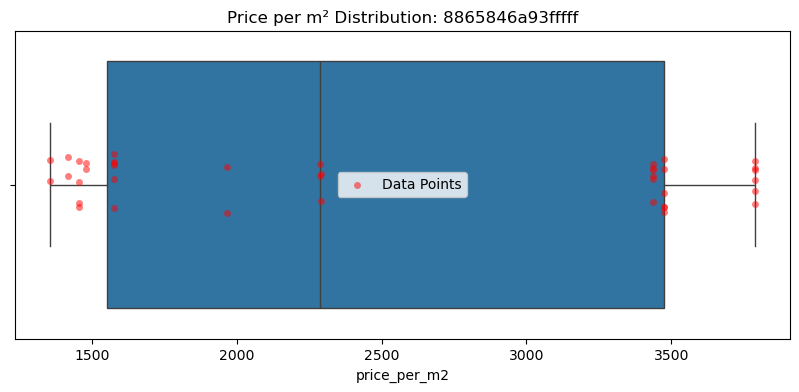

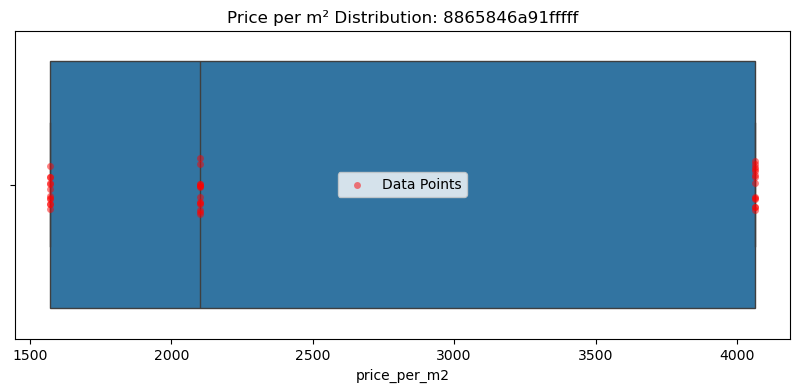

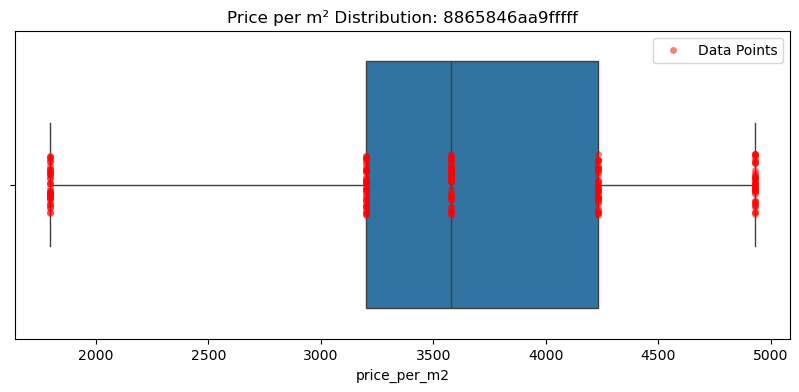

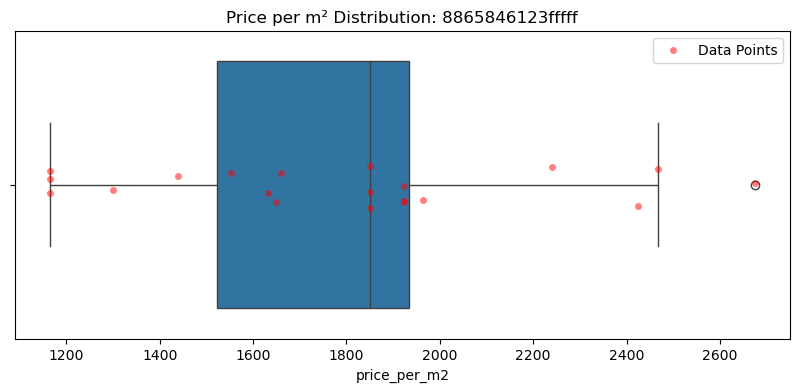

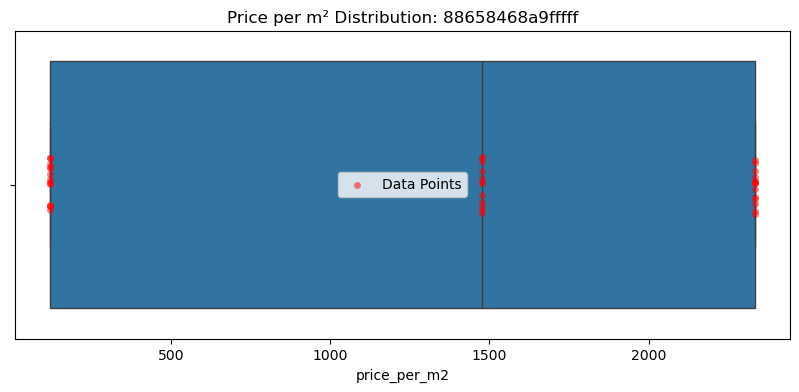

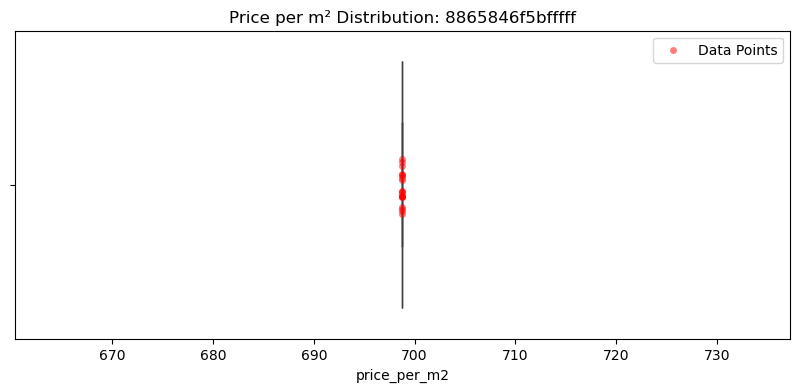

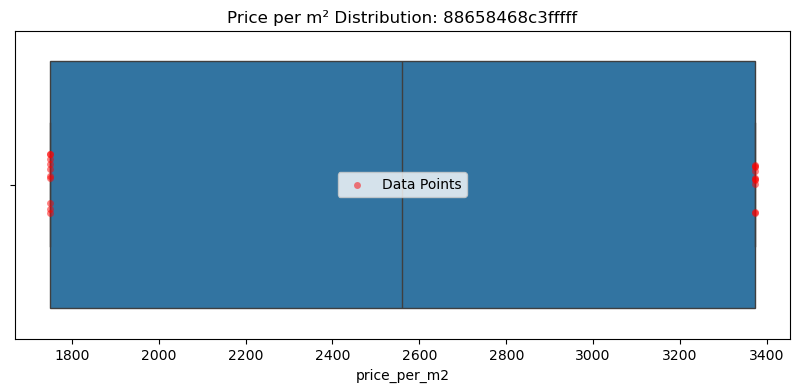

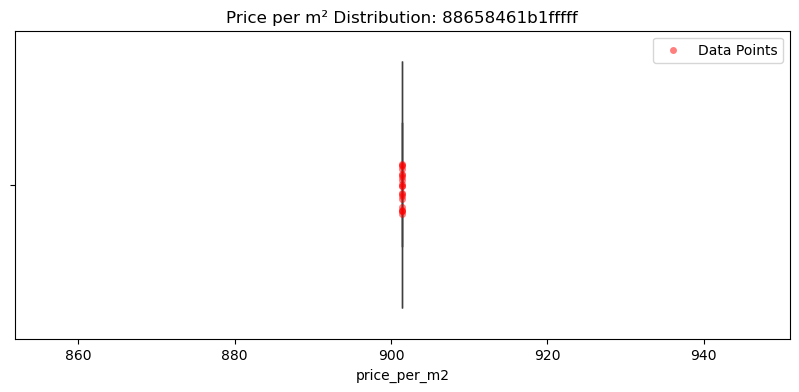

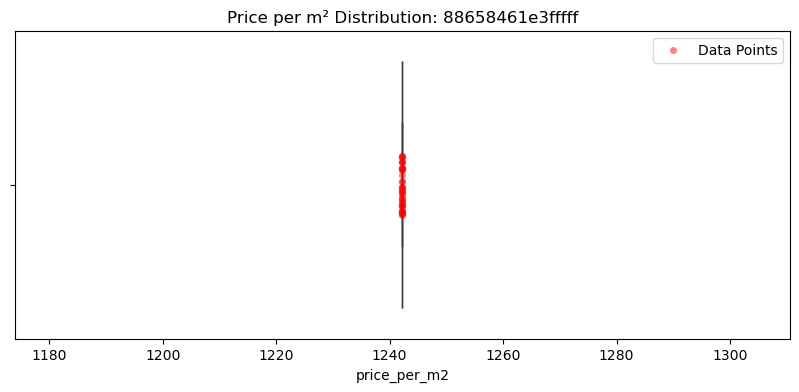

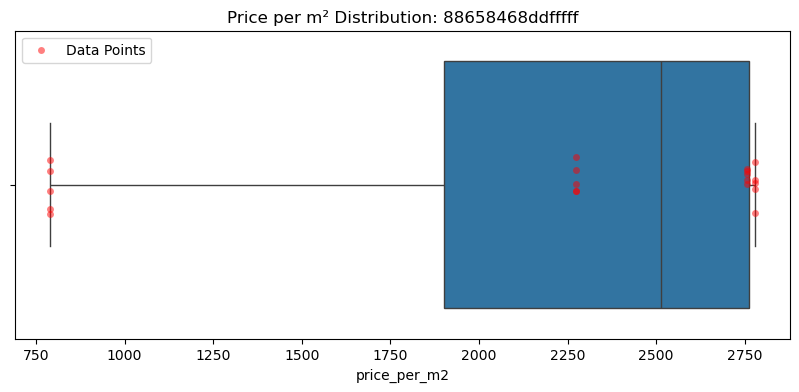

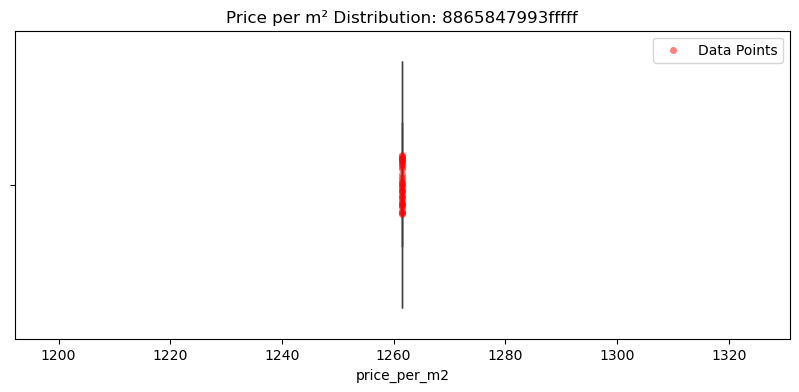

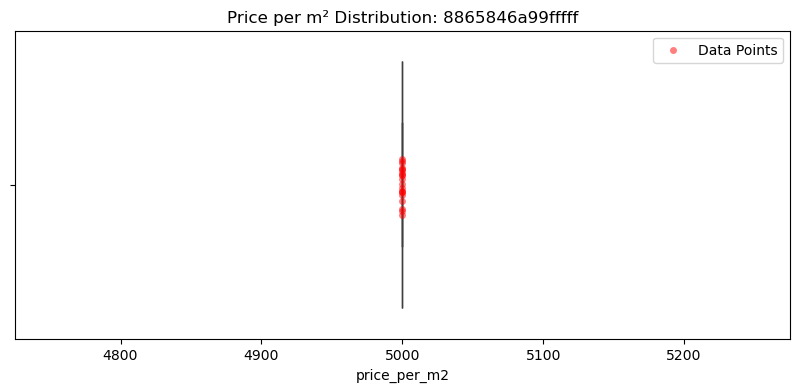

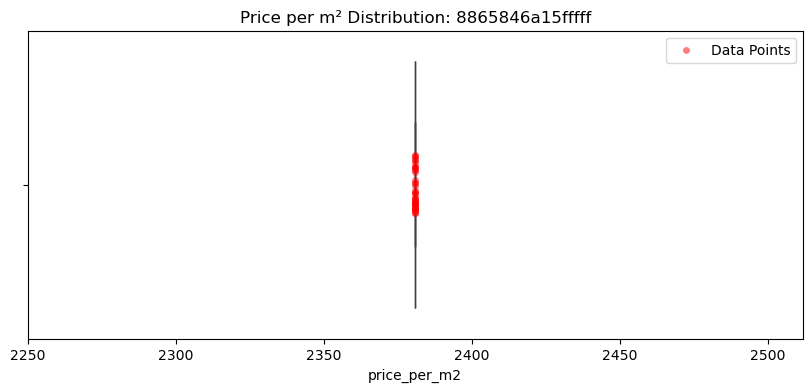

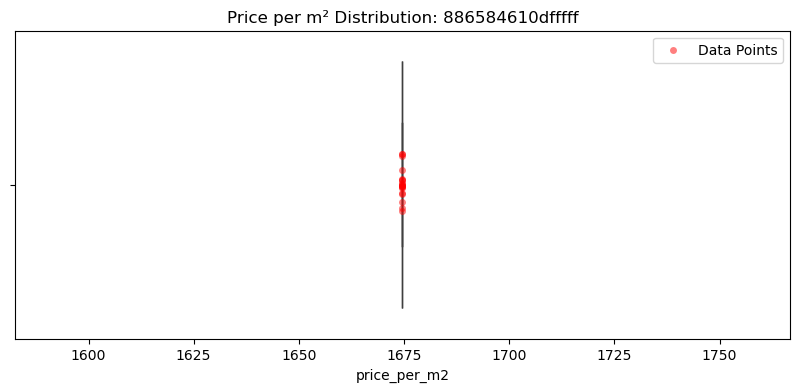

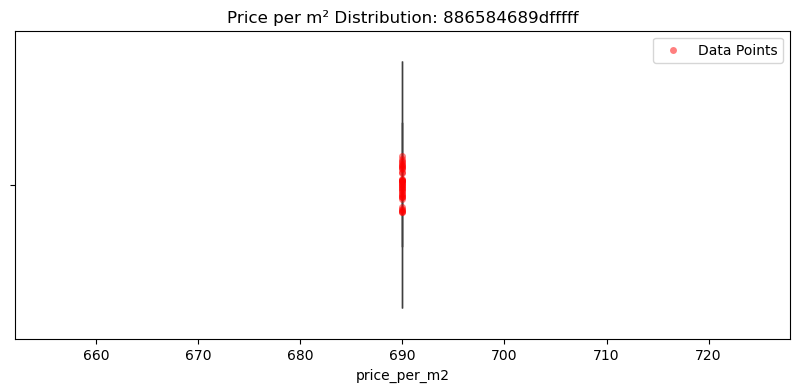

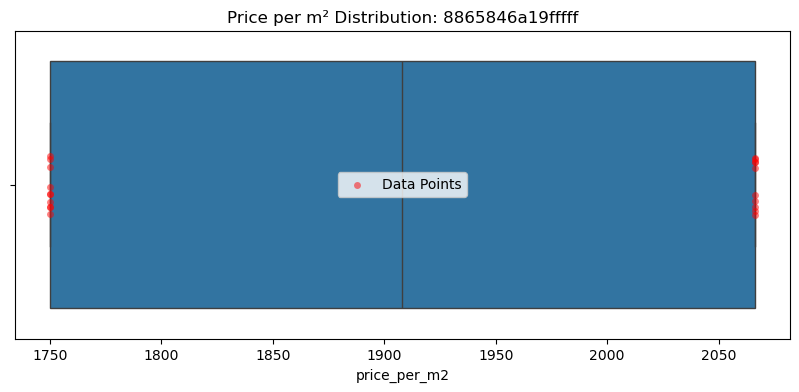

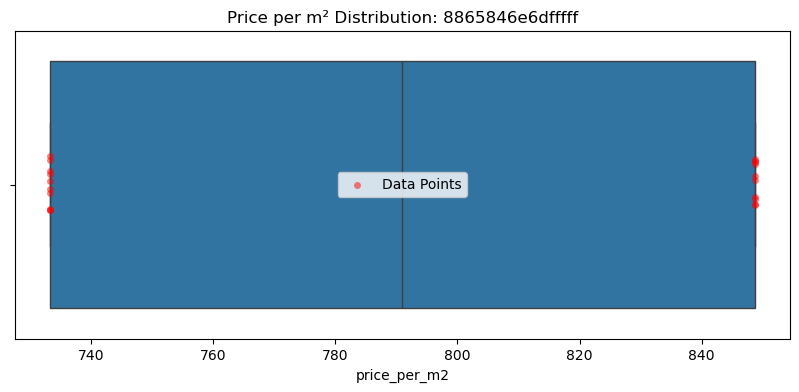

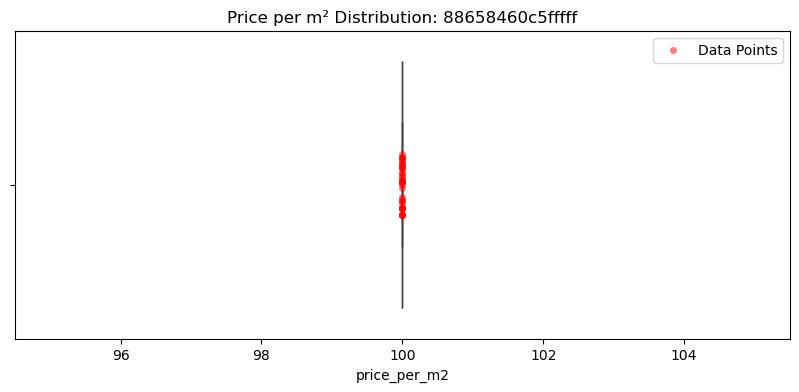

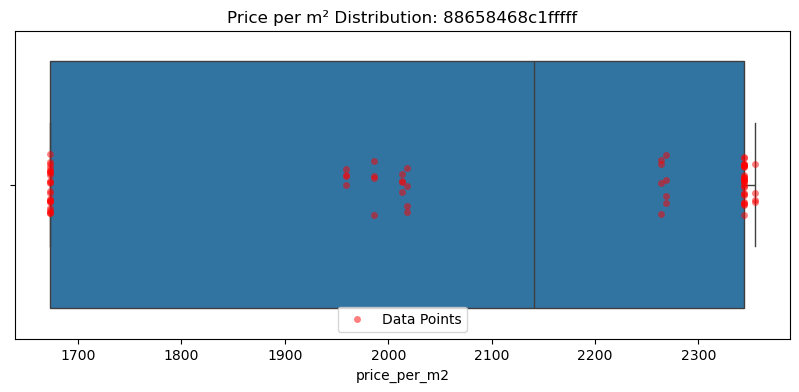

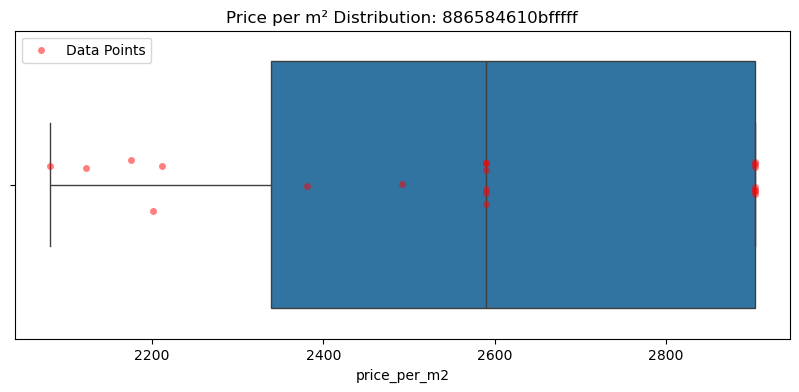

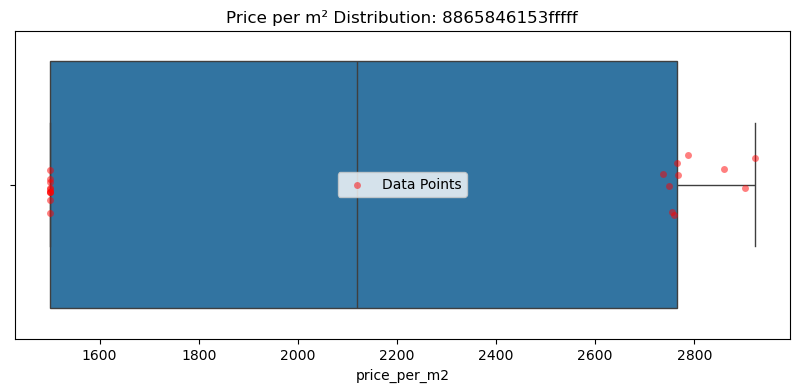

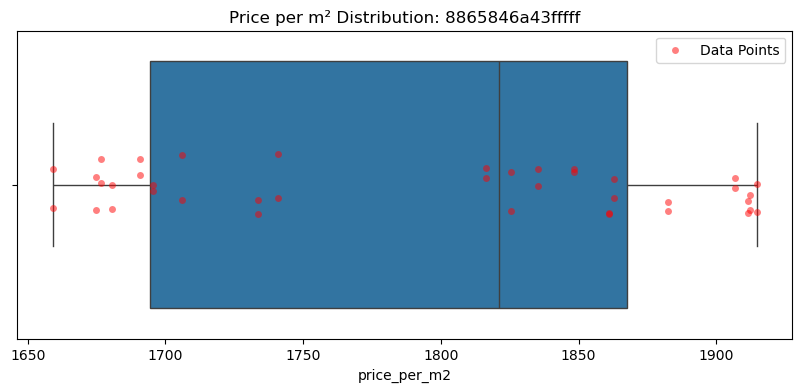

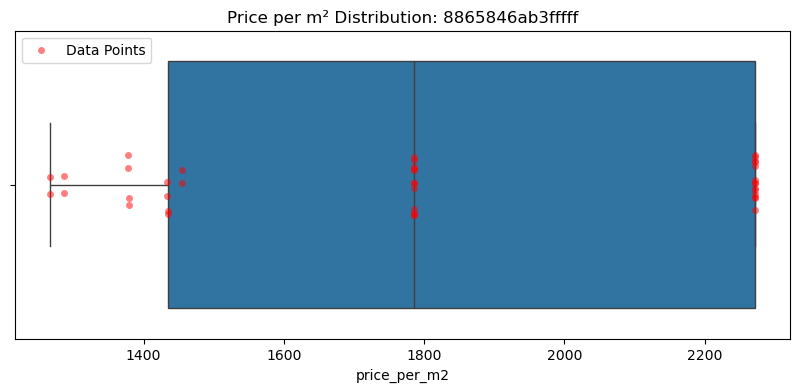

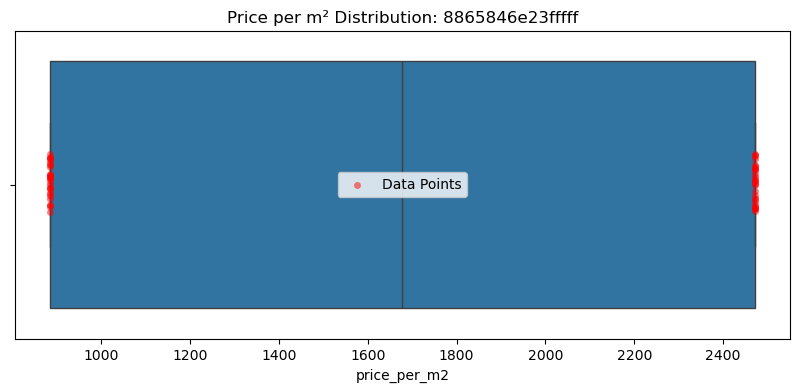

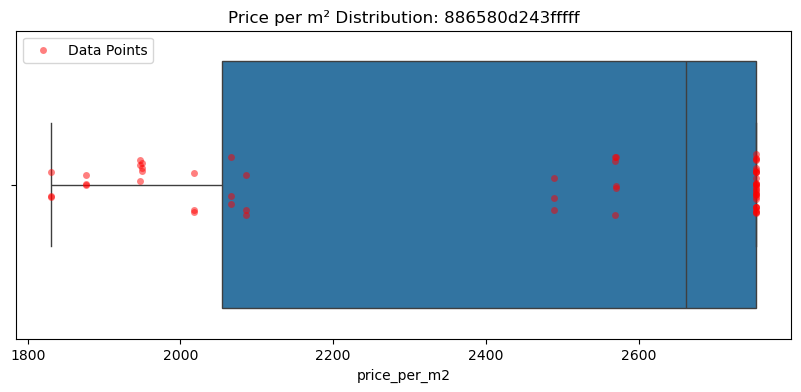

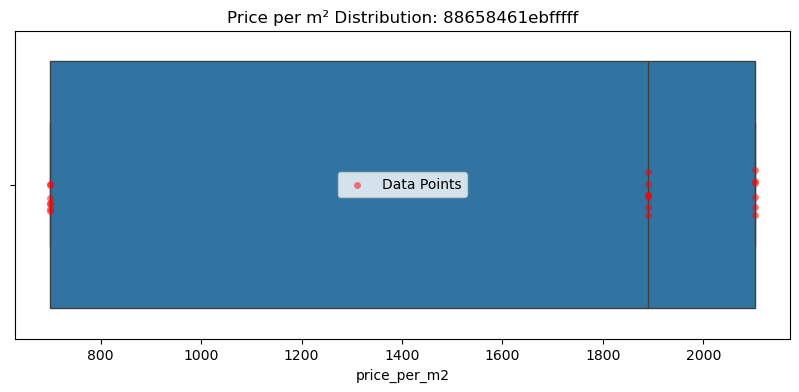

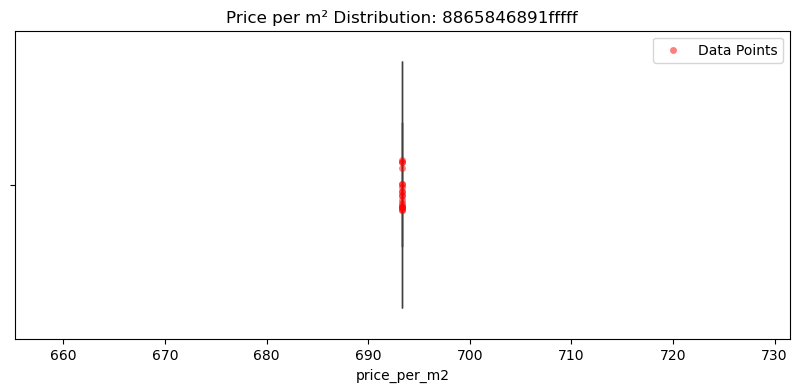

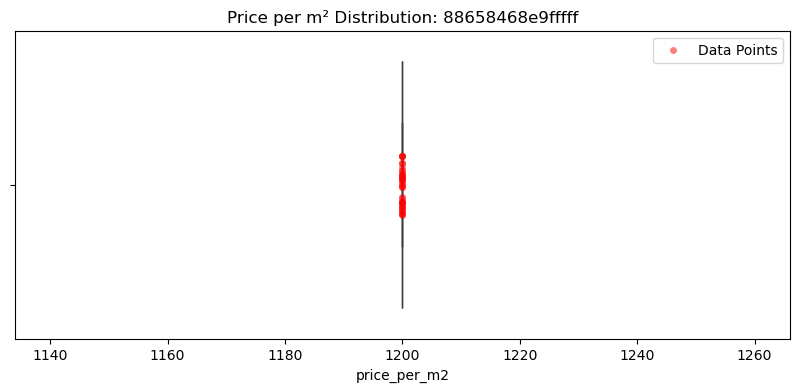

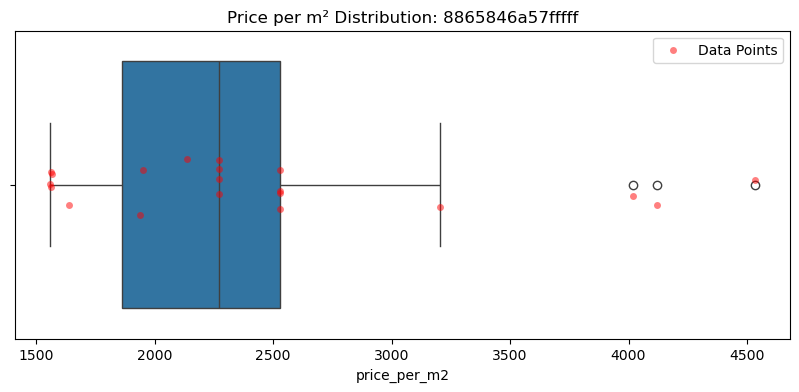

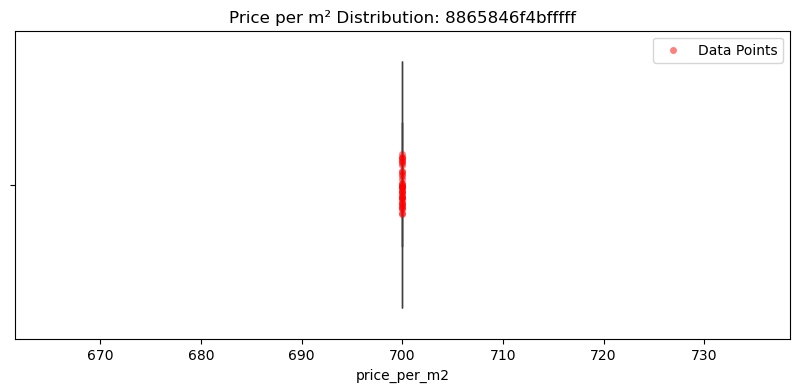

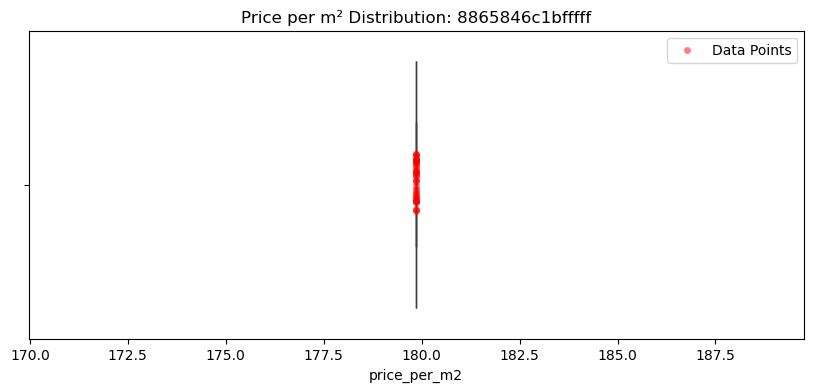

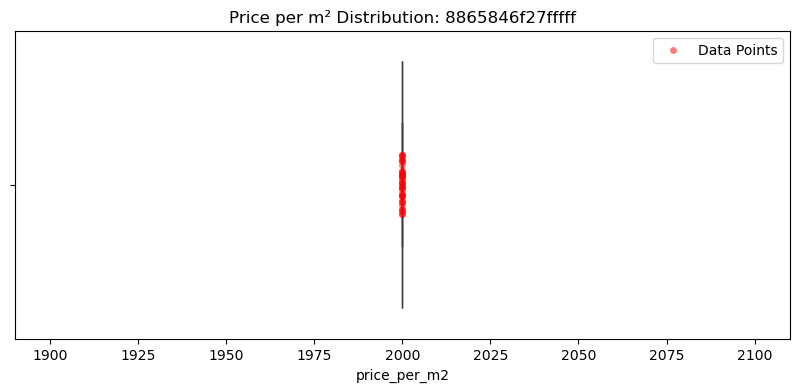

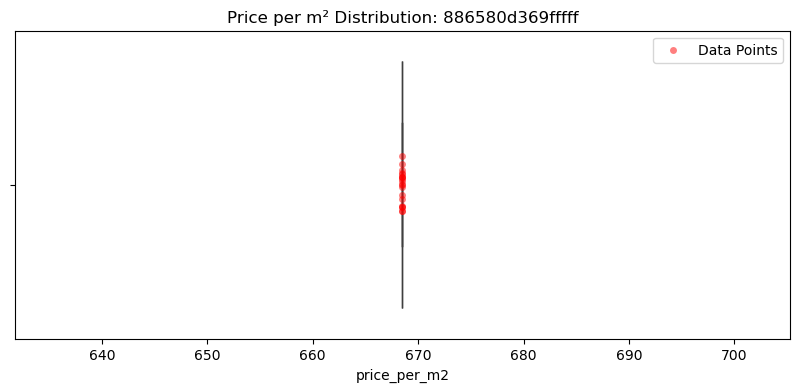

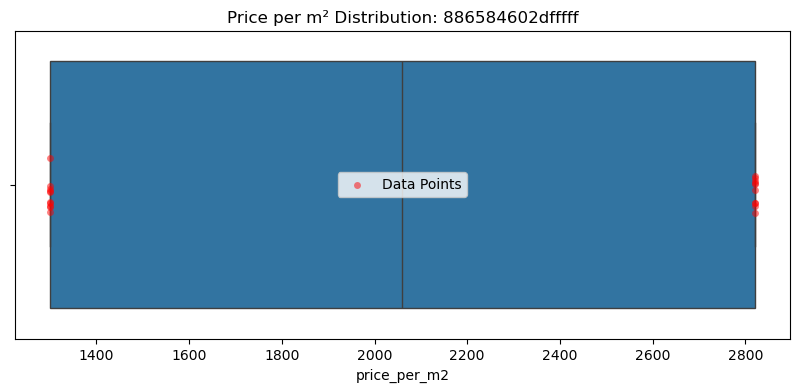

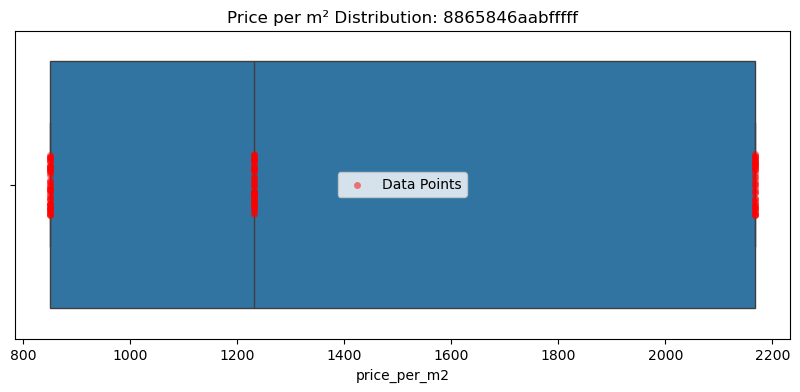

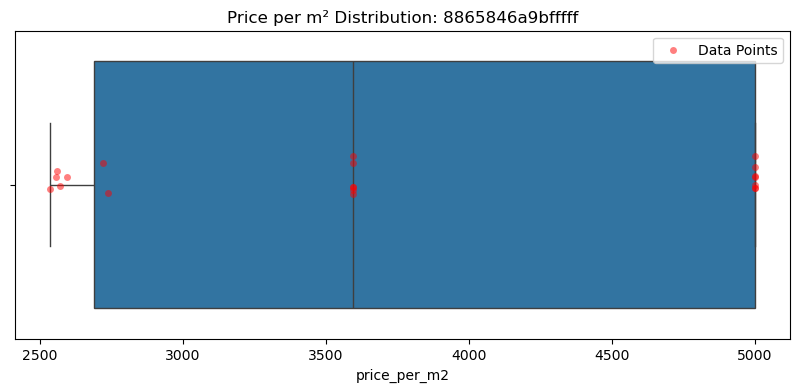

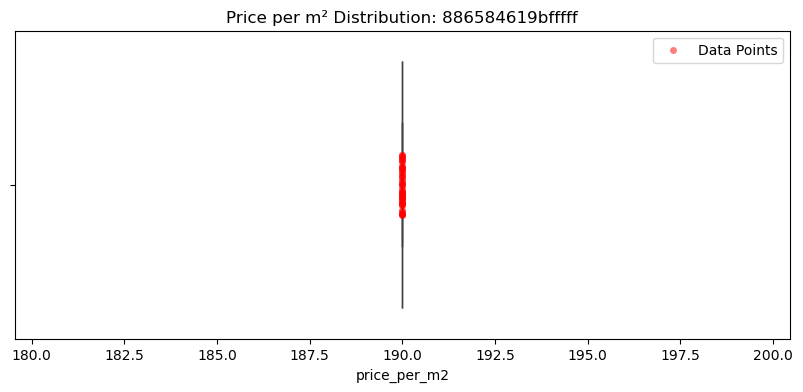

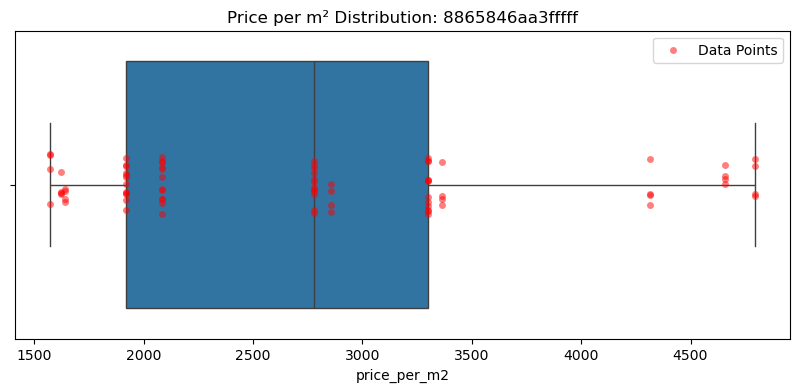

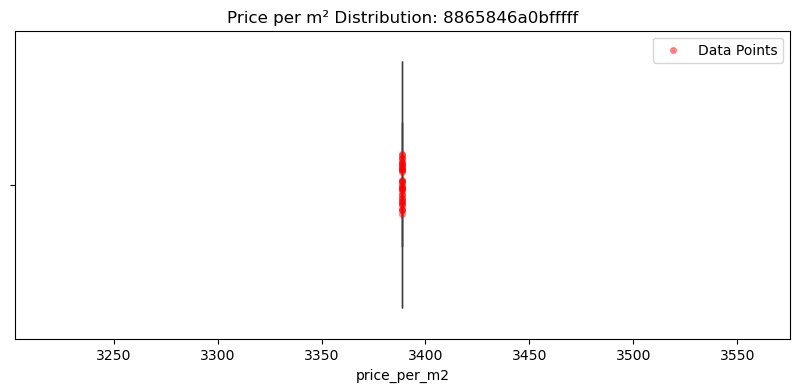

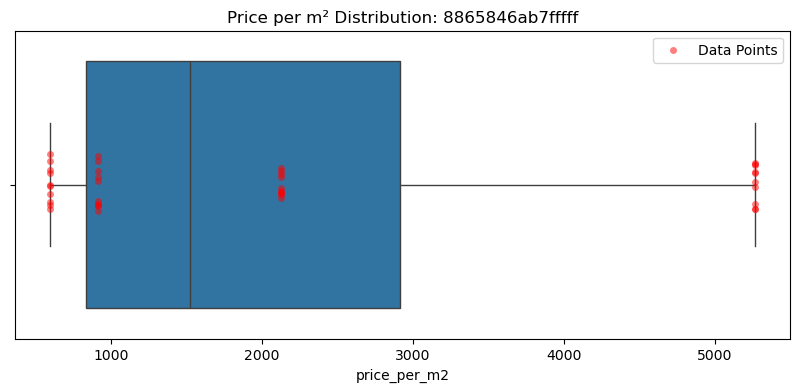

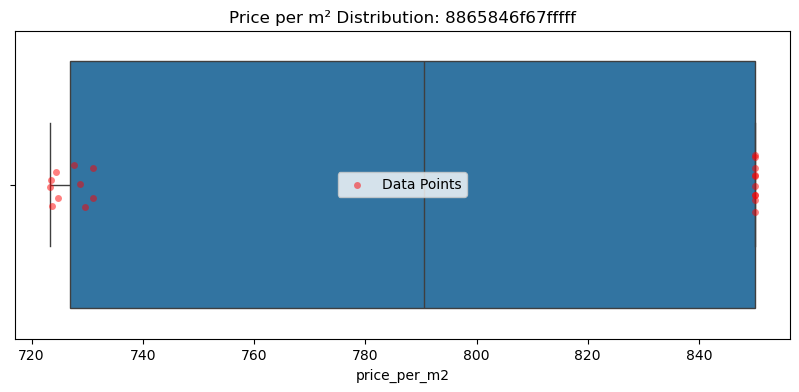

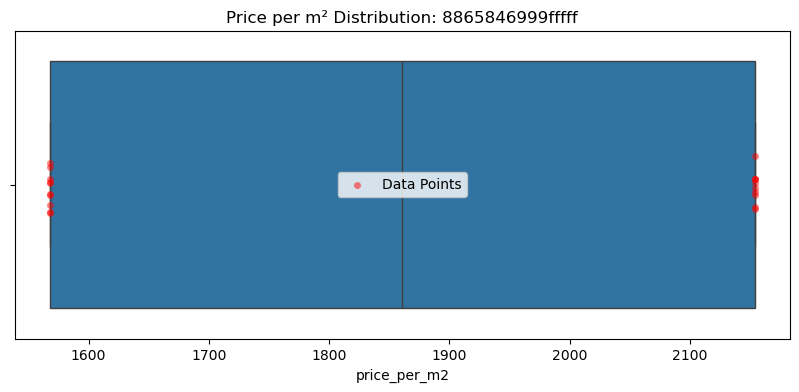

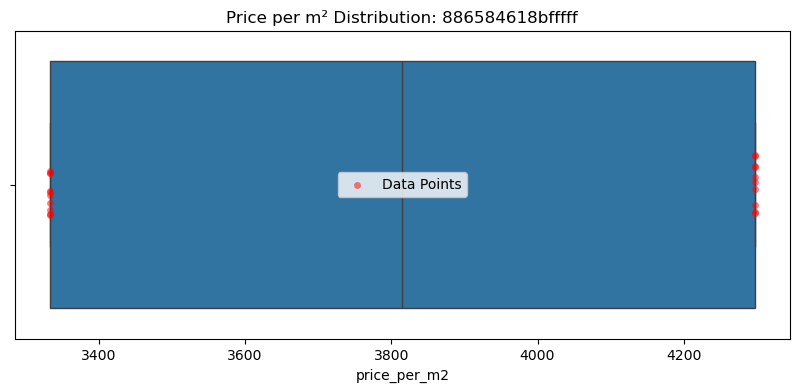

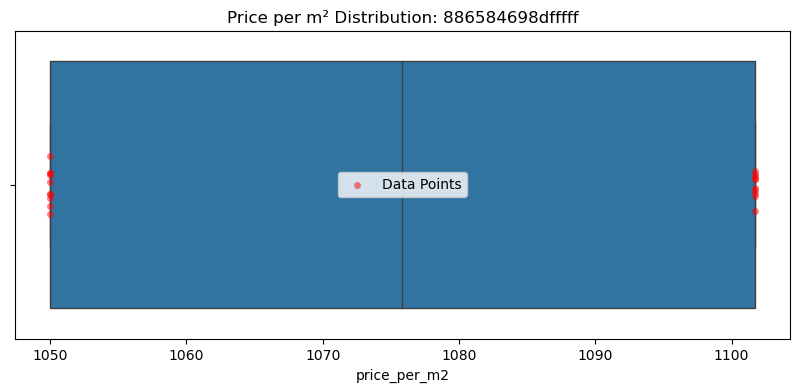

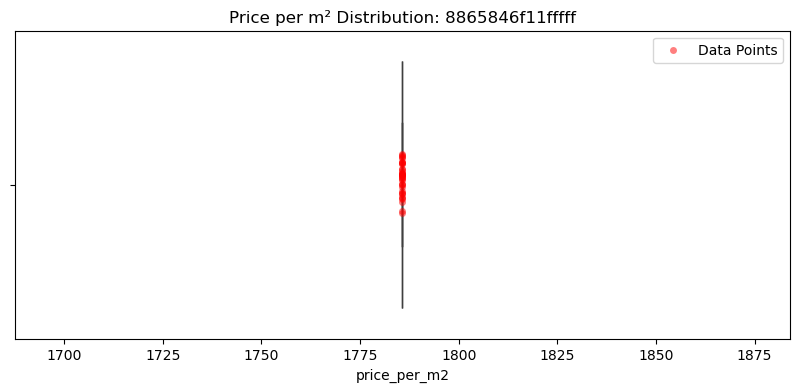

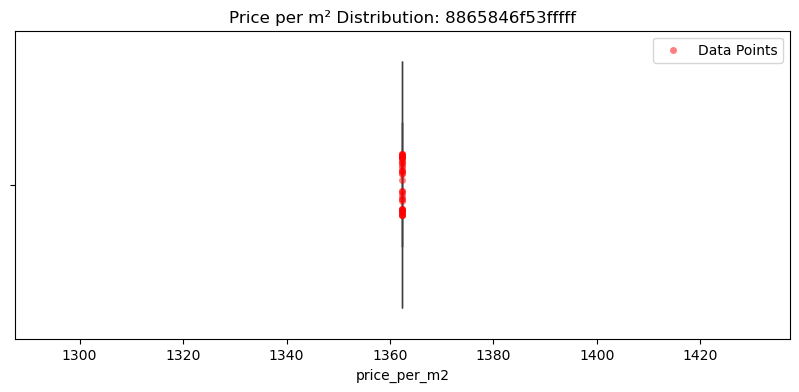

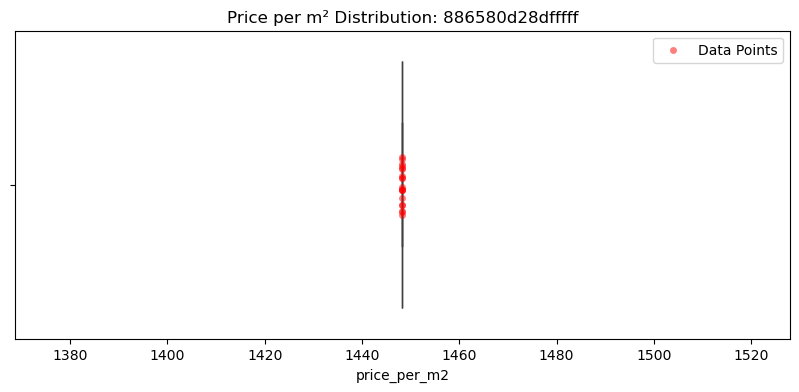

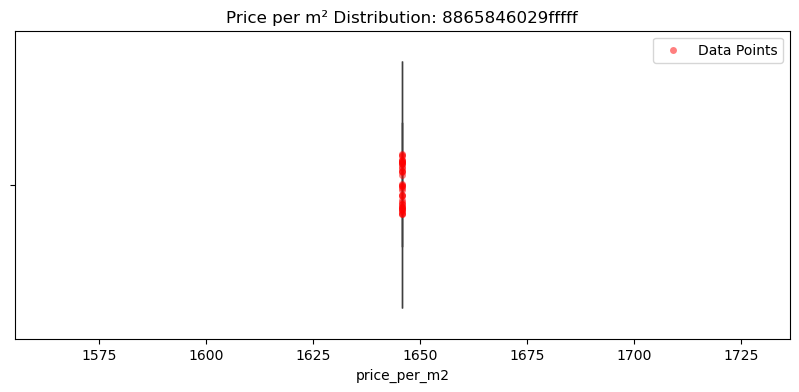

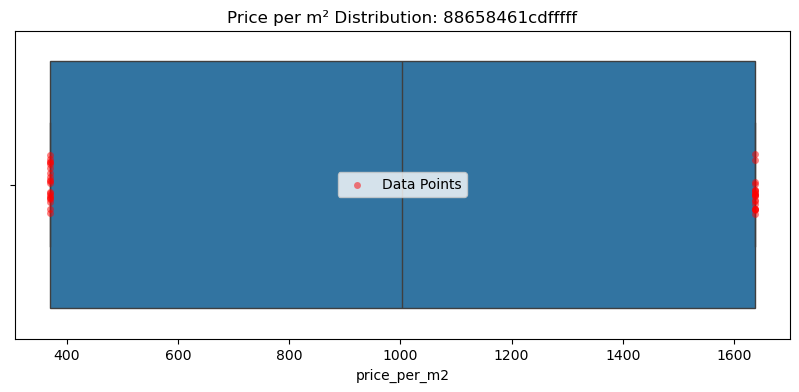

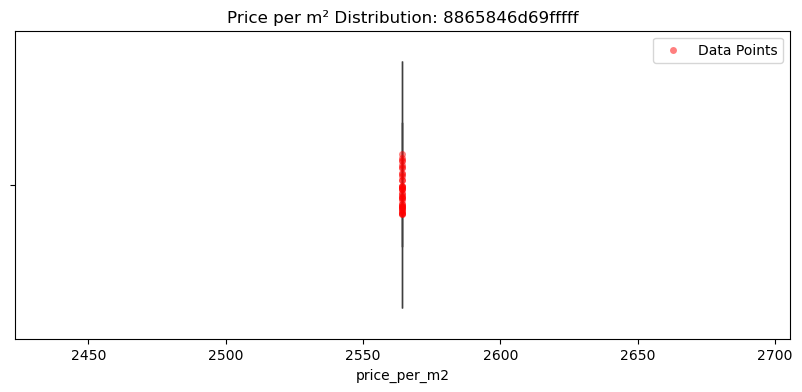

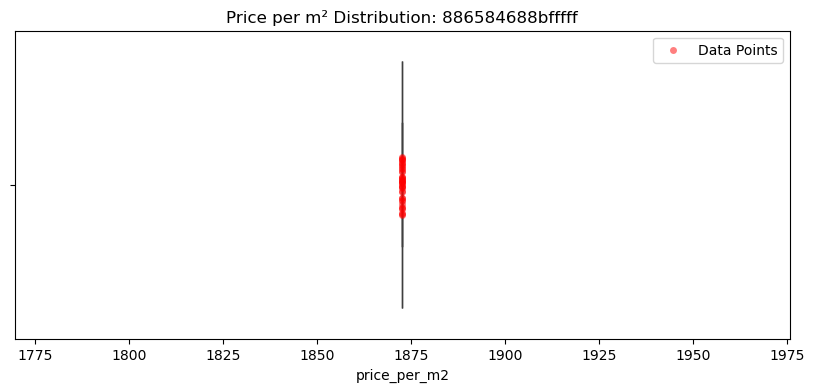

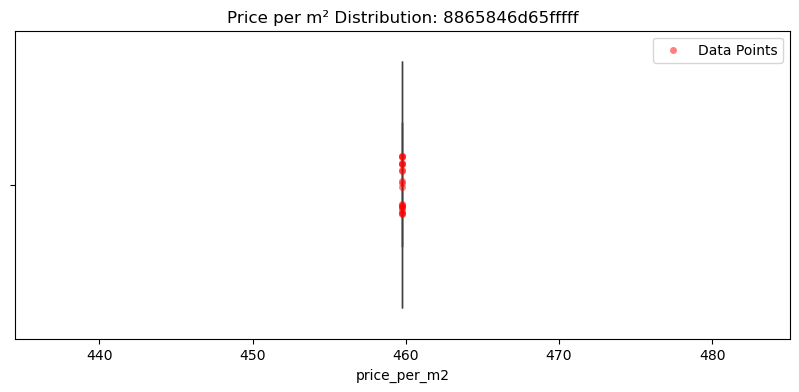

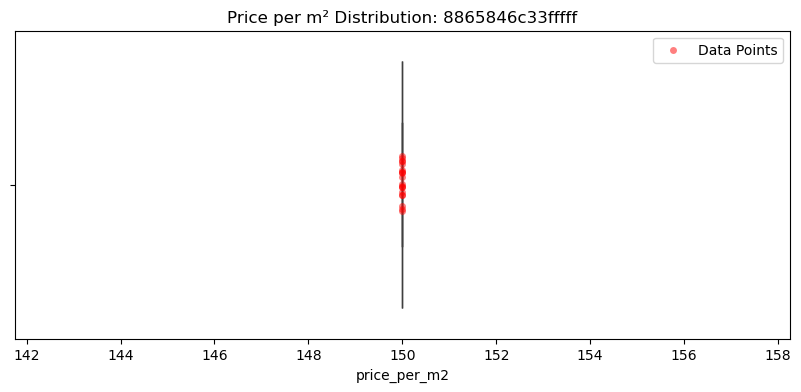

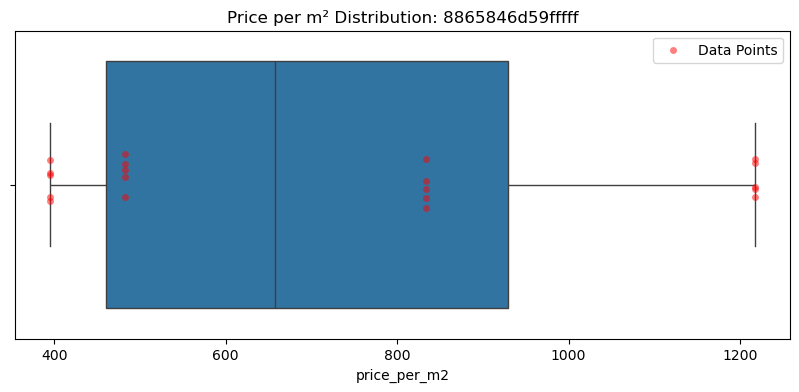

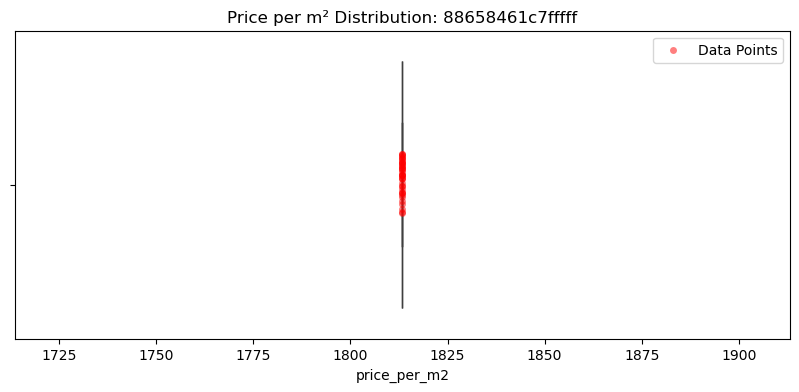

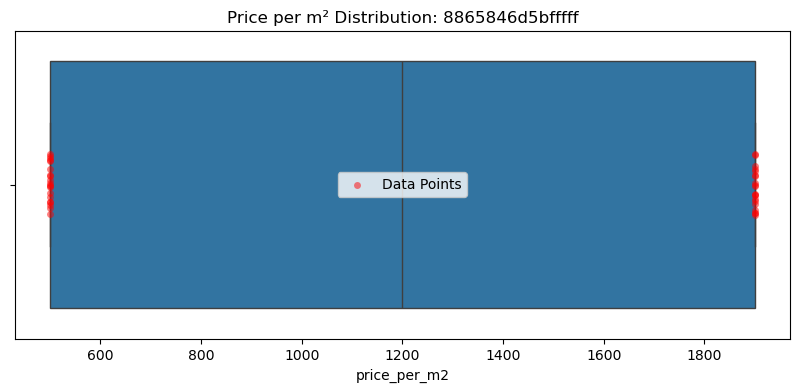

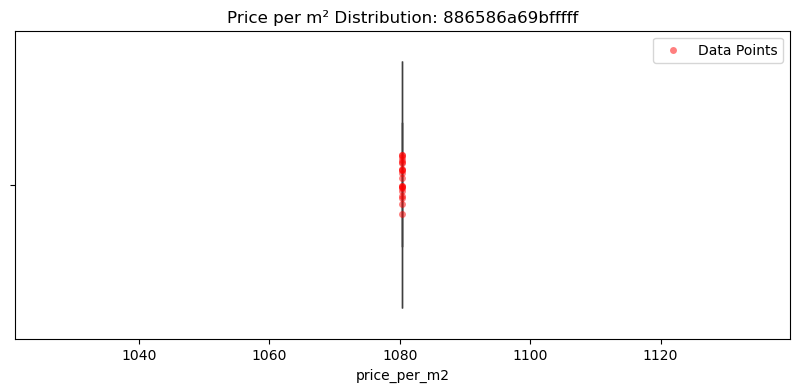

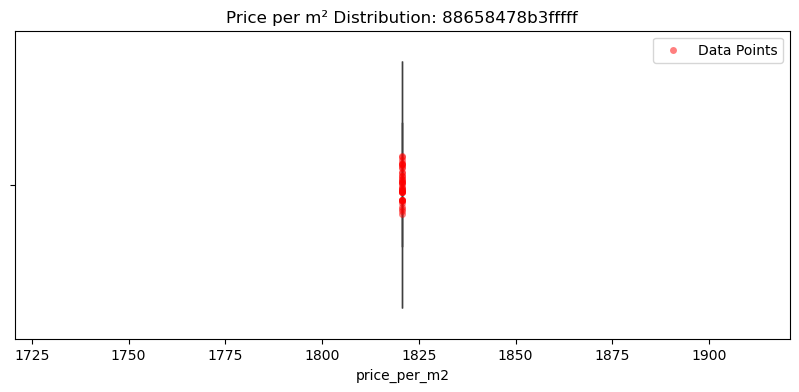

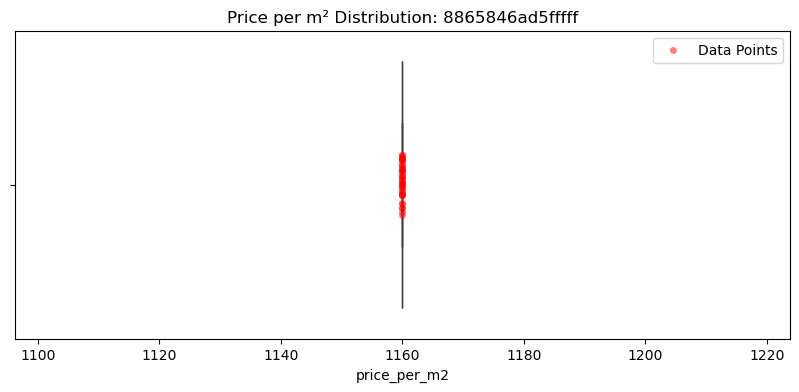

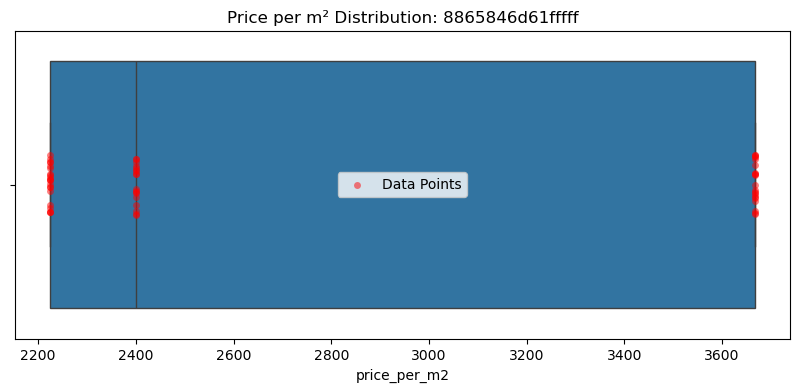

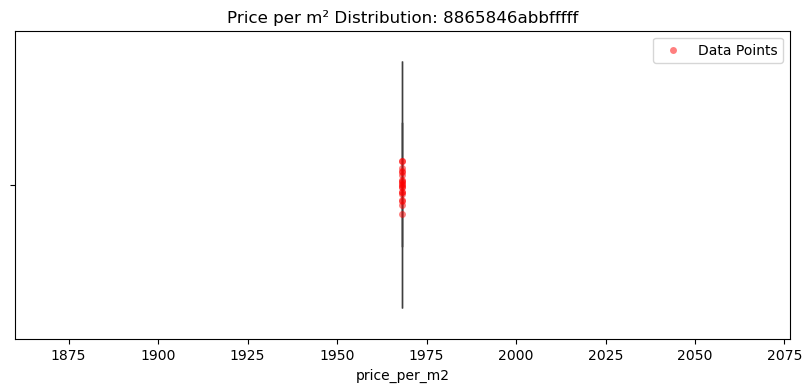

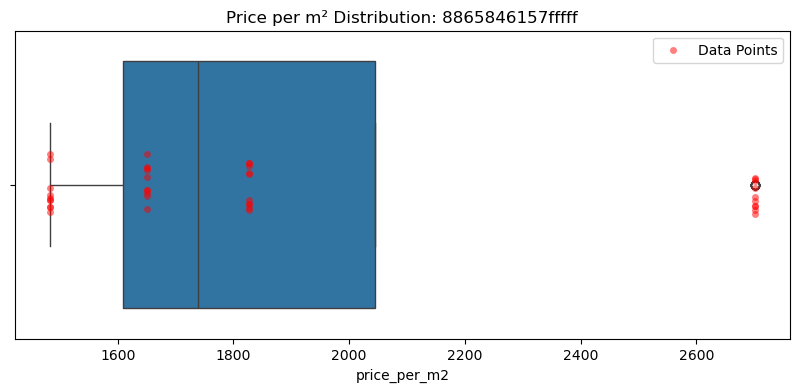

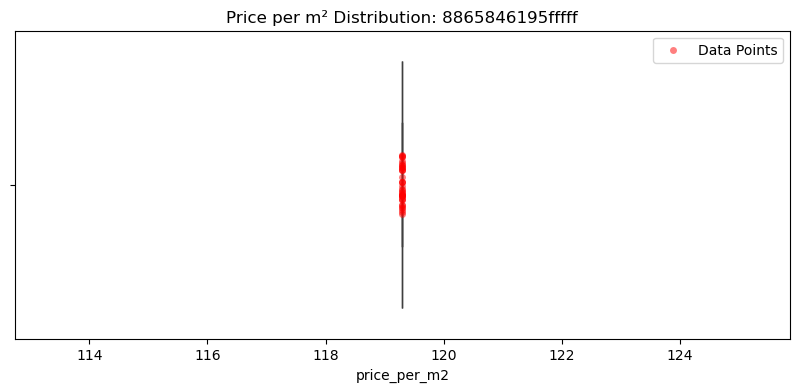

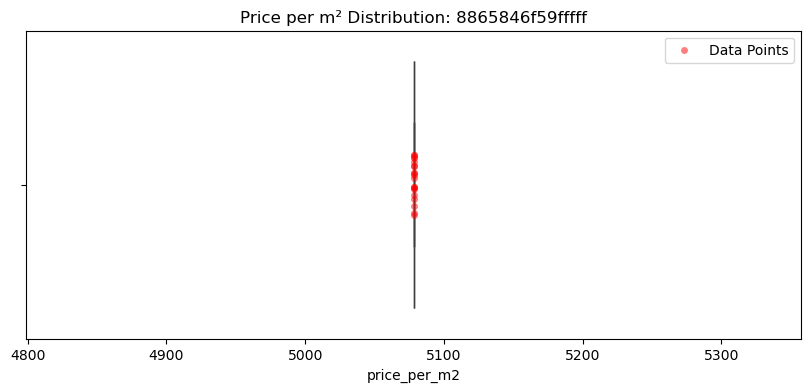

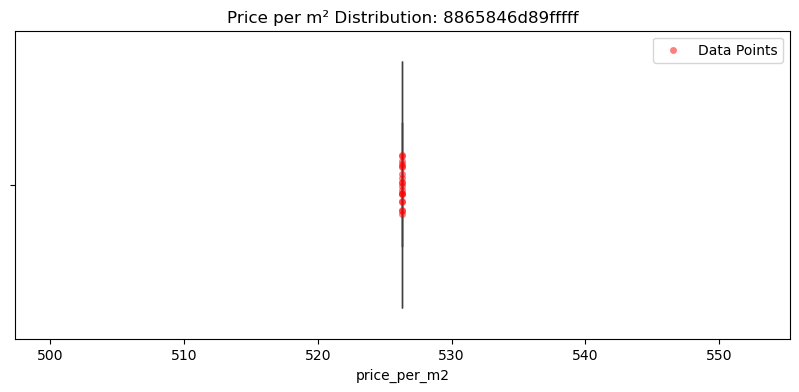

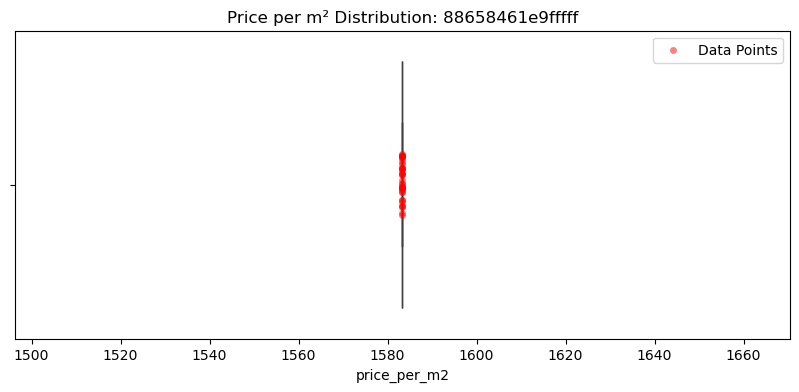

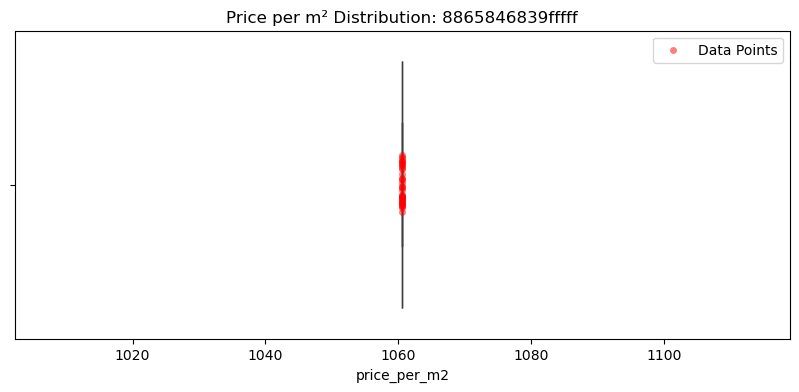

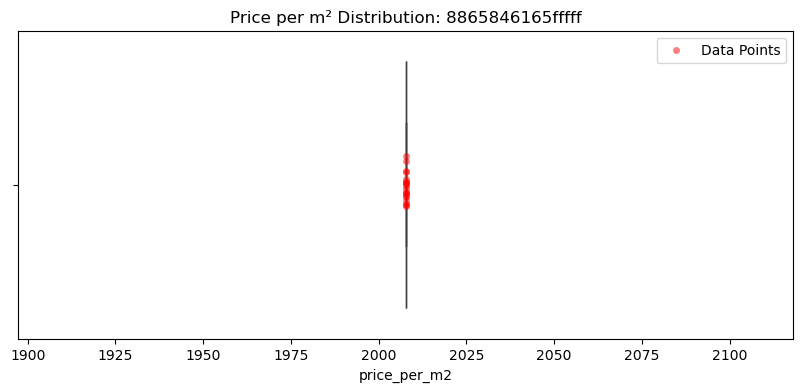

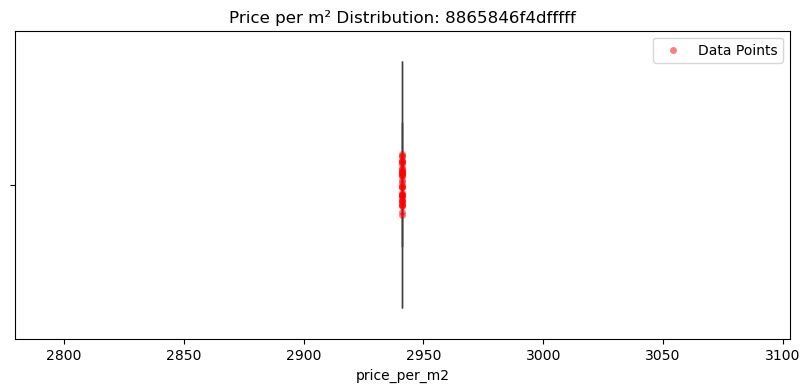

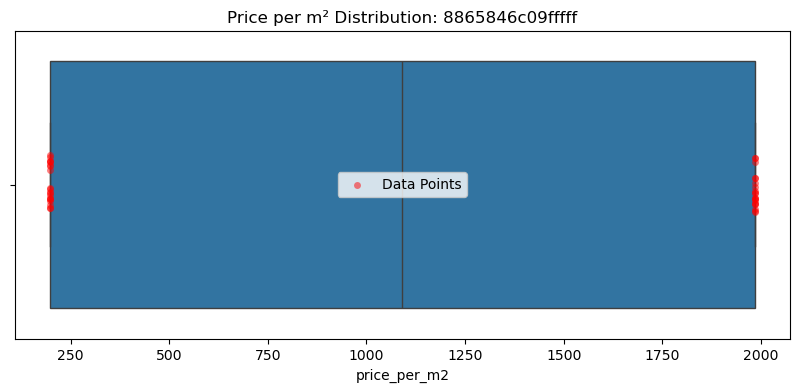

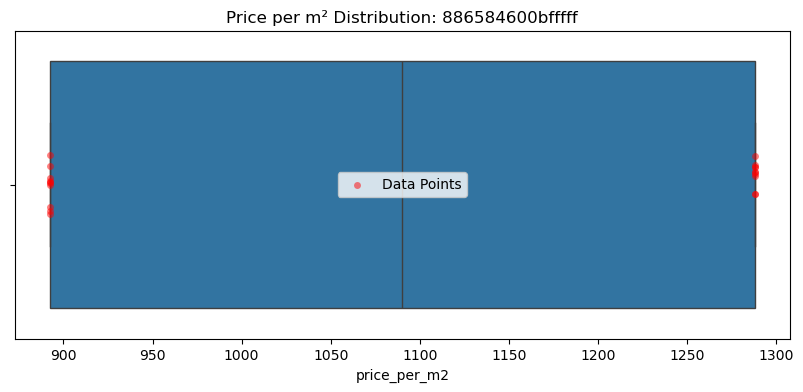

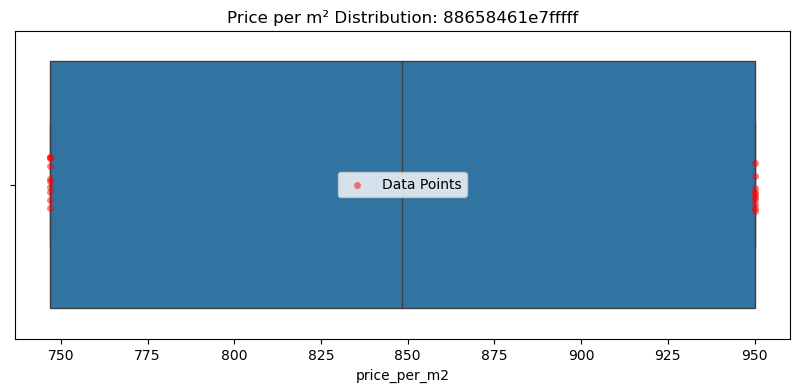

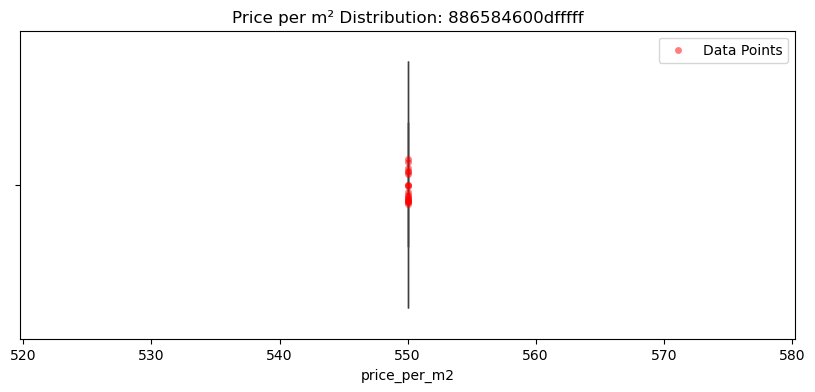

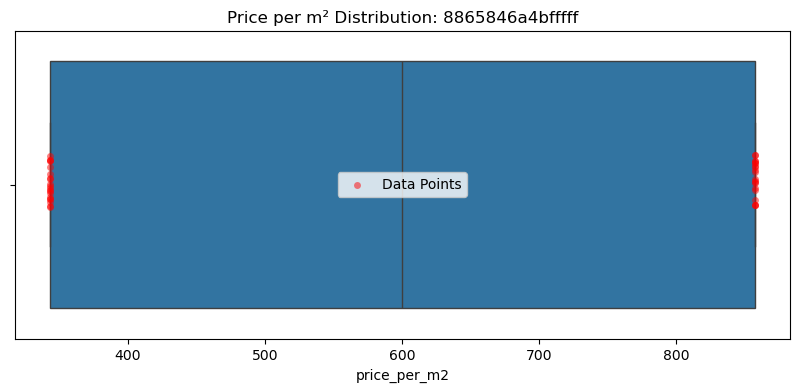

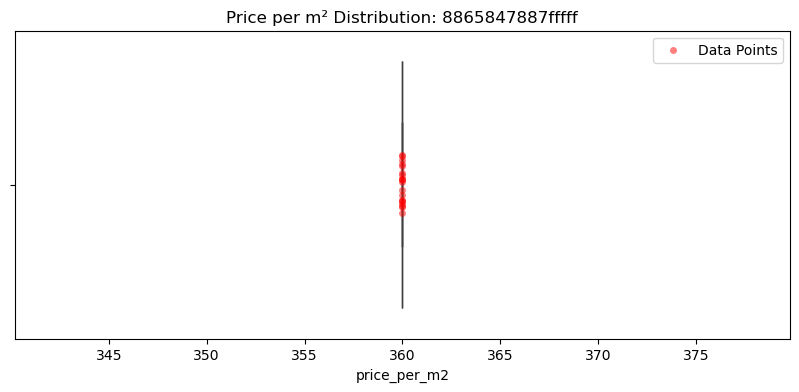

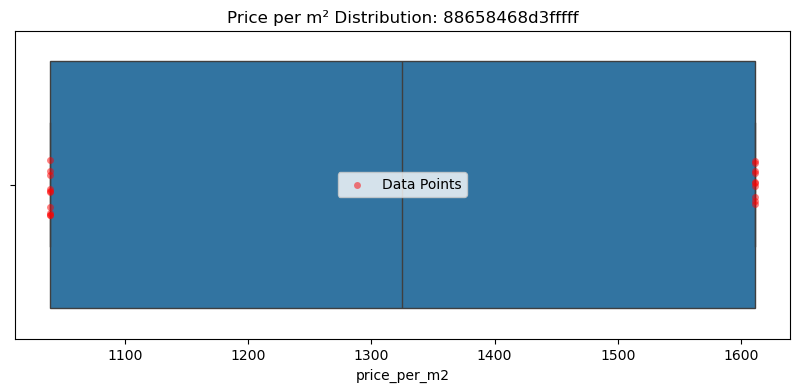

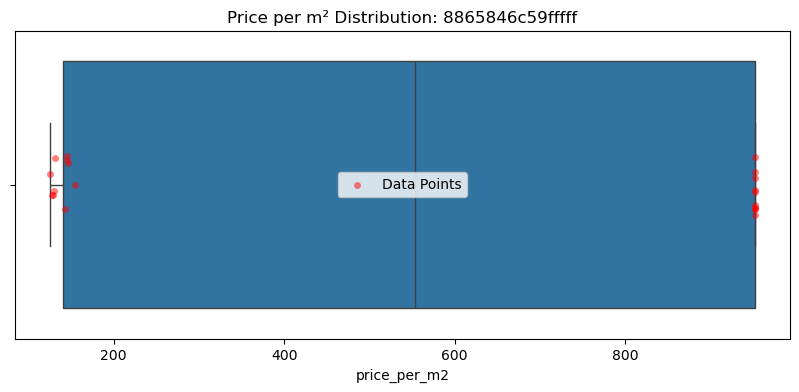

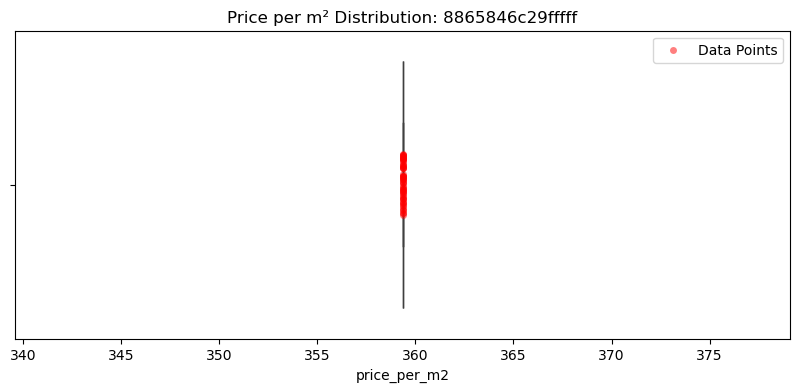

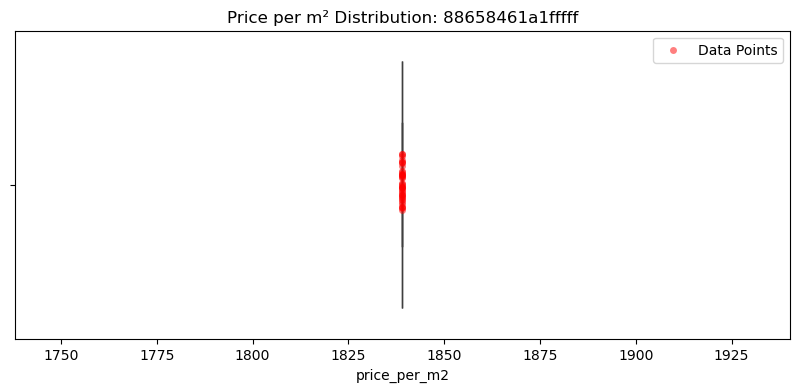

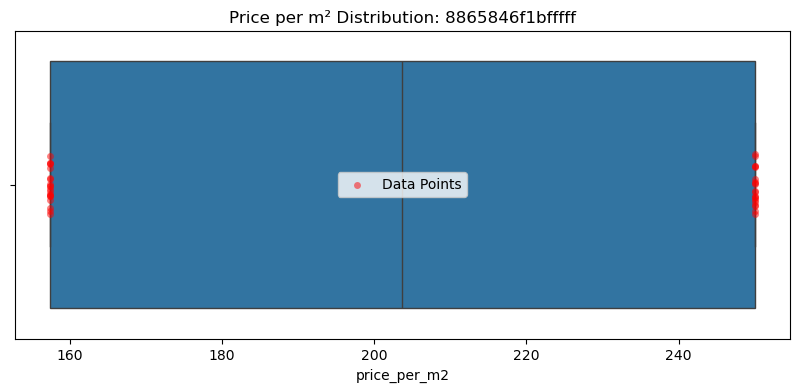

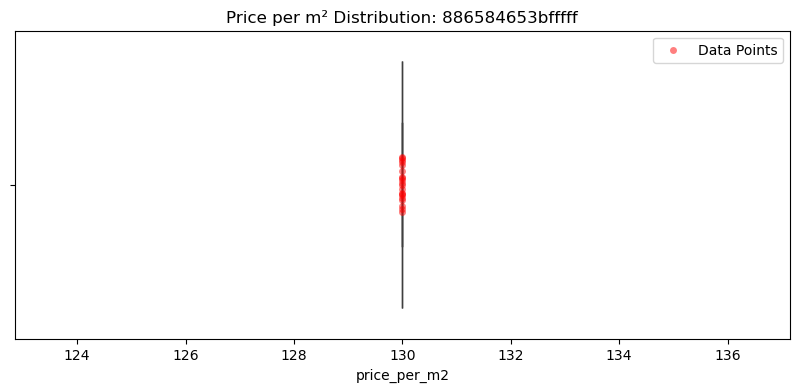

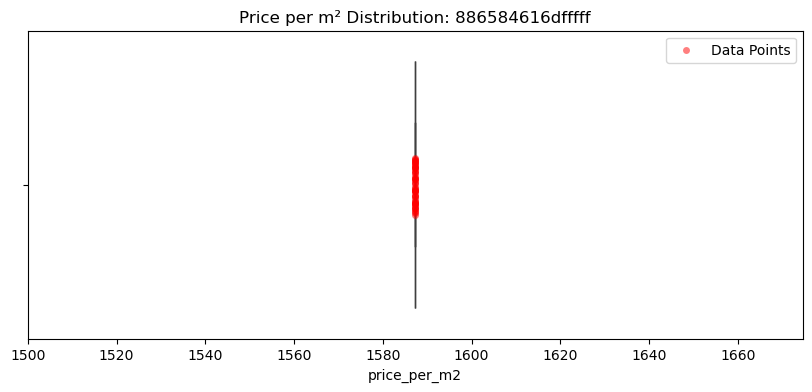

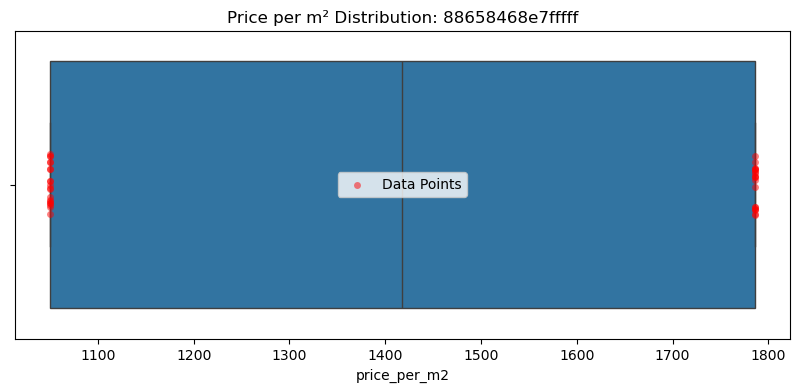

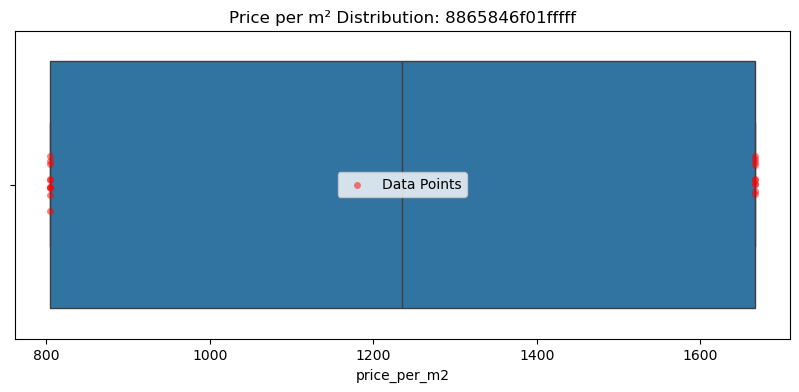

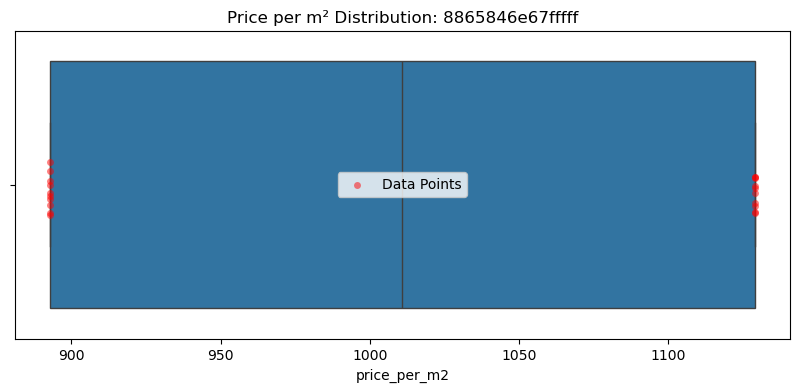

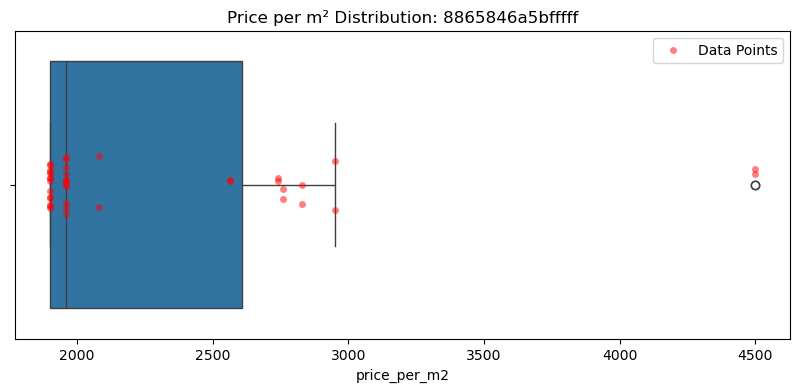

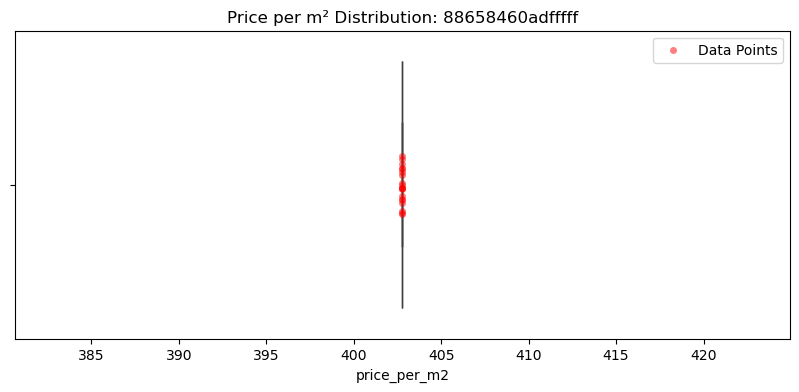

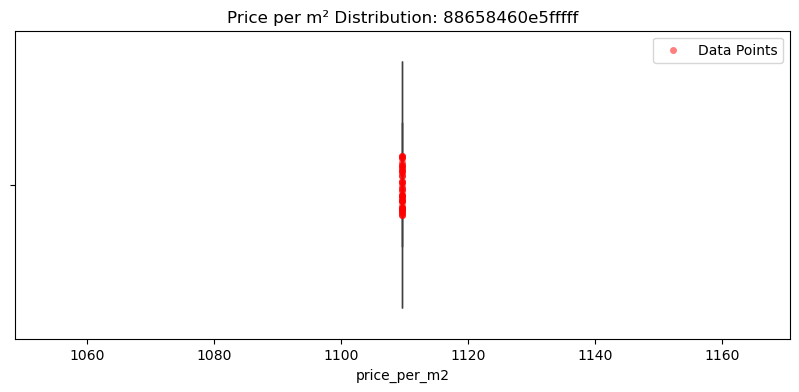

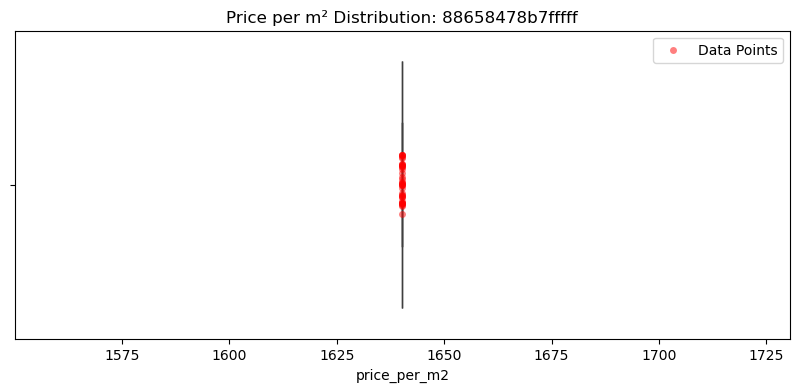

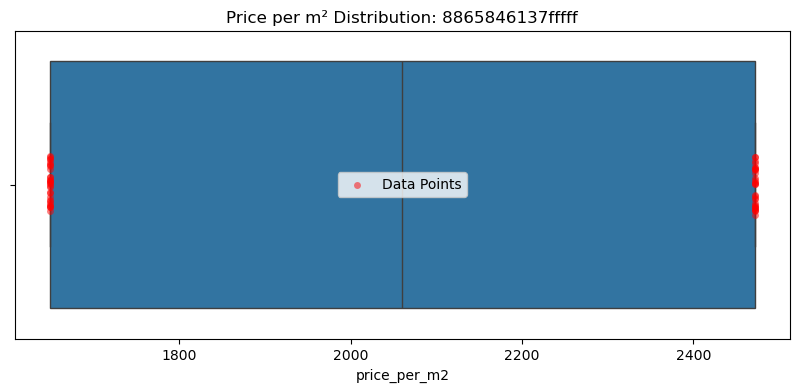

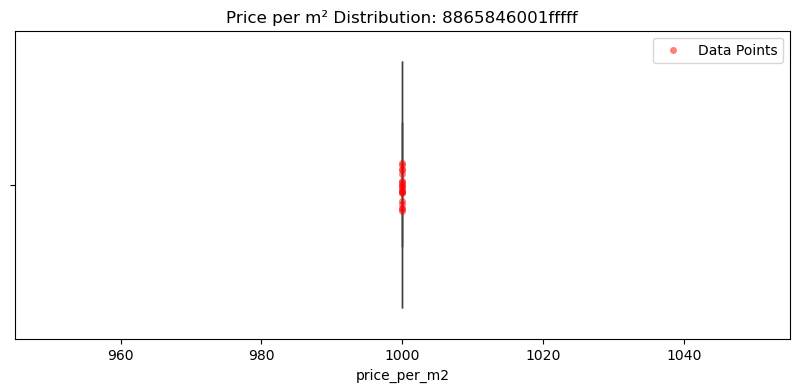

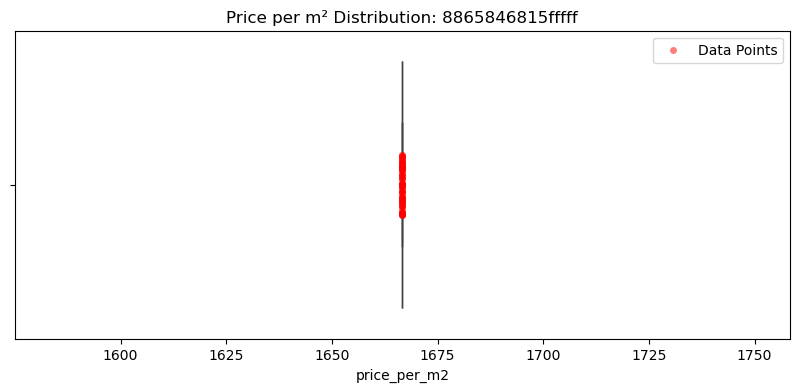

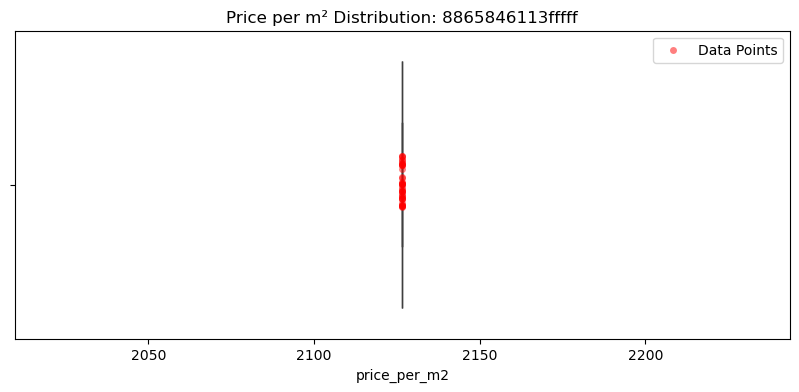

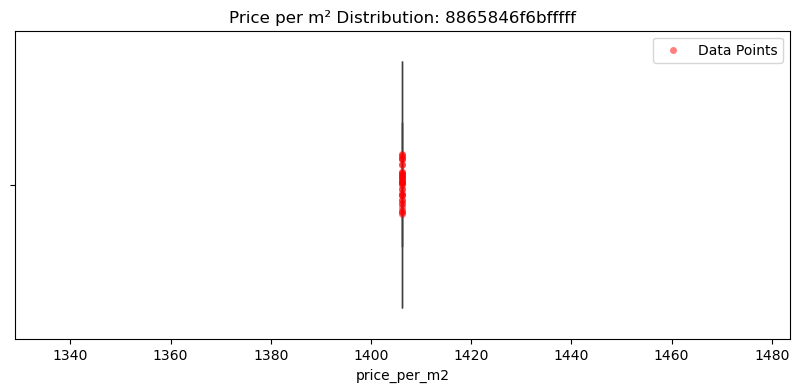

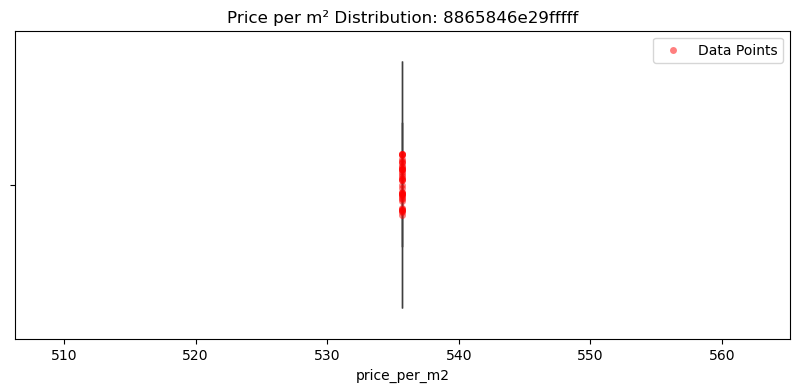

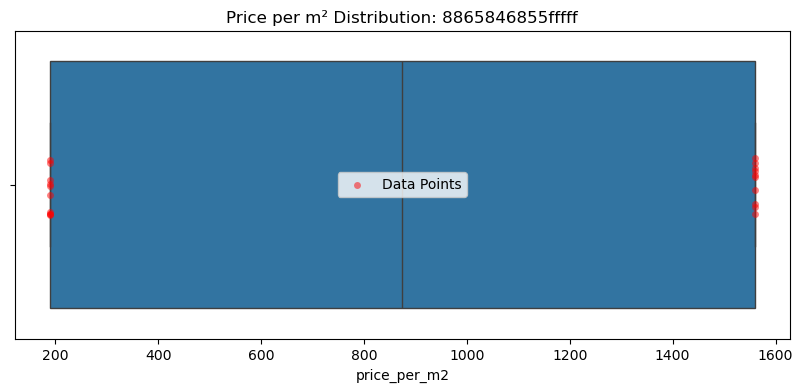

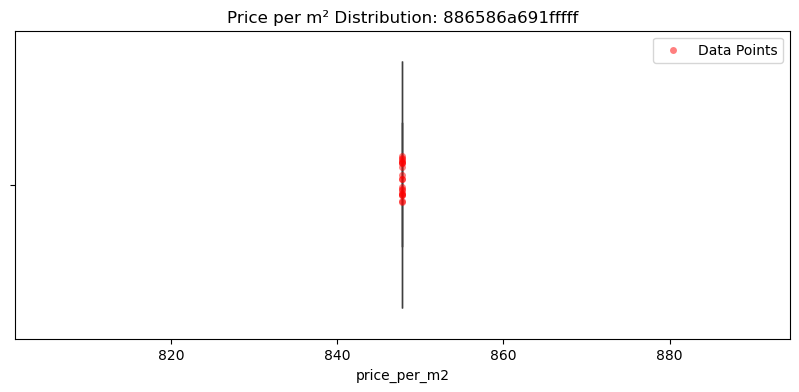

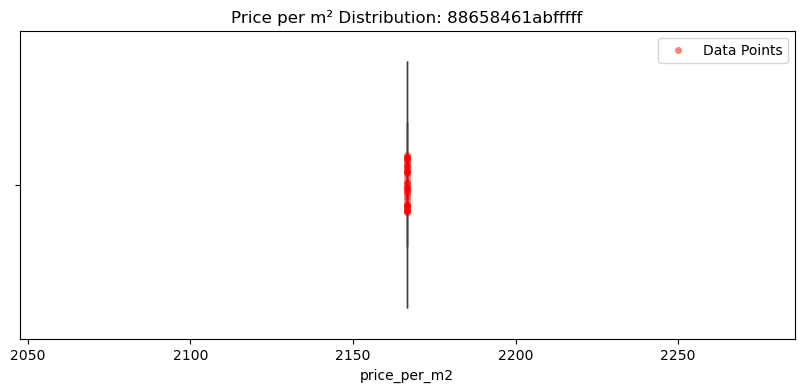

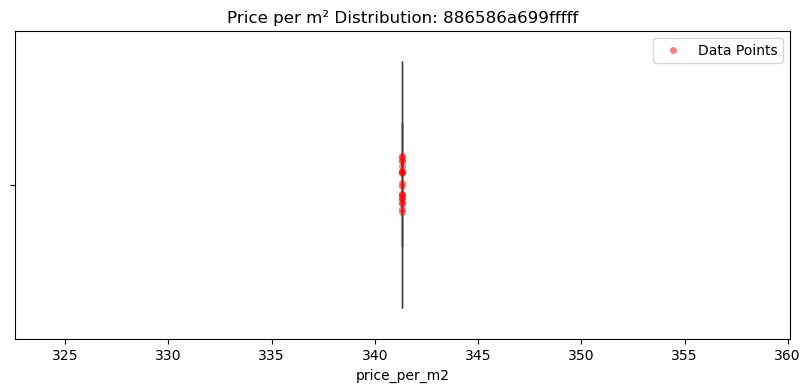

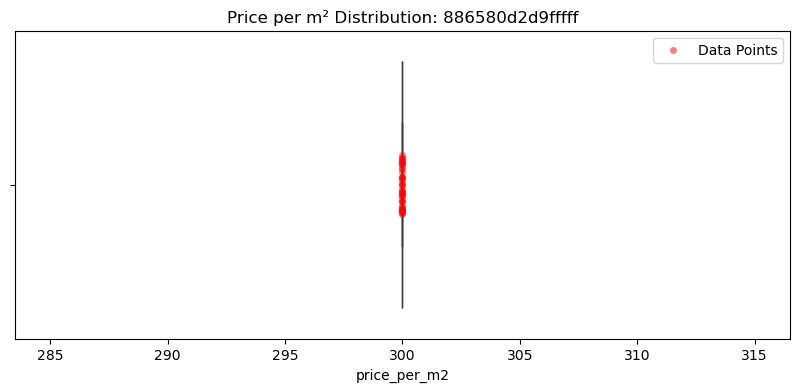

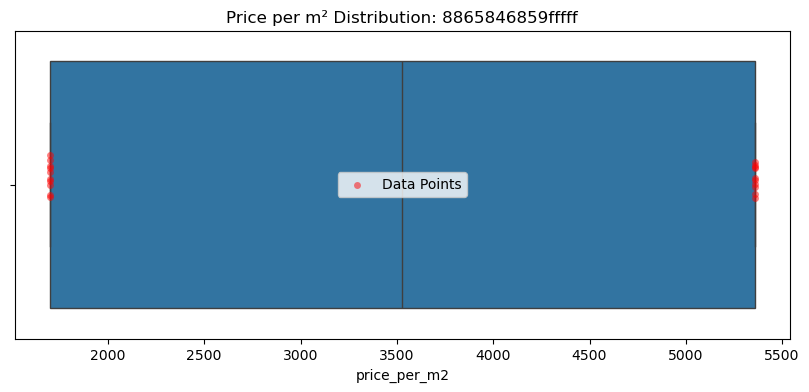

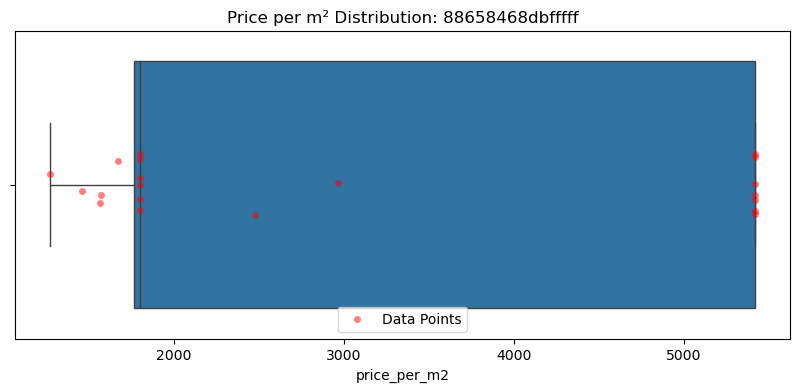

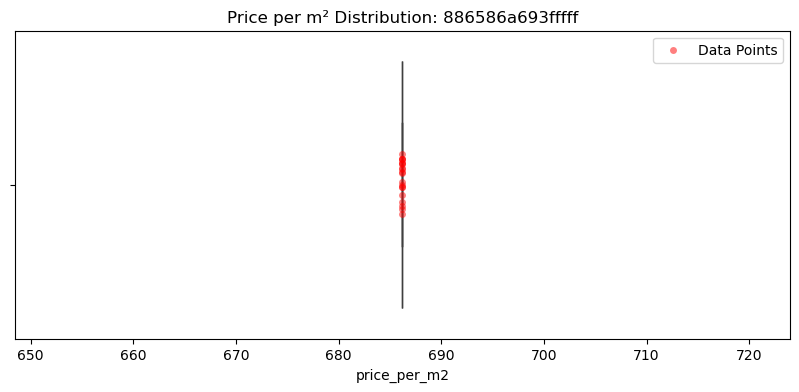

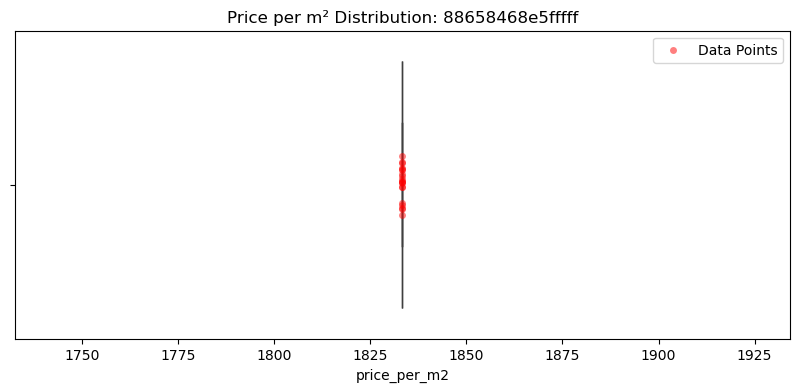

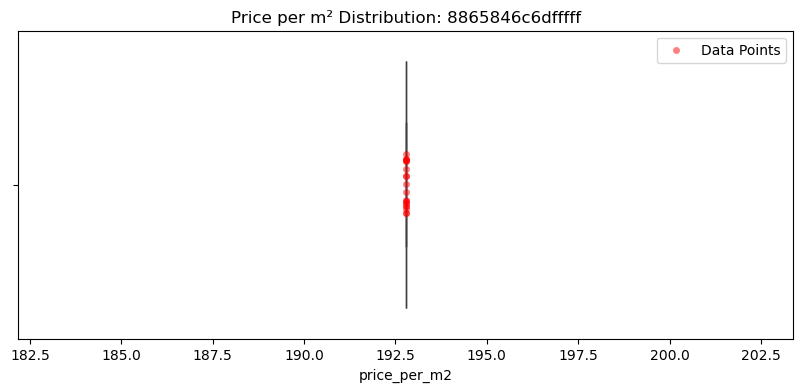

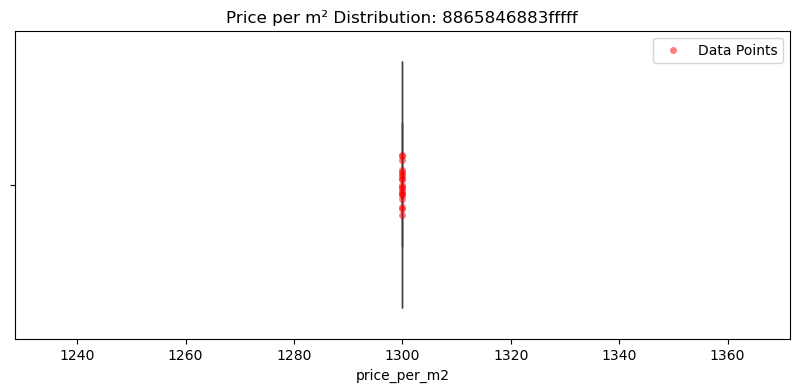

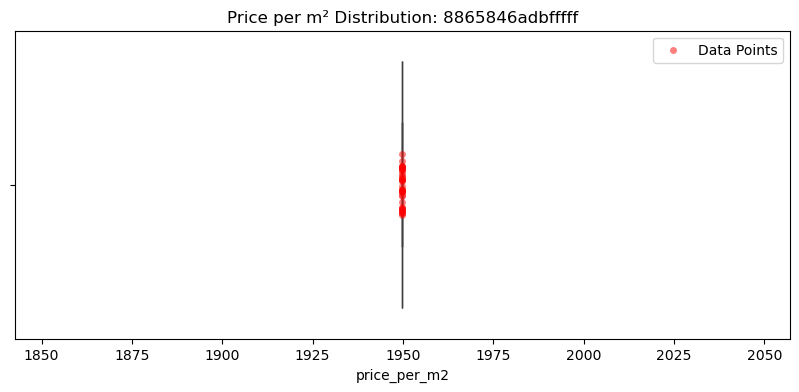

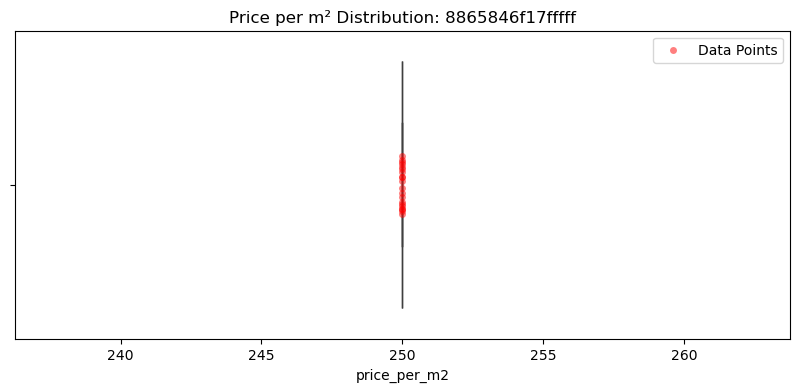

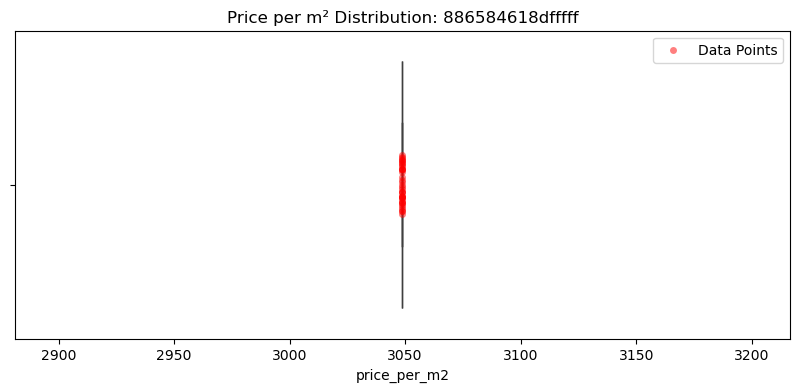

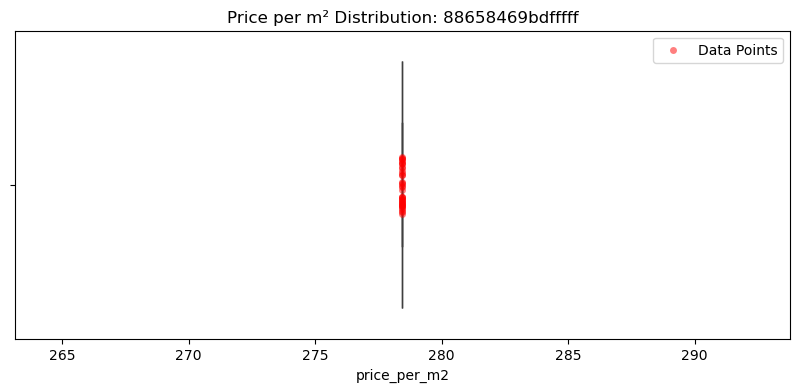

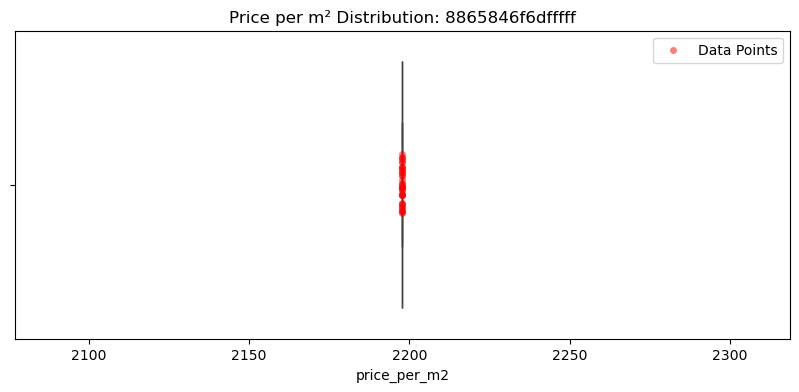

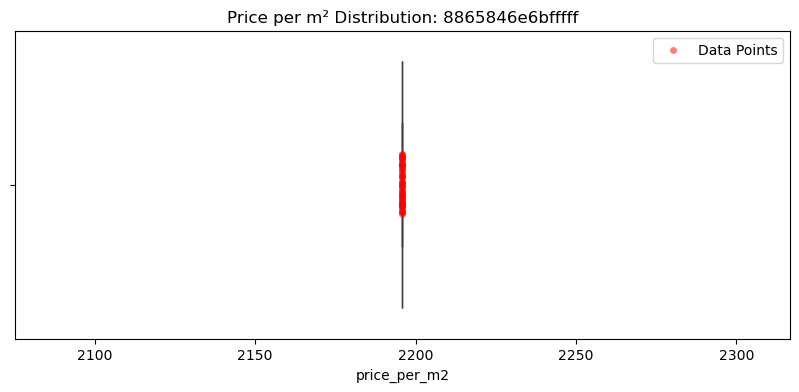

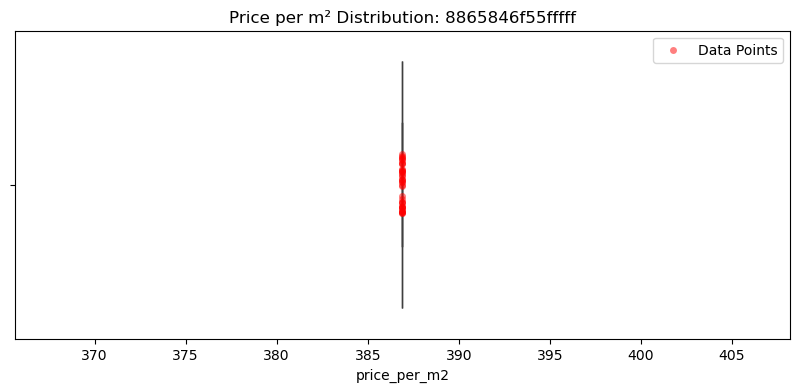

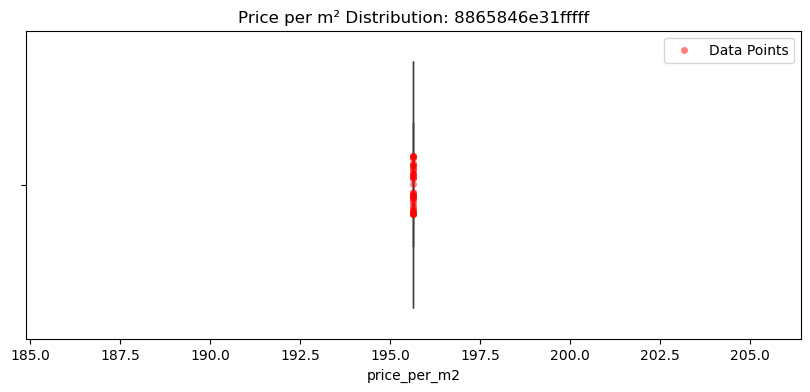

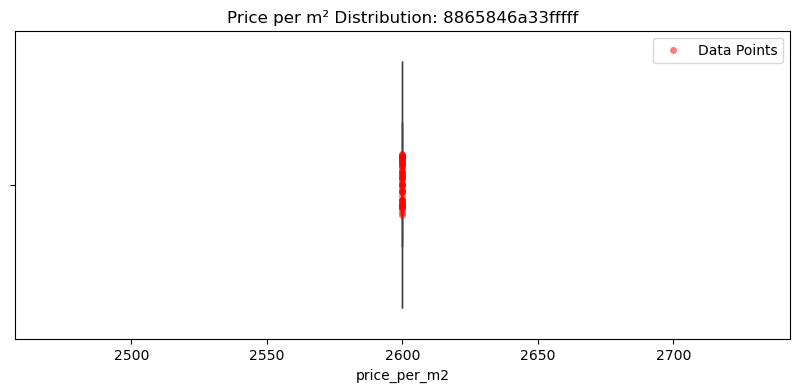

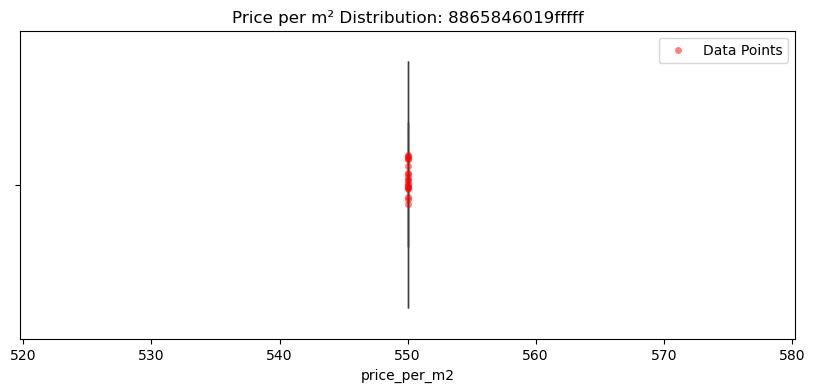

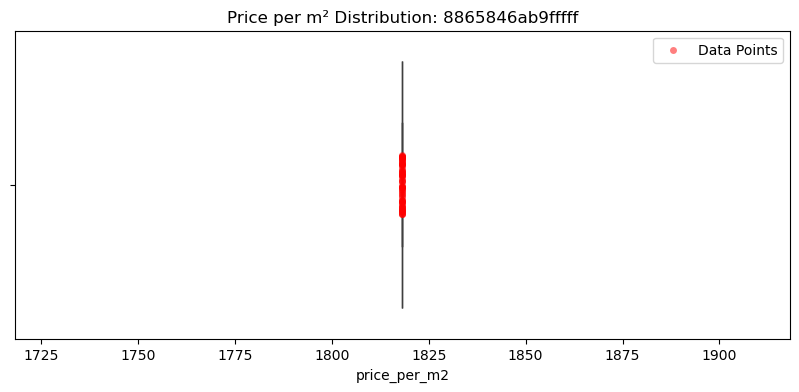

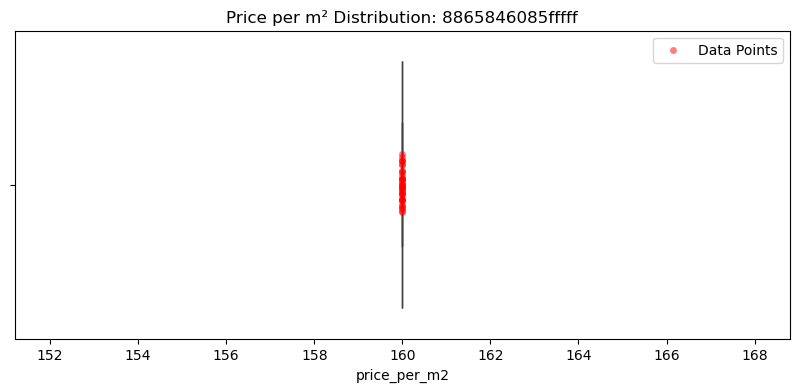

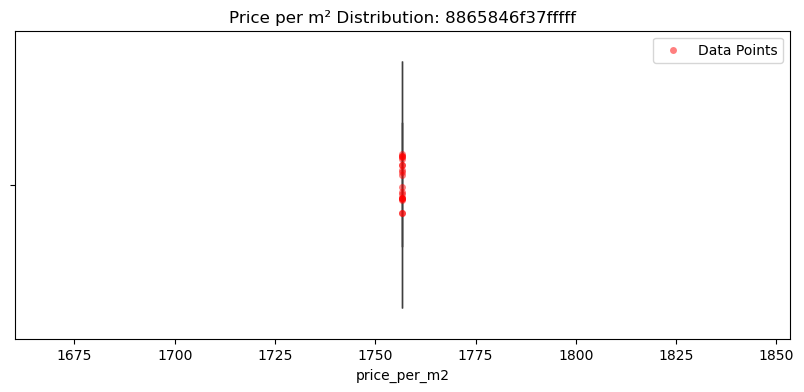

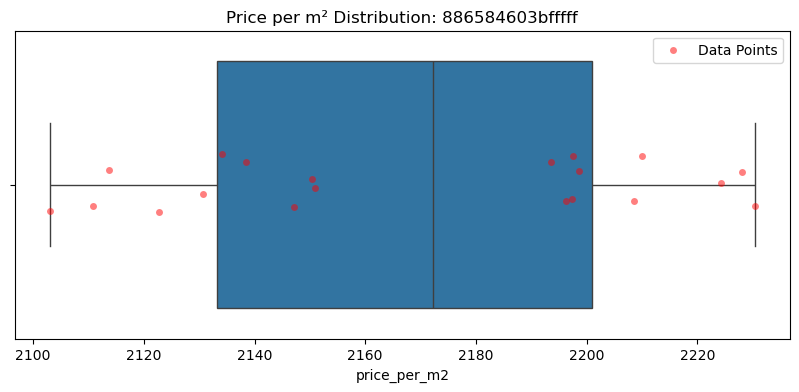

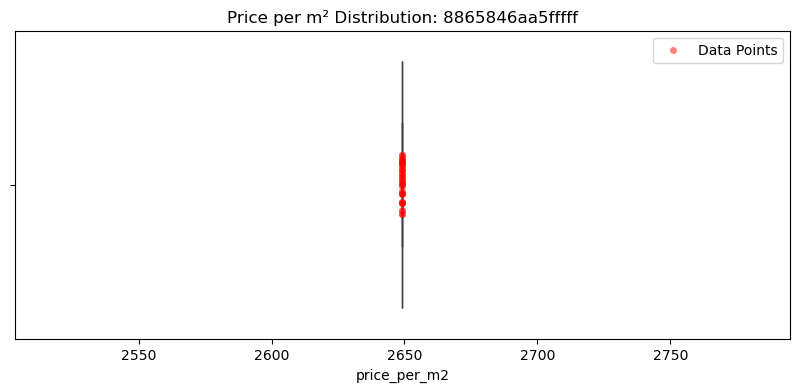

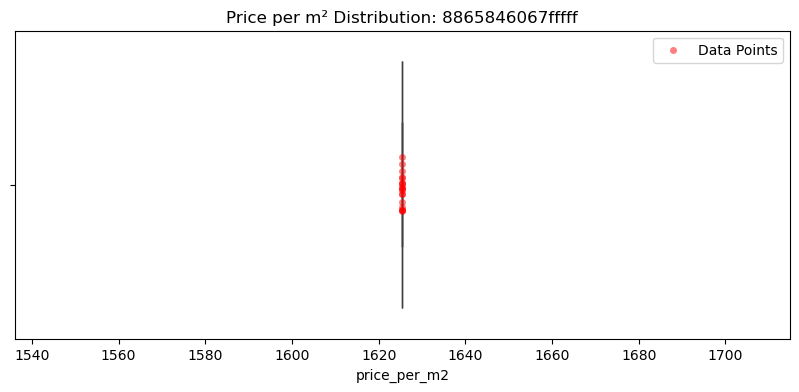

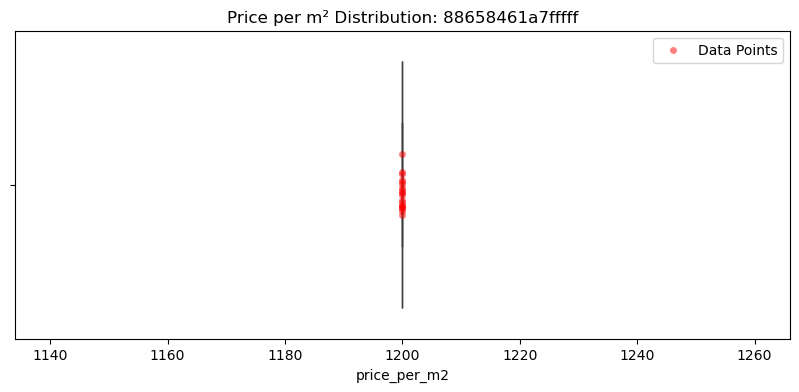

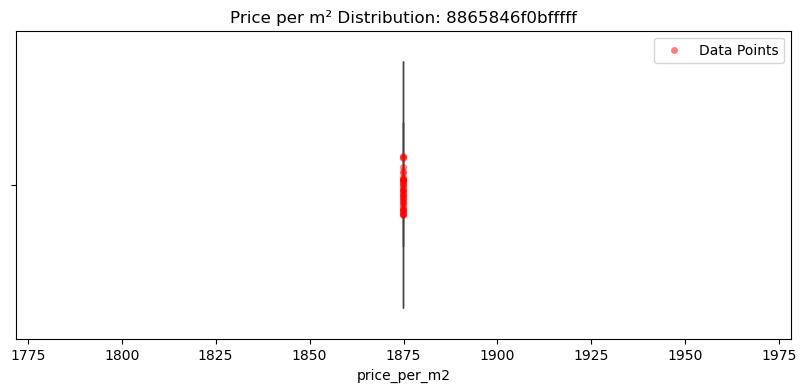

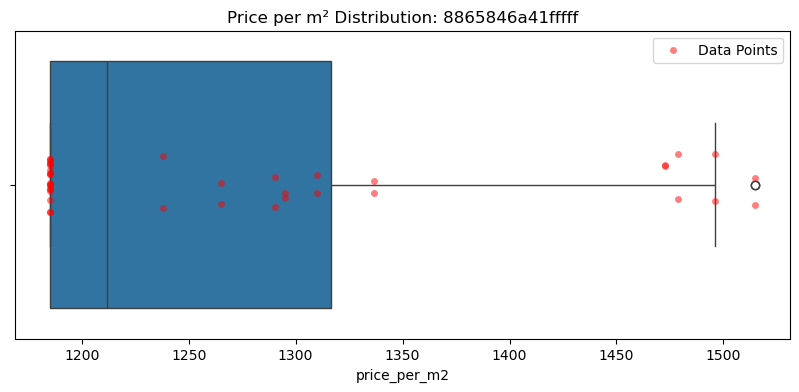

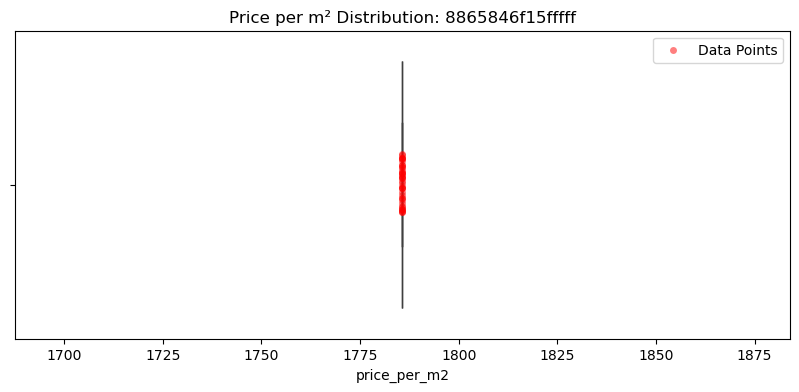

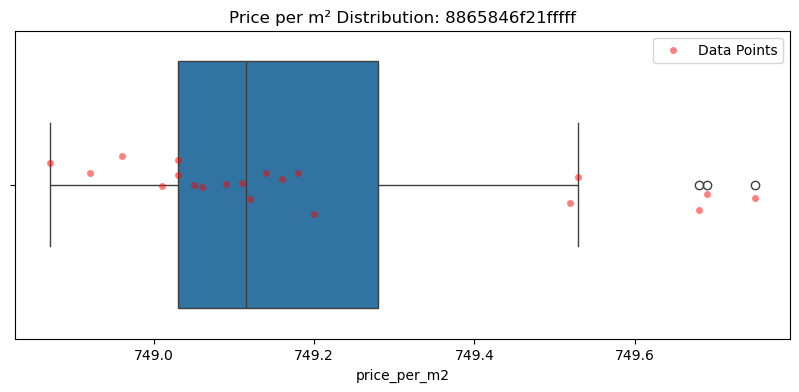

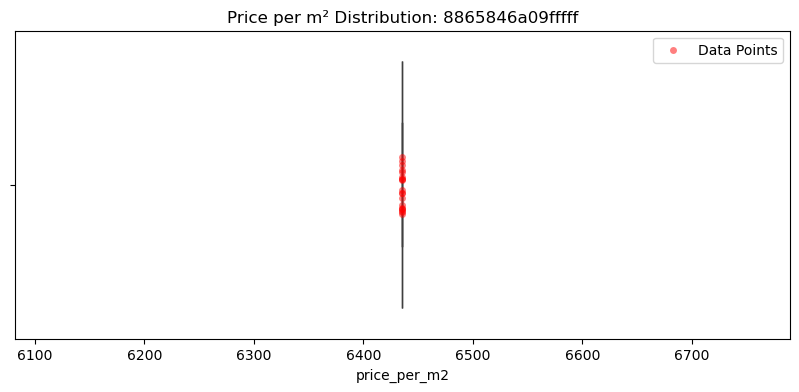

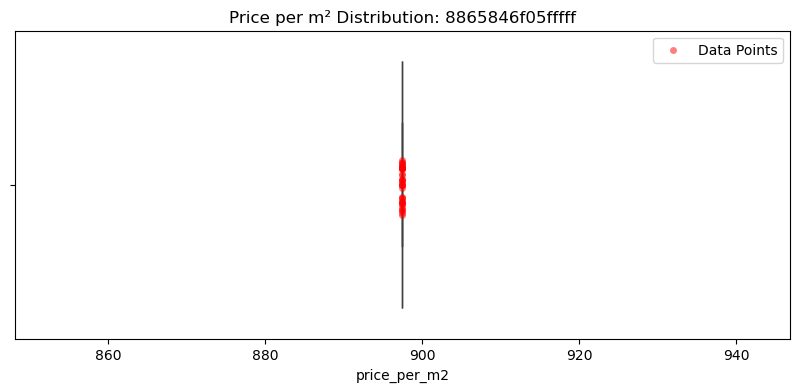

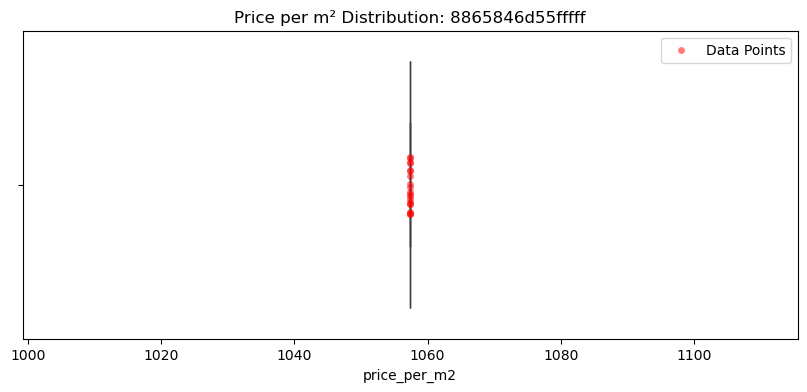

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the first 4 address_line_2 groups for plotting
groups = df['h_id'].unique()[:len(df['h_id'].unique())]

for addr in groups:
    subset = df[df['h_id'] == addr]
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=subset['price_per_m2'])
    sns.stripplot(x=subset['price_per_m2'], color='red', alpha=0.5, label='Data Points')
    plt.title(f'Price per m² Distribution: {addr}')
    plt.xlabel('price_per_m2')
    plt.legend()
    plt.show()

In [53]:
# df.to_csv('../../../data/raw/mockup/generated_data_10000.csv')

In [54]:

# def generate_random_lat_lon_point_in_polygon(wkt_string):
#     """Generate a random (longitude, latitude) point within a polygon."""
#     # Parse WKT and extract the polygon
#     geom = wkt.loads(wkt_string)
#     polygon = geom.geoms[0] if geom.geom_type == 'MultiPolygon' else geom
    
#     # Get polygon bounds
#     min_x, min_y, max_x, max_y = polygon.bounds
    
#     # Generate random points until one falls inside the polygon
#     while True:
#         lon = random.uniform(min_x, max_x)
#         lat = random.uniform(min_y, max_y)
#         point = Point(lon, lat)
#         if polygon.contains(point):
#             return lon, lat


In [55]:
# def generate_price_per_m2(min_val, max_val):
#     """
#     Generate a float between min_val and max_val,
#     but NOT within edge_margin of the edges,
#     and NOT within middle_margin of the midpoint.
#     """
#     edge_margin_percent = 10
#     middle_margin_percent = 10
#     total_range = max_val - min_val
#     midpoint = (min_val + max_val) / 2

#     # Calculate actual margin values based on percentages
#     edge_margin_val = total_range * (edge_margin_percent / 100)
#     middle_margin_val = total_range * (middle_margin_percent / 100)

#     forbidden_ranges = [
#         (min_val, min_val + edge_margin_val),                         # near min
#         (max_val - edge_margin_val, max_val),                         # near max
#         (midpoint - middle_margin_val, midpoint + middle_margin_val)  # near middle
#     ]

#     while True:
#         num = random.uniform(min_val, max_val)
#         if any(lower <= num <= upper for (lower, upper) in forbidden_ranges):
#             continue  # number is in a forbidden range, retry
#         return round(num, 2)  # round to 2 decimal places


In [56]:

# # Prepare fast geometry lookup
# h3_geometry_map = h3.set_index('h3')['geometry'].to_dict()

# csv_data = []
# h_id_counts = defaultdict(int)  # Track how many times each h_id is used
# n = 5000  # Total records to generate

# while len(csv_data) < n:
#     if not data:
#         break

#     subdivisions = list(data.keys())
#     if not subdivisions:
#         continue
#     random_subdivision = random.choice(subdivisions)
#     current_level_data = data[random_subdivision]

#     localities = list(current_level_data.keys())
#     if not localities:
#         continue
#     random_locality = random.choice(localities)
#     current_level_data = current_level_data[random_locality]

#     lines_2 = list(current_level_data.keys())
#     if not lines_2:
#         continue
#     random_line_2 = random.choice(lines_2)
#     current_level_data = current_level_data[random_line_2]

#     h_ids = list(current_level_data.keys())
#     if not h_ids:
#         continue
#     random_h_id = random.choice(h_ids)

#     if h_id_counts[random_h_id] >= 20:
#         continue

#     current_level_data = current_level_data[random_h_id]

#     categories = list(current_level_data.keys())
#     if not categories:
#         continue
#     random_category = random.choice(categories)
#     current_level_data = current_level_data[random_category]

#     types = list(current_level_data.keys())
#     if not types:
#         continue
#     random_type = random.choice(types)
#     final_data = current_level_data[random_type]

#     # Geometry lookup (fast)
#     geometry = h3_geometry_map.get(random_h_id)
#     if not geometry:
#         continue
#     wkt_str = str(geometry)

#     # Generate coordinates
#     try:
#         random_lon, random_lat = generate_random_lat_lon_point_in_polygon(wkt_str)
#     except:
#         continue  # In case geometry is invalid or empty

#     # Generate price-related values
#     area = [num for num in range(30, 120) if num % 2 == 0]
#     random_land_area = random.choice(area)
#     max_price_per_m2 = final_data['max']
#     min_price_per_m2 = final_data['min']

#     try:
#         random_price_per_m2 = generate_price_per_m2(min_price_per_m2, max_price_per_m2)
#     except:
#         continue  # Skip if invalid range

#     # Append record
#     csv_data.append({
#         'address_subdivision': random_subdivision,
#         'address_locality': random_locality,
#         'address_line_2': random_line_2,
#         'h_id': random_h_id,
#         'category_name': random_category,
#         'type': random_type,
#         'price_per_m2': random_price_per_m2,
#         'land_area': random_land_area,
#         'price': random_price_per_m2 * random_land_area,
#         'longitude': random_lon,
#         'latitude': random_lat,
#     })

#     h_id_counts[random_h_id] += 1

#     # Print progress every 100 rows
#     if len(csv_data) % 100 == 0:
#         print(f"✅ Generated {len(csv_data)} / {n} rows...")

# # Final sample print
# print("✅ Done!")
# print(json.dumps(csv_data[0], indent=4))

In [57]:
# # Initialize variables to store the randomly selected keys and the final data
# random_subdivision = None
# random_locality = None
# random_line_2 = None
# random_h_id = None
# random_category = None
# random_type = None
# final_data = None
# random_lon = None
# random_lat = None
# wkt_str = ''
# random_price_per_m2 = None
# ramdom_land_area = None
# random_price = None
# h3_geometry_map = h3.set_index('h3')['geometry'].to_dict()


# # Step-by-step random selection through the nested levels
# if data:
#     subdivisions = list(data.keys())
#     if subdivisions:
#         random_subdivision = random.choice(subdivisions)
#         current_level_data = data[random_subdivision]
    
#         if current_level_data:
#             localities = list(current_level_data.keys())
#             if localities:
#                 random_locality = random.choice(localities)
#                 current_level_data = current_level_data[random_locality]

#                 if current_level_data:
#                     lines_2 = list(current_level_data.keys())
#                     if lines_2:
#                         random_line_2 = random.choice(lines_2)
#                         current_level_data = current_level_data[random_line_2]

#                         if current_level_data:
#                             h_ids = list(current_level_data.keys())
#                             if h_ids:
#                                 random_h_id = random.choice(h_ids)
#                                 current_level_data = current_level_data[random_h_id]

#                                 if current_level_data:
#                                     categories = list(current_level_data.keys())
#                                     if categories:
#                                         random_category = random.choice(categories)
#                                         current_level_data = current_level_data[random_category]

#                                         if current_level_data:
#                                             types = list(current_level_data.keys())
#                                             if types:
#                                                 random_type = random.choice(types)
#                                                 final_data = current_level_data[random_type]
#                                                 # At this point, final_data holds the dictionary with 'mean', 'max', 'min'
#                                                 # Find the geometry for the given random_h_id in the h3 DataFrame
                                                
#                                                 geometry = h3.loc[h3['h3'] == random_h_id, 'geometry'].values
#                                                 wkt_str = f'{geometry[0]}'
                                                
#                                                 random_lon, random_lat = generate_random_lat_lon_point_in_polygon(wkt_str)
                                                
#                                                 area = [num for num in range(30, 120) if num % 2 == 0]
                                                
#                                                 random_land_area = random.choice(area)
#                                                 max_price_per_m2 = final_data['max']
#                                                 min_price_per_m2 = final_data['min']
#                                                 # Append the randomly selected data to csv_dat
#                                                 random_price_per_m2 = generate_price_per_m2(min_price_per_m2, max_price_per_m2)
#                                                 csv_data.append({
#                                                     'address_subdivision': random_subdivision,
#                                                     'address_locality': random_locality,
#                                                     'address_line_2': random_line_2,
#                                                     'h_id': random_h_id,
#                                                     'category_name': random_category,
#                                                     'type': random_type,
#                                                     'price_per_m2': random_price_per_m2,
#                                                     'land_area': random_land_area,
#                                                     'price': random_price_per_m2 * random_land_area,
#                                                     'longitude': random_lon,
#                                                     'latitude': random_lat,
#                                                 })
                                                

# # Print only the final randomly accessed data
# if final_data:
#     print(json.dumps(final_data, indent=4))
# else:
#     print("Could not retrieve a random nested value. The JSON might be empty or a random path led to an empty dictionary.")

In [58]:
# for i in range(5):
        
#     # Step-by-step random selection through the nested levels
#     if data:
#         subdivisions = list(data.keys())
#         if subdivisions:
#             random_subdivision = random.choice(subdivisions)
#             current_level_data = data[random_subdivision]
        
#             if current_level_data:
#                 localities = list(current_level_data.keys())
#                 if localities:
#                     random_locality = random.choice(localities)
#                     current_level_data = current_level_data[random_locality]

#                     if current_level_data:
#                         lines_2 = list(current_level_data.keys())
#                         if lines_2:
#                             random_line_2 = random.choice(lines_2)
#                             current_level_data = current_level_data[random_line_2]

#                             if current_level_data:
#                                 h_ids = list(current_level_data.keys())
#                                 if h_ids:
#                                     random_h_id = random.choice(h_ids)
#                                     current_level_data = current_level_data[random_h_id]

#                                     if current_level_data:
#                                         categories = list(current_level_data.keys())
#                                         if categories:
#                                             random_category = random.choice(categories)
#                                             current_level_data = current_level_data[random_category]

#                                             if current_level_data:
#                                                 types = list(current_level_data.keys())
#                                                 if types:
#                                                     random_type = random.choice(types)
#                                                     final_data = current_level_data[random_type]
#                                                     if final_data:
#                                                         print(json.dumps(final_data, indent=4))
#                                                         selected_address_subdivision = random.choice(random_subdivision)
#                                                         selected_address_locality = random.choice(random_locality[selected_address_subdivision])
#                                                         selected_address_line_2 = random.choice(random_line_2[selected_address_locality])
#                                                         selected_h_id = random.choice(random_h_id[selected_address_line_2])
#                                                         selected_category_name = random.choice(random_category[selected_h_id])
#                                                         selected_type_list = type[selected_category_name]
                                                        
#                                                         # Get the type dictionary safely
#                                                         type_dict = data[selected_address_subdivision] \
#                                                             .get(selected_address_locality, {}) \
#                                                             .get(selected_address_line_2, {}) \
#                                                             .get(selected_h_id, {}) \
#                                                             .get(selected_category_name, {})
                                                        
#                                                         # Only proceed if the selected_type exists in this path
#                                                         valid_types = [t for t in selected_type_list if t in type_dict]
#                                                         if not valid_types:
#                                                             continue  # Try another random path
                                                        
#                                                         selected_type = random.choice(valid_types)
#                                                         stats = type_dict[selected_type]
                                                        
#                                                         print("Subdivision:", selected_address_subdivision)
#                                                         print("Locality:", selected_address_locality)
#                                                         print("Line 2:", selected_address_line_2)
#                                                         print("h_id:", selected_h_id)
#                                                         print("Category:", selected_category_name)
#                                                         print("Type:", selected_type)
#                                                         print("Mean:", stats['mean'])
#                                                         print("Max:", stats['max'])
#                                                         print("Min:", stats['min'])
#                                                     # At this point, final_data holds the dictionary with 'mean', 'max', 'min'


In [59]:

# # Precompute triangulation for each polygon
# def precompute_triangulation(polygon):
#     """Triangulate polygon and return triangles with their area weights"""
#     if polygon.geom_type == 'MultiPolygon':
#         polygon = polygon.geoms[0]
    
#     # Try convex hull for better performance with complex shapes
#     convex_poly = polygon.convex_hull
#     min_x, min_y, max_x, max_y = convex_poly.bounds
    
#     # Use representative point as fallback
#     rep_point = convex_poly.representative_point()
#     return [(min_x, min_y, max_x, max_y), rep_point]

# def generate_random_lat_lon_point_in_polygon(triangulation_data):
#     """Generate random point using precomputed triangulation"""
#     bounds, rep_point = triangulation_data
#     min_x, min_y, max_x, max_y = bounds
    
#     # Try up to 50 times before using representative point
#     for _ in range(50):
#         lon = random.uniform(min_x, max_x)
#         lat = random.uniform(min_y, max_y)
#         point = Point(lon, lat)
#         return lon, lat  # Return first point in bounds
    
#     # Fallback to representative point if no point found
#     return rep_point.x, rep_point.y

# def precompute_price_ranges(min_val, max_val, edge_margin=10, middle_margin=10):
#     """
#     Precompute allowed price ranges to avoid rejection sampling.
    
#     Improvements:
#     - Added parameter defaults for margins
#     - Added input validation
#     - Improved range calculation logic
#     - Better handling of small value ranges
#     """
#     # Validate inputs
#     if min_val >= max_val:
#         return []
    
#     total_range = max_val - min_val
#     midpoint = (min_val + max_val) / 2
    
#     # Calculate margins as percentages but ensure minimum absolute margins
#     edge_margin_val = max(total_range * (edge_margin / 100), 0.01)
#     middle_margin_val = max(total_range * (middle_margin / 100), 0.01)
    
#     # Calculate candidate ranges
#     lower_range = (min_val + edge_margin_val, midpoint - middle_margin_val)
#     upper_range = (midpoint + middle_margin_val, max_val - edge_margin_val)
    
#     # Filter and return valid ranges
#     valid_ranges = []
#     for low, high in [lower_range, upper_range]:
#         if low < high:
#             valid_ranges.append((low, high))
    
#     return valid_ranges

# def generate_price_per_m2(min_val, max_val, max_attempts=100):
#     """
#     Generate price using precomputed ranges with robust fallbacks.
    
#     Improvements:
#     - Added max_attempts to prevent infinite loops
#     - Better handling of edge cases
#     - Fallback to truncated normal when ranges are small
#     - Improved floating point precision
#     """
#     # Handle case where min and max are too close
#     if abs(max_val - min_val) < 0.01:
#         return round(min_val, 2)
    
#     # Get valid price ranges
#     allowed_ranges = precompute_price_ranges(min_val, max_val)
    
#     # Case 1: We have valid ranges to choose from
#     if allowed_ranges:
#         # Calculate weights based on range sizes
#         weights = [high - low for low, high in allowed_ranges]
#         total_weight = sum(weights)
        
#         # Select a range based on weight
#         rand_val = random.uniform(0, total_weight)
#         cumulative = 0
#         for i, (low, high) in enumerate(allowed_ranges):
#             cumulative += weights[i]
#             if rand_val <= cumulative:
#                 return round(random.uniform(low, high), 2)
    
#     # Case 2: Fallback to truncated normal distribution for small ranges
#     mean = (min_val + max_val) / 2
#     std_dev = (max_val - min_val) / 6
    
#     for _ in range(max_attempts):
#         # Generate value from normal distribution
#         price = random.gauss(mean, std_dev)
        
#         # Truncate to min/max bounds
#         price = max(min_val, min(max_val, price))
        
#         # Check if it's not too close to edges or center
#         edge_threshold = (max_val - min_val) * 0.1
#         center_threshold = (max_val - min_val) * 0.1
        
#         is_near_edge = (price < min_val + edge_threshold) or (price > max_val - edge_threshold)
#         is_near_center = abs(price - mean) < center_threshold
        
#         if not (is_near_edge or is_near_center):
#             return round(price, 2)
    
#     # Final fallback: middle 80% range
#     low = min_val + (max_val - min_val) * 0.1
#     high = max_val - (max_val - min_val) * 0.1
#     return round(random.uniform(low, high), 2)

# # Precomputation phase - DO THIS BEFORE THE LOOP
# print("Precomputing geometry optimizations...")
# h3_geometry_map = h3.set_index('h3')['geometry'].to_dict()
# h3_triangulation_map = {}

# for h_id, geom_str in h3_geometry_map.items():
#     try:
#         geom = wkt.loads(str(geom_str))
#         h3_triangulation_map[h_id] = precompute_triangulation(geom)
#     except:
#         h3_triangulation_map[h_id] = ((0, 0, 1, 1), Point(0.5, 0.5))

# # Precompute land area choices
# area_choices = [num for num in range(30, 120) if num % 2 == 0]

# # Flatten the JSON structure for direct sampling
# print("Flattening JSON structure...")
# flat_records = []
# for subdiv, localities in data.items():
#     for locality, streets in localities.items():
#         for street, h_ids_data in streets.items():
#             for h_id, categories_data in h_ids_data.items():
#                 for category, types_data in categories_data.items():
#                     for p_type, metrics in types_data.items():
#                         flat_records.append({
#                             'address_subdivision': subdiv,
#                             'address_locality': locality,
#                             'address_line_2': street,
#                             'h_id': h_id,
#                             'category_name': category,
#                             'type': p_type,
#                             'metrics': metrics
#                         })
